In [4]:
# Import package
import argparse
from collections import Counter
import logging
import math
import os
import random
import re
import shutil
from shutil import copyfile
import sys
import threading
import time
#import utils
import zipfile
# Data Science packages
# import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import loadmat




In [2]:
print("====> Start running baseline.py")
# Understand the file structure of dataset
DATA_PATH = '/fs/scratch/PAA0023/dong760/PlantVillage-Dataset/raw/color/'
# train_dir = "/fs/scratch/PAS1777/imdb_wiki/dataset/{}/train".format(db)
# test_dir = "/fs/scratch/PAS1777/imdb_wiki/dataset/{}/test".format(db)
Classes = os.listdir(DATA_PATH)
print(f"Classes: {Classes}")

# Understand the # of classes:
Num_Classes = len(os.listdir(DATA_PATH))
print(f"Number of classes: {Num_Classes}") # ==> Number of classes: 38

# Understand the total number of images
import pathlib
data_dir = pathlib.Path(DATA_PATH)
image_count = len(list(data_dir.glob('*/*.*')))
print(f"Total number of images: {image_count}")

# Display an images as sample:
# import PIL
# import PIL.Image
# roses = list(data_dir.glob('Corn_(maize)___Common_rust_/*'))
# PIL.Image.open(str(roses[0]))


====> Start running baseline.py
Classes: ['Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Peach___healthy', 'Grape___Esca_(Black_Measles)', 'Potato___Late_blight', 'Pepper,_bell___Bacterial_spot', 'Strawberry___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Leaf_Mold', 'Apple___Black_rot', 'Strawberry___Leaf_scorch', 'Tomato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Blueberry___healthy', 'Potato___Early_blight', 'Pepper,_bell___healthy', 'Apple___Cedar_apple_rust', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Tomato_mosaic_virus', 'Tomato___Target_Spot', 'Tomato___healthy', 'Peach___Bacterial_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Corn_(maize)___healthy', 'Squash___Powdery_mildew', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Bacterial_spot', 'Grape___Black_rot', 'Apple___healthy', 'Potato___healthy', 'Corn_(maize)__

first_folder_path: /fs/scratch/PAA0023/dong760/PlantVillage-Dataset/raw/color/Tomato___Late_blight
Number of folder: 38
sample image path: /fs/scratch/PAA0023/dong760/PlantVillage-Dataset/raw/color/Tomato___Late_blight/5fdf3288-d5f4-4c70-9b12-95222b82d415___RS_Late.B 4942.JPG
Image size: (256, 256, 3)


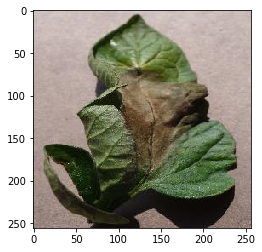

In [3]:
# Let's figure out a way to understand the shape of image
folder_path = [os.path.join(DATA_PATH, path) for path in os.listdir(DATA_PATH)]
first_folder_path =folder_path[0]
print(f"first_folder_path: {first_folder_path}")
print(f"Number of folder: {len(folder_path)}")

# img_path_list = np.array([[os.path.join(folder, img_path) for img_path in os.listdir(folder)] for folder in folder_path], dtype = 'object')
img_path_list = [[os.path.join(folder, img_path) for img_path in os.listdir(folder)] for folder in folder_path]
first_img_path = img_path_list[0][0]
print(f"sample image path: {first_img_path}")

# Understand the shape of an image
img = mpimg.imread(first_img_path)
print(f"Image size: {img.shape}") # ==> Image size: (256, 256, 3)

# Display one image if you want to 
plt.imshow(img, interpolation='nearest')
plt.show()

# Get the total number of images with map reduce (refers to https://stackabuse.com/map-filter-and-reduce-in-python-with-examples/)
# from functools import reduce
# num_images = reduce(lambda x,arr2: (x+len(arr2)), img_path_list, 0)
# print(f"Total number of images: {num_images}")

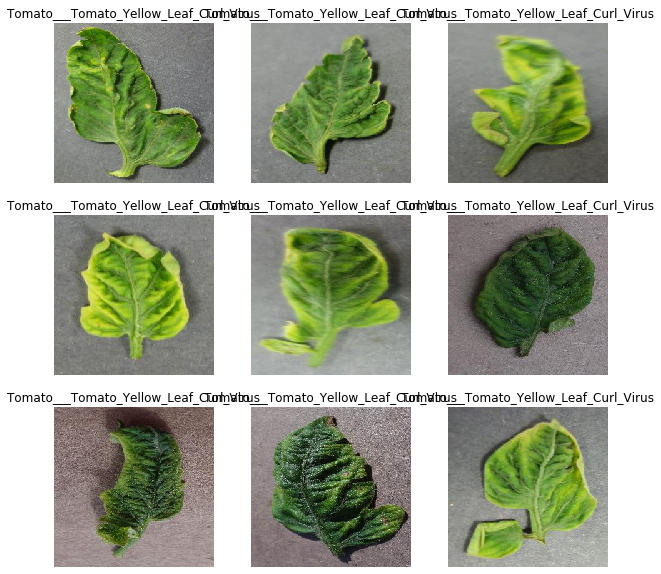

In [4]:
%matplotlib inline 
# Visualize the dataset
from matplotlib import pyplot as plt
class_names = [[str(folder) for i in os.listdir(os.path.join(DATA_PATH, folder))] for folder in os.listdir(DATA_PATH)]
images = [[os.path.join(folder, img_path) for img_path in os.listdir(folder)] for folder in folder_path]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = mpimg.imread(images[1][i])
    plt.imshow(img, interpolation='nearest')
    plt.title(class_names[1][i])
    plt.axis("off")
plt.show()

In [18]:
# Model configuration
BASE_DIR = "/users/PAA0023/dong760/plant_leaves_diagnosis"
MODEL_NAME = 'baseline_sparse_categorical_model'
batch_size = 32
no_epochs = 2
img_width, img_height, img_num_channels = 256, 256, 3
loss_function = 'sparse_categorical_crossentropy' # 'mean_squared_error', 'mean_absolute_error', 'binary_crossentropy', 'sparse_categorical_crossentropy'
metrics = ['accuracy'] # 'accuracy', 'precision', 'recall', 'auc', and more(https://www.tensorflow.org/tfx/model_analysis/metrics)
no_classes = len(os.listdir(DATA_PATH))
optimizer = tf.keras.optimizers.Adam(0.001) # SGD, Adagrad, RMSprop
validation_split = 0.2
verbosity = 2 # 0 = silent, 1 = progress bar, 2 = one line per epoch. 
steps_per_epoch = 10 # Total number of steps for one epochs
lr = 0.001
momentum=0.9

DESIRED_ACCURACY = 0.99
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>DESIRED_ACCURACY):
            print("\nReached ",DESIRED_ACCURACY, "% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()


In [6]:
# Setting up the ImageGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing import image_dataset_from_directory

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(img_width, img_height),  # (256, 256, 3)
    color_mode='rgb', #  "grayscale", "rgb", "rgba", Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.
    class_mode = 'sparse', # One of "categorical", "binary", "sparse", "input", or None.
#     label_mode='int', # 'int': encoded as integer for sparse_categorical_crossentropy loss, 'categorical': encoded as categorical vector for categorical_crossentropy loss, 'binary': encoded as 0 or 1 for binary_crossentropy
    batch_size=batch_size,
    shuffle=True,
#     save_to_dir = '/users/PAA0023/dong760/plant_leaves_diagnosis/tmp/augmented_train', # This allows you to optionally specify a directory to which to save the augmented pictures being generated (useful for visualizing what you are doing).
    seed=123,
    subset="training",
    interpolation='nearest' #  Supported methods are "nearest", "bilinear", and "bicubic"
)
# print(type(train_generator))
# print(train_generator.shape)

validation_generator = train_datagen.flow_from_directory(
    DATA_PATH,
    target_size=(img_width, img_height),  # (256, 256, 3)
    color_mode='rgb', #  "grayscale", "rgb", "rgba", Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.
    class_mode = 'sparse', # One of "categorical", "binary", "sparse", "input", or None.
#     label_mode='int', # 'int': encoded as integer for sparse_categorical_crossentropy loss, 'categorical': encoded as categorical vector for categorical_crossentropy loss, 'binary': encoded as 0 or 1 for binary_crossentropy
    batch_size=batch_size,
    shuffle=True,
#     save_to_dir = '/users/PAA0023/dong760/plant_leaves_diagnosis/tmp/augmented_valid', # This allows you to optionally specify a directory to which to save the augmented pictures being generated (useful for visualizing what you are doing).
    seed=123,
    subset="validation",
    interpolation='nearest' #  Supported methods are "nearest", "bilinear", and "bicubic"
)
# print(type(validation_generator))
# print(validation_generator.shape)

# Define some variable for Horovod
train_iterator = train_generator
train_size = train_iterator.n # OR len(train_iterator.filepaths), len(train_iterator.classes), len(train_iterator.filenames)
# batch_size = train_iterator.batch_size
# val_size = validation_iterator.n
# len(train_iterator.filepaths)
# len(train_iterator.classes)
# train_iterator.num_classes
# train_iterator.image_shape
# train_iterator.batch_size
# train_iterator.dtype
print(f"Train size: {train_size}")


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Train size: 43456


Images: (32, 256, 256, 3)
Label: (32,)


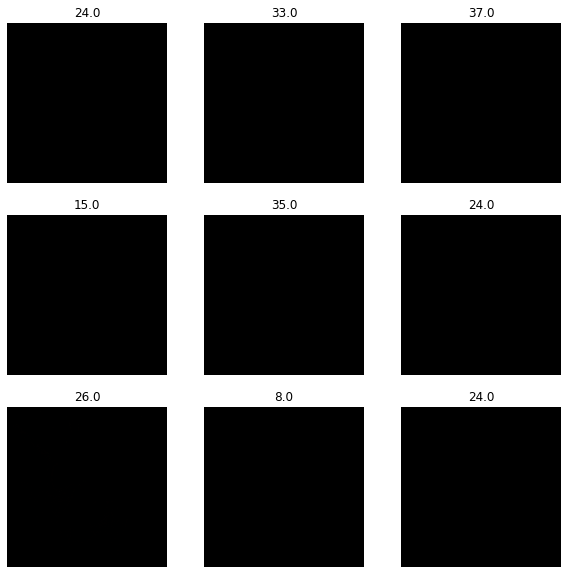

In [7]:
%matplotlib inline 
# Visualize the dataset
# class_names = train_iterator.classes
from PIL import Image
images, labels = train_iterator.next()
print(f"Images: {images.shape}")
print(f"Label: {labels.shape}")
class_names = np.unique(train_iterator.classes)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(labels[i])
    plt.axis("off")

# Note: you need to remove the rescaling 1./255, if you want to visualize by using Image Generator
# train_datagen = ImageDataGenerator(validation_split=validation_split)
# validation_datagen = ImageDataGenerator(validation_split)

In [1]:
# Configure the pre-trained models:
MODEL_NAME = 'NASNetMobile' # NASNetLarge, MobileNetV3Large, MobileNetV3Small
IMG_SHAPE = (img_width, img_height, img_num_channels)
# For NASNetMobile
NASNetMobile_model = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
                                                        include_top=False,
                                                        weights=None)
# For NASNetLarge
NASNetLarge_model = tf.keras.applications.NASNetLarge(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights=None)
# For MobileNetV3Large
# MobileNetV3Large_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
#                                                                 include_top=False,
#                                                                 weights='imagenet')
# For MobileNetV3Small
# MobileNetV3Small_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
#                                                                 include_top=False,
#                                                                 weights='imagenet')

# Lock each layer in pre_trained_model
for layer in NASNetMobile_model.layers:
    layer.trainable = False

# Fine tuning the model: Define the new model by adding extra fully connected layers
last_output = NASNetMobile_model.output
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output_layer = tf.keras.layers.Dense(no_classes, activation='softmax')(x)
model = tf.keras.Model(inputs=NASNetMobile_model.input, outputs=output_layer)


# Instantiate the Model object
# More detail about compile: https://www.tensorflow.org/guide/keras/train_and_evaluate
optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=momentum)
# optimizer = tf.keras.optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics)
print(f"\n====> Statistics: MODEL_NAME={MODEL_NAME}, epochs={no_epochs}, batch_size={batch_size}, validation_split={validation_split}, lr={lr}, momentum={momentum}, steps_per_epoch ={steps_per_epoch}, feature shape= {(img_width, img_height, img_num_channels)}, no_classes={no_classes }, loss_function={loss_function}")
print(model.summary())


NameError: name 'img_width' is not defined

In [14]:
print(tf.__version__)

2.0.0


In [21]:
tf.keras.utils.plot_model(model, './test.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
%matplotlib inline 
# Visualize the dataset
from matplotlib import pyplot as plt
class_names = [[str(folder) for i in os.listdir(os.path.join(DATA_PATH, folder))] for folder in os.listdir(DATA_PATH)]
images = [[os.path.join(folder, img_path) for img_path in os.listdir(folder)] for folder in folder_path]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = mpimg.imread(images[1][i])
    plt.imshow(img, interpolation='nearest')
    plt.title(class_names[1][i])
    plt.axis("off")
plt.show()

In [12]:
ResNet_02 = {'loss': [3.7794201374053955, 3.4177160263061523, 3.38014817237854, 3.3664169311523438, 3.3594608306884766, 3.3552613258361816, 3.352508783340454, 3.3506219387054443, 3.3492867946624756, 3.3483030796051025, 3.34757399559021, 3.3470206260681152, 3.3465828895568848, 3.3462467193603516, 3.345980405807495, 3.345770835876465, 3.3455991744995117, 3.3454482555389404, 3.345348596572876, 3.3452508449554443, 3.3451716899871826, 3.3451056480407715, 3.3450393676757812, 3.344996690750122, 3.3449394702911377, 3.3449175357818604, 3.34489369392395, 3.3448679447174072, 3.344839096069336, 3.3448121547698975, 3.3448078632354736, 3.344789505004883, 3.344780921936035, 3.3447635173797607, 3.344754695892334, 3.3447444438934326, 3.3447372913360596, 3.344717502593994, 3.3447229862213135, 3.344716787338257], 'accuracy': [0.09924981743097305, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10113678127527237, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.100308358669281, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286], 'precision': [0.05528846010565758, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.0005292709683999419, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'auc': [0.6495130658149719, 0.694237470626831, 0.6962851881980896, 0.7004990577697754, 0.7016860246658325, 0.7023895382881165, 0.7027557492256165, 0.7031845450401306, 0.7031943202018738, 0.7031029462814331, 0.703006386756897, 0.7030603289604187, 0.703079879283905, 0.7028968930244446, 0.7028513550758362, 0.7027973532676697, 0.7032042741775513, 0.7035109996795654, 0.7034026980400085, 0.7034397125244141, 0.7034322023391724, 0.7034515738487244, 0.7034856081008911, 0.703479528427124, 0.7034202218055725, 0.7033522129058838, 0.7034894227981567, 0.7036186456680298, 0.7035185694694519, 0.7034872174263, 0.7034769654273987, 0.7034669518470764, 0.7034639120101929, 0.7035550475120544, 0.70354825258255, 0.7036130428314209, 0.7035060524940491, 0.7034614086151123, 0.7035642862319946, 0.7035232782363892], 'val_loss': [3.473935842514038, 3.39143443107605, 3.3708136081695557, 3.361534357070923, 3.3562769889831543, 3.3529176712036133, 3.3506462574005127, 3.349062204360962, 3.3479080200195312, 3.3470656871795654, 3.346423864364624, 3.345928430557251, 3.345547676086426, 3.345242738723755, 3.345004081726074, 3.3448078632354736, 3.3446462154388428, 3.344517946243286, 3.344406843185425, 3.3443186283111572, 3.344245433807373, 3.3441812992095947, 3.3441295623779297, 3.344087839126587, 3.344048500061035, 3.344014883041382, 3.3439807891845703, 3.3439581394195557, 3.343935012817383, 3.3439223766326904, 3.3439011573791504, 3.3438875675201416, 3.343873977661133, 3.343860149383545, 3.3438522815704346, 3.343841075897217, 3.3438334465026855, 3.3438363075256348, 3.3438191413879395, 3.343811273574829], 'val_accuracy': [0.09383353590965271, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_auc': [0.647680938243866, 0.6965564489364624, 0.6998650431632996, 0.7015079259872437, 0.7024268507957458, 0.7030341029167175, 0.7033684253692627, 0.7034826874732971, 0.7034728527069092, 0.7033368945121765, 0.7033883929252625, 0.7033968567848206, 0.7033962607383728, 0.7031619548797607, 0.7033458352088928, 0.7033438086509705, 0.7037695050239563, 0.7037695050239563, 0.7037691473960876, 0.7037688493728638, 0.7037688493728638, 0.7037685513496399, 0.7037685513496399, 0.7037690877914429, 0.7037685513496399, 0.7038388848304749, 0.7038385272026062, 0.7038385272026062, 0.7038388848304749, 0.7038388252258301, 0.7038388252258301, 0.7038390636444092, 0.7038381695747375, 0.7039579749107361, 0.7038381695747375, 0.7038388252258301, 0.7038385272026062, 0.7038005590438843, 0.7038385272026062, 0.7038385272026062]}
ResNet_04 = {'loss': [3.611133575439453, 3.1738152503967285, 3.1287693977355957, 3.1028192043304443, 3.0710861682891846, 3.0517613887786865, 3.0339102745056152, 3.0258381366729736, 3.0178494453430176, 3.0097646713256836, 2.9977571964263916, 2.9990618228912354, 2.985275983810425, 2.974832534790039, 2.98195743560791, 2.980259895324707, 2.969635248184204, 2.964937210083008, 2.971553087234497, 2.967181444168091, 2.9621164798736572, 2.956796407699585, 2.9511055946350098, 2.9569053649902344, 2.953155517578125, 2.9451842308044434, 2.9318501949310303, 2.9417214393615723, 2.937014102935791, 2.9319357872009277, 2.9462621212005615, 2.9283699989318848, 2.929476737976074, 2.924510955810547, 2.932840585708618, 2.9393837451934814, 2.9255402088165283, 2.9278478622436523, 2.917001724243164, 2.9363603591918945], 'accuracy': [0.12690962851047516, 0.1495797336101532, 0.16369102895259857, 0.16786305606365204, 0.17332351207733154, 0.17485734820365906, 0.17967359721660614, 0.17841584980487823, 0.1798269897699356, 0.18114608526229858, 0.18019510805606842, 0.18083931505680084, 0.18360021710395813, 0.18200503289699554, 0.17979630827903748, 0.18096202611923218, 0.1816982626914978, 0.18166758120059967, 0.18191300332546234, 0.18083931505680084, 0.18252652883529663, 0.18215841054916382, 0.18209706246852875, 0.1816062331199646, 0.1824038326740265, 0.1807166039943695, 0.18317075073719025, 0.18086999654769897, 0.18154488503932953, 0.1824958622455597, 0.18225044012069702, 0.18200503289699554, 0.18013374507427216, 0.18292532861232758, 0.183477520942688, 0.1818823218345642, 0.18163691461086273, 0.18292532861232758, 0.18498067557811737, 0.18289466202259064], 'precision': [0.14393939077854156, 0.6552631855010986, 0.6705539226531982, 0.6242568492889404, 0.5971291661262512, 0.6099733114242554, 0.5854968428611755, 0.5694946050643921, 0.5398074984550476, 0.5231441259384155, 0.5263158082962036, 0.47477981448173523, 0.5038759708404541, 0.4923599362373352, 0.4710669219493866, 0.48533108830451965, 0.4537264406681061, 0.46517857909202576, 0.4790419042110443, 0.4398682117462158, 0.4303797483444214, 0.4494296610355377, 0.44184398651123047, 0.4207450747489929, 0.42625367641448975, 0.43613001704216003, 0.43720489740371704, 0.42484796047210693, 0.3936507999897003, 0.4237140417098999, 0.39937105774879456, 0.4075562655925751, 0.37310031056404114, 0.42124277353286743, 0.4022485911846161, 0.40417689085006714, 0.3990024924278259, 0.3988055884838104, 0.4116719365119934, 0.4150485396385193], 'recall': [0.0023314314894378185, 0.007638505659997463, 0.014111295342445374, 0.016105283051729202, 0.019142279401421547, 0.02101355977356434, 0.020062580704689026, 0.019357016310095787, 0.018927542492747307, 0.01837536133825779, 0.018406037241220474, 0.018191300332546234, 0.01595189981162548, 0.01779250241816044, 0.015982575714588165, 0.017761826515197754, 0.016994908452033997, 0.015982575714588165, 0.017178967595100403, 0.01638137362897396, 0.018774157389998436, 0.018129946663975716, 0.019111601635813713, 0.0176697950810194, 0.01773114874958992, 0.017700472846627235, 0.014203324913978577, 0.015000920742750168, 0.015215657651424408, 0.01490889023989439, 0.019479721784591675, 0.01555310096591711, 0.015062273479998112, 0.01788453198969364, 0.019755812361836433, 0.020185288041830063, 0.019633106887340546, 0.01843671314418316, 0.01601325161755085, 0.020982882007956505], 'auc': [0.7251958847045898, 0.756014883518219, 0.7691707611083984, 0.7762386202812195, 0.7813491821289062, 0.7845807671546936, 0.7875714302062988, 0.78992760181427, 0.791516125202179, 0.7934471964836121, 0.7956780791282654, 0.7949337959289551, 0.7970777153968811, 0.7988920211791992, 0.7967489957809448, 0.7973989248275757, 0.7996988892555237, 0.800378143787384, 0.7986866235733032, 0.7995972037315369, 0.8013759851455688, 0.8022864460945129, 0.8031790852546692, 0.8020926117897034, 0.8029503226280212, 0.8045360445976257, 0.8067930340766907, 0.8043920397758484, 0.8059679269790649, 0.8059120178222656, 0.8043419718742371, 0.807371199131012, 0.8076831102371216, 0.8080900311470032, 0.8068251013755798, 0.8060043454170227, 0.8084946274757385, 0.8080928921699524, 0.8088697791099548, 0.8062934875488281], 'val_loss': [3.1718368530273438, 3.165165901184082, 3.0893454551696777, 3.0539700984954834, 3.02899169921875, 3.015388250350952, 3.0214953422546387, 3.020036458969116, 3.0232622623443604, 2.985386610031128, 3.1315977573394775, 3.005998134613037, 2.9926161766052246, 2.9447882175445557, 2.9536447525024414, 2.9742538928985596, 2.9473717212677, 2.962542772293091, 2.955744981765747, 3.0091211795806885, 3.003549337387085, 2.920747995376587, 2.9470150470733643, 2.959296226501465, 2.941162347793579, 2.9762022495269775, 2.938053607940674, 2.9283087253570557, 2.9997994899749756, 2.900392770767212, 2.917670249938965, 2.8954193592071533, 2.8986806869506836, 3.011378526687622, 3.082301616668701, 3.038935899734497, 2.8797202110290527, 2.871812343597412, 3.011138439178467, 2.9017677307128906], 'val_accuracy': [0.14635831117630005, 0.16768784821033478, 0.1786981225013733, 0.1777767539024353, 0.1726171225309372, 0.18289031088352203, 0.18215322494506836, 0.17897452414035797, 0.1791127324104309, 0.18671396374702454, 0.18473303318023682, 0.19247247278690338, 0.18639148771762848, 0.1917353868484497, 0.18376560509204865, 0.1820610910654068, 0.18464089930057526, 0.16860920190811157, 0.17386096715927124, 0.17874418199062347, 0.17855991423130035, 0.19666467607021332, 0.19509835541248322, 0.19136683642864227, 0.17538121342658997, 0.1732620745897293, 0.19251854717731476, 0.1876813918352127, 0.1734924167394638, 0.18012621998786926, 0.16934628784656525, 0.18090938031673431, 0.18367347121238708, 0.17745427787303925, 0.17501266300678253, 0.17206430435180664, 0.18394987285137177, 0.18957018852233887, 0.17634864151477814, 0.1890173703432083], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.8393782377243042, 0.0, 0.2549019753932953, 0.6670293807983398, 0.6448202729225159, 0.0, 0.0, 0.3629032373428345, 0.5823529362678528, 0.3362445533275604, 0.0, 0.2211538404226303, 0.5595041513442993, 0.0, 0.34378674626350403, 0.4607734680175781, 0.44233766198158264, 0.2670454680919647, 0.0, 0.3485867977142334, 0.0, 0.0, 0.0, 0.0, 0.5444015264511108, 0.5733063817024231, 0.0, 0.7620889544487, 0.2433234453201294, 0.40364962816238403, 0.2833156883716583, 0.0, 0.9583333134651184, 0.0, 0.9603174328804016, 0.01976284570991993], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.022389091551303864, 0.0, 0.0005988851771689951, 0.028239738196134567, 0.04215230047702789, 0.0, 0.0, 0.006219191942363977, 0.05928963050246239, 0.0070944856852293015, 0.0, 0.0031786980107426643, 0.06237619370222092, 0.0, 0.04040171205997467, 0.0768415704369545, 0.07845395803451538, 0.006495600566267967, 0.0, 0.01193163450807333, 0.0, 0.0, 0.0, 0.0, 0.02598240226507187, 0.026120606809854507, 0.0, 0.018150826916098595, 0.0075551667250692844, 0.025475652888417244, 0.0862855315208435, 0.0, 0.0042382641695439816, 0.0, 0.0055742389522492886, 0.00023034044716041535], 'val_auc': [0.7515010237693787, 0.7717703580856323, 0.7795705199241638, 0.7853889465332031, 0.7891013026237488, 0.7910593748092651, 0.7903038263320923, 0.7893546223640442, 0.7900867462158203, 0.7981153130531311, 0.7547486424446106, 0.7943993210792542, 0.794240415096283, 0.8036107420921326, 0.8021996021270752, 0.8002131581306458, 0.8034982681274414, 0.8008657693862915, 0.8039107918739319, 0.7945758700370789, 0.7975095510482788, 0.8086457252502441, 0.8040108680725098, 0.7969557642936707, 0.8053513169288635, 0.7942577004432678, 0.8044605255126953, 0.8045809864997864, 0.7967809438705444, 0.8133161067962646, 0.8084279298782349, 0.8117762804031372, 0.8131482601165771, 0.796238124370575, 0.7926588654518127, 0.7838901281356812, 0.8159158229827881, 0.8161064982414246, 0.7845363020896912, 0.8128462433815002]}
ResNet_05 = {'loss': [3.684757709503174, 3.1851959228515625, 3.1458616256713867, 3.109267473220825, 3.0893614292144775, 3.0694916248321533, 3.060014247894287, 3.0434770584106445, 3.03767466545105, 3.02359938621521, 3.0153133869171143, 3.0012617111206055, 2.9996237754821777, 3.0032119750976562, 2.995389461517334, 2.993243455886841, 2.9803736209869385, 2.9775049686431885, 2.978537082672119, 2.9851772785186768, 2.9751698970794678, 2.979257345199585, 2.9672019481658936, 2.9679462909698486, 2.9599690437316895, 2.956254005432129, 2.9609055519104004, 2.963078022003174, 2.950910806655884, 2.9517593383789062, 2.947539806365967, 2.945298671722412, 2.937913417816162, 2.931910276412964, 2.9616289138793945, 2.9341325759887695, 2.9377307891845703, 2.939856767654419, 2.9252283573150635, 2.929931640625], 'accuracy': [0.1114056408405304, 0.1391650140285492, 0.15510639548301697, 0.16394227743148804, 0.16928061842918396, 0.1742507964372635, 0.1744348704814911, 0.17539209127426147, 0.17940504848957062, 0.1801781952381134, 0.17881599068641663, 0.18209263682365417, 0.1814299374818802, 0.18201899528503418, 0.1805463582277298, 0.1805095374584198, 0.18286576867103577, 0.18400706350803375, 0.18378616869449615, 0.18238715827465057, 0.18194536864757538, 0.18176127970218658, 0.18157720565795898, 0.18323393166065216, 0.181503564119339, 0.18426477909088135, 0.18231353163719177, 0.17929460108280182, 0.18290258944034576, 0.18312348425388336, 0.18341800570487976, 0.1804727166891098, 0.18268169462680817, 0.18279214203357697, 0.1800309270620346, 0.180988147854805, 0.181540384888649, 0.1802518218755722, 0.18297621607780457, 0.181540384888649], 'precision': [0.10759493708610535, 0.6832060813903809, 0.7139587998390198, 0.7230046987533569, 0.6506849527359009, 0.6182902455329895, 0.5844155550003052, 0.5786407589912415, 0.6100690960884094, 0.5810426473617554, 0.5506958365440369, 0.5736981630325317, 0.5400000214576721, 0.5195052623748779, 0.5182546973228455, 0.5299145579338074, 0.5041736364364624, 0.5031315088272095, 0.5152801275253296, 0.46721312403678894, 0.5019267797470093, 0.4827890694141388, 0.48086124658584595, 0.456657737493515, 0.46790409088134766, 0.4534109830856323, 0.47789275646209717, 0.41795918345451355, 0.45154184103012085, 0.4409991502761841, 0.4450819790363312, 0.4193025231361389, 0.4538893401622772, 0.42972245812416077, 0.4067510664463043, 0.3922187089920044, 0.4318181872367859, 0.43021032214164734, 0.4344893991947174, 0.4263502359390259], 'recall': [0.0018776231445372105, 0.0065900892950594425, 0.01148663554340601, 0.017009057104587555, 0.020985199138522148, 0.02289963886141777, 0.023194167762994766, 0.021942419931292534, 0.022752374410629272, 0.022568294778466225, 0.020396141335368156, 0.023930491879582405, 0.019880715757608414, 0.02010161243379116, 0.02142699435353279, 0.020543405786156654, 0.02223694883286953, 0.017745379358530045, 0.02234739623963833, 0.018886679783463478, 0.019181208685040474, 0.02013842947781086, 0.02220013178884983, 0.01881304755806923, 0.02227376401424408, 0.02006479725241661, 0.01870259828865528, 0.018849864602088928, 0.022641927003860474, 0.018849864602088928, 0.019991165027022362, 0.019033944234251976, 0.02083793468773365, 0.017671747133135796, 0.017745379358530045, 0.013732420280575752, 0.017487667500972748, 0.01656726375222206, 0.01660407893359661, 0.019181208685040474], 'auc': [0.7100158333778381, 0.7515466213226318, 0.7638103365898132, 0.7727265954017639, 0.7771421670913696, 0.7801957130432129, 0.7825313210487366, 0.7851167321205139, 0.7860543131828308, 0.7898710370063782, 0.7908515930175781, 0.7941399812698364, 0.7948583364486694, 0.7934577465057373, 0.7947649955749512, 0.7954909205436707, 0.7974047064781189, 0.7969703078269958, 0.7972044348716736, 0.7954565286636353, 0.7976877093315125, 0.7972308993339539, 0.7999128699302673, 0.7998478412628174, 0.8012616038322449, 0.8021463751792908, 0.8005596995353699, 0.8012112379074097, 0.803057849407196, 0.8027247190475464, 0.8038347959518433, 0.8046297430992126, 0.8055959343910217, 0.8064265847206116, 0.8009085059165955, 0.8059120178222656, 0.8056521415710449, 0.8048081994056702, 0.8075737357139587, 0.8067268133163452], 'val_loss': [3.2154788970947266, 3.2271764278411865, 3.2489302158355713, 3.192667007446289, 3.1469497680664062, 3.2413694858551025, 3.0525245666503906, 3.010406494140625, 3.156811475753784, 3.0058634281158447, 3.0537149906158447, 2.9730982780456543, 2.9832816123962402, 3.1728670597076416, 2.9930739402770996, 2.951744794845581, 2.9918222427368164, 3.1295533180236816, 3.0898544788360596, 2.9460370540618896, 2.9703915119171143, 2.9739620685577393, 3.0062360763549805, 2.924489736557007, 2.943894624710083, 2.9411282539367676, 3.0277318954467773, 3.0713558197021484, 2.936999797821045, 2.9160892963409424, 2.998537540435791, 2.9116787910461426, 2.920931577682495, 2.922163724899292, 2.9564597606658936, 2.9015963077545166, 2.900266170501709, 2.8862180709838867, 2.9617385864257812, 2.8890278339385986], 'val_accuracy': [0.11712043732404709, 0.13134141266345978, 0.1444202959537506, 0.17359907925128937, 0.1599675863981247, 0.15672549605369568, 0.14990973472595215, 0.17592012882232666, 0.1503886878490448, 0.1768043339252472, 0.18059904873371124, 0.1942673921585083, 0.19415687024593353, 0.1810779869556427, 0.18284641206264496, 0.1866779625415802, 0.17960432171821594, 0.15694653987884521, 0.18089377880096436, 0.19246214628219604, 0.1695464700460434, 0.18870426714420319, 0.17208856344223022, 0.1886305809020996, 0.1843937635421753, 0.19367793202400208, 0.18229377269744873, 0.18214641511440277, 0.1761411726474762, 0.19003057479858398, 0.19069373607635498, 0.18859374523162842, 0.1840621829032898, 0.17588327825069427, 0.1797516793012619, 0.19419372081756592, 0.1915779411792755, 0.19367793202400208, 0.18678848445415497, 0.18888847529888153], 'val_precision': [0.0, 0.962890625, 0.0, 0.0, 0.3904547691345215, 0.39819085597991943, 0.0, 0.7816979289054871, 0.0, 0.0, 0.0, 0.0, 0.019607843831181526, 0.5749129056930542, 0.567651629447937, 0.5986914038658142, 0.45524460077285767, 0.0, 0.5612598657608032, 0.01886792480945587, 0.0, 0.13145539164543152, 0.2965838611125946, 0.5680119395256042, 0.5169210433959961, 0.2289416790008545, 0.5547289848327637, 0.39673054218292236, 0.35587960481643677, 0.5236486196517944, 0.0, 0.0, 0.5205138921737671, 0.0, 0.47994235157966614, 0.018987340852618217, 0.0, 0.030927835032343864, 0.0, 0.007246376946568489], 'val_recall': [0.0, 0.018163062632083893, 0.0, 0.0, 0.08318903297185898, 0.08271008729934692, 0.0, 0.02612091600894928, 0.0, 0.0, 0.0, 0.0, 3.684190960484557e-05, 0.06686806678771973, 0.06723649054765701, 0.0606786273419857, 0.0785101130604744, 0.0, 0.0656522884964943, 3.684190960484557e-05, 0.0, 0.0010315735125914216, 0.0633312463760376, 0.041999779641628265, 0.0286998488008976, 0.0039052425418049097, 0.05769443139433861, 0.08315219730138779, 0.04225767403841019, 0.03997347503900528, 0.0, 0.0, 0.04627344012260437, 0.0, 0.07361014187335968, 0.00011052573245251551, 0.0, 0.00022105146490503103, 0.0, 3.684190960484557e-05], 'val_auc': [0.7356545329093933, 0.7455942630767822, 0.7502923011779785, 0.7544583082199097, 0.7692895531654358, 0.7544126510620117, 0.7882290482521057, 0.7919714450836182, 0.759911835193634, 0.7941429018974304, 0.7821474075317383, 0.8000828623771667, 0.7969376444816589, 0.7642858028411865, 0.7950900197029114, 0.8043242692947388, 0.8009735941886902, 0.7595316767692566, 0.776497483253479, 0.8039416670799255, 0.7988048791885376, 0.7973335385322571, 0.8049390316009521, 0.8078289031982422, 0.806328535079956, 0.8045997619628906, 0.790505051612854, 0.7882712483406067, 0.8100626468658447, 0.8102611303329468, 0.7899335622787476, 0.8106288909912109, 0.8104971647262573, 0.8072046041488647, 0.8052235245704651, 0.8128073215484619, 0.8111467361450195, 0.8137403726577759, 0.7978358268737793, 0.8141582608222961]}
ResNet_06 = {'loss': [4.011357307434082, 3.528167247772217, 3.455559730529785, 3.4142980575561523, 3.3917698860168457, 3.379045248031616, 3.3712196350097656, 3.365933656692505, 3.362138509750366, 3.359264373779297, 3.3570122718811035, 3.3552005290985107, 3.3537404537200928, 3.3525426387786865, 3.3515453338623047, 3.350717067718506, 3.3500208854675293, 3.3494067192077637, 3.348910331726074, 3.34846830368042, 3.3480916023254395, 3.3477673530578613, 3.347475051879883, 3.3472096920013428, 3.3469972610473633, 3.3467910289764404, 3.3466196060180664, 3.3464627265930176, 3.3463118076324463, 3.346208095550537, 3.3460886478424072, 3.3460066318511963, 3.3459017276763916, 3.3458364009857178, 3.345750331878662, 3.3456878662109375, 3.345627546310425, 3.3455724716186523, 3.345527172088623, 3.3454782962799072], 'accuracy': [0.09708291292190552, 0.09786509722471237, 0.09860126674175262, 0.10044170171022415, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021, 0.10136192291975021], 'precision': [0.06648199260234833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.0011042605619877577, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'auc': [0.6428806781768799, 0.6751595139503479, 0.6857269406318665, 0.6967894434928894, 0.6963253617286682, 0.6961719989776611, 0.6999804973602295, 0.7005353569984436, 0.7010718584060669, 0.7016079425811768, 0.7021466493606567, 0.7022757530212402, 0.7026641368865967, 0.7026510238647461, 0.7030203342437744, 0.703118085861206, 0.7029960751533508, 0.7031090259552002, 0.7030740976333618, 0.7030543088912964, 0.702843427658081, 0.7028904557228088, 0.7029570937156677, 0.7029237151145935, 0.7030583620071411, 0.7030583620071411, 0.7030168175697327, 0.7029414176940918, 0.7027326822280884, 0.7026076316833496, 0.7027113437652588, 0.7026504874229431, 0.703071653842926, 0.7032271027565002, 0.7032310366630554, 0.7033496499061584, 0.7034065127372742, 0.7032250761985779, 0.7033522725105286, 0.7033993601799011], 'val_loss': [3.5778987407684326, 3.4852519035339355, 3.4304606914520264, 3.400235414505005, 3.3837528228759766, 3.3739724159240723, 3.3676443099975586, 3.3632333278656006, 3.3599376678466797, 3.3573906421661377, 3.3553659915924072, 3.353747606277466, 3.352407693862915, 3.3513152599334717, 3.350398302078247, 3.3496251106262207, 3.3489832878112793, 3.348423957824707, 3.3479526042938232, 3.347536325454712, 3.3471877574920654, 3.346876859664917, 3.3466012477874756, 3.346353054046631, 3.3461475372314453, 3.3459553718566895, 3.3457844257354736, 3.3456404209136963, 3.34550404548645, 3.345385789871216, 3.345280647277832, 3.3451876640319824, 3.3450987339019775, 3.3450253009796143, 3.3449547290802, 3.344888687133789, 3.344829559326172, 3.3447797298431396, 3.3447277545928955, 3.344686985015869], 'val_accuracy': [0.09376439452171326, 0.09867673367261887, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986, 0.1014399304986], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_auc': [0.669479489326477, 0.6754770874977112, 0.6959301829338074, 0.6975013613700867, 0.6966939568519592, 0.6996620297431946, 0.7006387710571289, 0.701276957988739, 0.701379656791687, 0.7023134827613831, 0.702376663684845, 0.7029195427894592, 0.7029174566268921, 0.703100323677063, 0.7033675312995911, 0.7033281326293945, 0.7033155560493469, 0.7033548951148987, 0.7033545970916748, 0.7032588720321655, 0.7032584547996521, 0.7032570838928223, 0.7032848000526428, 0.7032832503318787, 0.7032831311225891, 0.7032831311225891, 0.7032830715179443, 0.7030463814735413, 0.703045666217804, 0.7030448317527771, 0.7032380700111389, 0.7032371163368225, 0.70365971326828, 0.7036595940589905, 0.7036615014076233, 0.7036589980125427, 0.703660786151886, 0.7037282586097717, 0.7037282586097717, 0.7036596536636353]}
ResNet_08 = {'loss': [3.8557193279266357, 3.251558780670166, 3.2108795642852783, 3.2021477222442627, 3.1643545627593994, 3.155656337738037, 3.1489949226379395, 3.151041030883789, 3.1249547004699707, 3.111100673675537, 3.0993504524230957, 3.087900400161743, 3.0790786743164062, 3.0929136276245117, 3.0811901092529297, 3.058058977127075, 3.0768582820892334, 3.055696487426758, 3.042289972305298, 3.0464465618133545, 3.0437707901000977, 3.0342252254486084, 3.0315582752227783, 3.023163080215454, 3.0183796882629395, 3.0382986068725586, 3.0139336585998535, 3.030426502227783, 3.0161101818084717, 3.013378381729126, 3.008383274078369, 2.9967198371887207, 2.998920202255249, 3.01281476020813, 3.012848138809204, 2.9968292713165283, 2.9878969192504883, 2.9958720207214355, 2.998717784881592, 2.989611864089966], 'accuracy': [0.08615300059318542, 0.11318499594926834, 0.1255057007074356, 0.13460831344127655, 0.13938948512077332, 0.14628539979457855, 0.14950349926948547, 0.15446855127811432, 0.1573188602924347, 0.16495035588741302, 0.1673409342765808, 0.17037513852119446, 0.17285767197608948, 0.1692717969417572, 0.1689959615468979, 0.17570798099040985, 0.17009930312633514, 0.1760757565498352, 0.18113276362419128, 0.17855829000473022, 0.1792019158601761, 0.1802133172750473, 0.18242000043392181, 0.18306362628936768, 0.1809488832950592, 0.17258183658123016, 0.18076498806476593, 0.17819051444530487, 0.1790180206298828, 0.18159249424934387, 0.18076498806476593, 0.18205222487449646, 0.18232806026935577, 0.177546888589859, 0.18002942204475403, 0.18205222487449646, 0.18425892293453217, 0.18278779089450836, 0.17966164648532867, 0.18205222487449646], 'precision': [0.0690789446234703, 0.6000000238418579, 0.5588235259056091, 0.5416666865348816, 0.7222222089767456, 0.7559055089950562, 0.7224669456481934, 0.5991735458374023, 0.6964980363845825, 0.692307710647583, 0.6712328791618347, 0.6780626773834229, 0.7204301357269287, 0.6558891534805298, 0.6898263096809387, 0.6787564754486084, 0.6517093777656555, 0.6619718074798584, 0.6334841847419739, 0.658777117729187, 0.6170731782913208, 0.636956512928009, 0.6304849982261658, 0.6134969592094421, 0.6004728078842163, 0.5773584842681885, 0.6300211548805237, 0.5203425884246826, 0.5887850522994995, 0.5627450942993164, 0.5659999847412109, 0.5927602052688599, 0.5259116888046265, 0.5087336301803589, 0.537109375, 0.5843828916549683, 0.5674999952316284, 0.5087040662765503, 0.5615866184234619, 0.5642105340957642], 'recall': [0.001930856960825622, 0.0002758367045316845, 0.001746965805068612, 0.0023905846755951643, 0.005976461805403233, 0.008826774545013905, 0.0150790736079216, 0.013332107104361057, 0.016458256170153618, 0.020687753334641457, 0.022526664659380913, 0.0218830443918705, 0.024641411378979683, 0.026112541556358337, 0.02556086704134941, 0.024089738726615906, 0.02804339863359928, 0.025928650051355362, 0.025744758546352386, 0.030709819868206978, 0.023262228816747665, 0.026940051466226578, 0.02510114014148712, 0.027583669871091843, 0.023354174569249153, 0.02813534438610077, 0.027399780228734016, 0.022342773154377937, 0.023170283064246178, 0.0263883788138628, 0.02602059580385685, 0.024089738726615906, 0.02519308589398861, 0.02142331749200821, 0.025285031646490097, 0.02133137173950672, 0.020871644839644432, 0.024181684479117393, 0.02473335713148117, 0.024641411378979683], 'auc': [0.6742337942123413, 0.7211698889732361, 0.7387488484382629, 0.7477112412452698, 0.7588971257209778, 0.7625797390937805, 0.7630033493041992, 0.7636703252792358, 0.7695669531822205, 0.7722293734550476, 0.7754731774330139, 0.7765244245529175, 0.7789756655693054, 0.7758353352546692, 0.7781481742858887, 0.7827320694923401, 0.7789408564567566, 0.7829062938690186, 0.7851941585540771, 0.7851818203926086, 0.7855094075202942, 0.7872514128684998, 0.7870389223098755, 0.7890366911888123, 0.790787398815155, 0.7861824035644531, 0.7915046811103821, 0.788453221321106, 0.7911504507064819, 0.7921180725097656, 0.7925881743431091, 0.7954426407814026, 0.7952273488044739, 0.7921925783157349, 0.7923489212989807, 0.7953553199768066, 0.7974027991294861, 0.7960056662559509, 0.7945078611373901, 0.7956363558769226], 'val_loss': [3.254699230194092, 3.201887607574463, 3.1959774494171143, 3.2242565155029297, 3.172375440597534, 3.1172854900360107, 3.173417091369629, 3.1886560916900635, 3.1003193855285645, 3.085648775100708, 3.062432289123535, 3.058894634246826, 3.0799081325531006, 3.050410270690918, 3.0471506118774414, 3.3142004013061523, 3.052718162536621, 3.028217077255249, 3.08585524559021, 3.1243131160736084, 3.003020763397217, 3.0188188552856445, 3.0077998638153076, 3.038029670715332, 3.328629493713379, 3.0829763412475586, 3.0465598106384277, 2.9844794273376465, 3.098857879638672, 3.002958059310913, 3.22123646736145, 2.977720022201538, 3.0043222904205322, 3.1705987453460693, 2.9873456954956055, 2.9694252014160156, 2.9940261840820312, 2.967893362045288, 3.012113332748413, 2.9570231437683105], 'val_accuracy': [0.1025351732969284, 0.11420939862728119, 0.1019134670495987, 0.12111722677946091, 0.16371549665927887, 0.14787353575229645, 0.1354394555091858, 0.17016279697418213, 0.14598539471626282, 0.16716940701007843, 0.17004767060279846, 0.16673190891742706, 0.1613207757472992, 0.17380091547966003, 0.17967256903648376, 0.1527090221643448, 0.17808376252651215, 0.1801791489124298, 0.1968039721250534, 0.1496465504169464, 0.17946533858776093, 0.19189941883087158, 0.1885606348514557, 0.19109350442886353, 0.11496926099061966, 0.1907941699028015, 0.18796196579933167, 0.1885606348514557, 0.18869879841804504, 0.1854981631040573, 0.16944898664951324, 0.18298833072185516, 0.18031729757785797, 0.17043910920619965, 0.1818600445985794, 0.18968892097473145, 0.16187340021133423, 0.18303437530994415, 0.17868244647979736, 0.19265928864479065], 'val_precision': [0.0, 0.0, 0.0, 0.9053658246994019, 0.0, 0.980861246585846, 0.9887640476226807, 0.0, 0.9095724821090698, 0.90558260679245, 0.0, 0.9629629850387573, 0.6235406994819641, 0.0, 1.0, 0.417309045791626, 0.9268292784690857, 0.9117646813392639, 0.0, 0.0, 0.8290322422981262, 0.819327712059021, 0.0, 0.0, 0.0, 0.5, 0.0, 0.7651006579399109, 0.0, 0.5823529362678528, 0.360355943441391, 0.6186387538909912, 0.5733579993247986, 0.0, 0.6383399367332458, 0.4966442883014679, 0.0, 0.6852641701698303, 0.6212253570556641, 0.07500000298023224], 'val_recall': [0.0, 0.0, 0.0, 0.042736418545246124, 0.0, 0.009440695866942406, 0.002026295755058527, 0.0, 0.05535471811890602, 0.05565405637025833, 0.0, 0.0011973566142842174, 0.0750189945101738, 0.0, 6.907826900715008e-05, 0.08227221667766571, 0.0017499827081337571, 0.0007138087530620396, 0.0, 0.0, 0.047341637313365936, 0.004490087274461985, 0.0, 0.0, 0.0, 2.3026088456390426e-05, 0.0, 0.018374819308519363, 0.0, 0.004559165332466364, 0.08485113829374313, 0.06801906228065491, 0.0713578462600708, 0.0, 0.014874853193759918, 0.005111791659146547, 0.0, 0.048078473657369614, 0.0653710663318634, 6.907826900715008e-05], 'val_auc': [0.7258118391036987, 0.7304460406303406, 0.74312424659729, 0.7411817908287048, 0.7707129716873169, 0.7721478939056396, 0.7527678608894348, 0.7687809467315674, 0.7738684415817261, 0.7797637581825256, 0.7825144529342651, 0.7803334593772888, 0.7801823616027832, 0.7854090332984924, 0.7855622172355652, 0.7461737990379333, 0.783017098903656, 0.7877474427223206, 0.7736955881118774, 0.7798159122467041, 0.7942352294921875, 0.7918895483016968, 0.7919619083404541, 0.7870553135871887, 0.7005611062049866, 0.7770638465881348, 0.7835816740989685, 0.7967890501022339, 0.7646425366401672, 0.793038547039032, 0.7626338005065918, 0.7997621893882751, 0.7947870492935181, 0.7529548406600952, 0.7978934049606323, 0.8006055951118469, 0.7969133257865906, 0.7999353408813477, 0.7940775752067566, 0.801781177520752]}
ResNet = [ResNet_02, ResNet_04, ResNet_05, ResNet_06, ResNet_08]

InceptionV3_02 = {'loss': [0.45319825410842896, 0.08965033292770386, 0.04208862781524658, 0.022353066131472588, 0.014545547775924206, 0.010241761803627014, 0.007815362885594368, 0.006361474748700857, 0.005339575000107288, 0.004656187258660793, 0.004111648071557283, 0.003707831958308816, 0.0033438564278185368, 0.0030651011038571596, 0.002813779516145587, 0.002607632428407669, 0.0024247164838016033, 0.002264973009005189, 0.0021261507645249367, 0.002010779222473502, 0.0018922224408015609, 0.0017943409038707614, 0.0017064287094399333, 0.0016240711556747556, 0.001547843450680375, 0.0014801520155742764, 0.0014174151001498103, 0.001359714544378221, 0.0013072560541331768, 0.0012550319079309702, 0.0012090313248336315, 0.0011670617386698723, 0.0011276894947513938, 0.0010881659109145403, 0.0010549064027145505, 0.001019268180243671, 0.0009899697033688426, 0.00096077227499336, 0.0009332436020486057, 0.0009053936810232699], 'accuracy': [0.8766338229179382, 0.9774484634399414, 0.9926362037658691, 0.9980900287628174, 0.9993326663970947, 0.9998619556427002, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9475097060203552, 0.9839109182357788, 0.9947515726089478, 0.9988244771957397, 0.999516487121582, 0.9998849034309387, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.8203930258750916, 0.9696014523506165, 0.9900588989257812, 0.997169554233551, 0.9990105032920837, 0.9997698664665222, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc': [0.9949777722358704, 0.9997520446777344, 0.9999417066574097, 0.9999861121177673, 0.9999997019767761, 1.0000001192092896, 0.9999999403953552, 0.9999999403953552, 0.9999999403953552, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0000001192092896, 1.0, 0.9999999403953552, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.16482393443584442, 0.10861088335514069, 0.11070862412452698, 0.08141910284757614, 0.09012922644615173, 0.07139179855585098, 0.06975626945495605, 0.06929273903369904, 0.06870284676551819, 0.06593102961778641, 0.06514790654182434, 0.06442967057228088, 0.06539317220449448, 0.0642584040760994, 0.0639205351471901, 0.06385207921266556, 0.06354766339063644, 0.0636015310883522, 0.06341460347175598, 0.0625079870223999, 0.06253274530172348, 0.062263425439596176, 0.06260053813457489, 0.06258176267147064, 0.062464162707328796, 0.06243719160556793, 0.06237777695059776, 0.06160534545779228, 0.06185286492109299, 0.06202002987265587, 0.061350952833890915, 0.061738818883895874, 0.06186292693018913, 0.06176263839006424, 0.06121692806482315, 0.06163749098777771, 0.061648573726415634, 0.061270732432603836, 0.061316609382629395, 0.06135638430714607], 'val_accuracy': [0.9521614909172058, 0.9670937657356262, 0.9638676643371582, 0.976311206817627, 0.97068852186203, 0.9780625104904175, 0.9776016473770142, 0.9772329330444336, 0.9783390164375305, 0.9789842367172241, 0.9793529510498047, 0.9791685938835144, 0.9789842367172241, 0.9794450998306274, 0.9788920879364014, 0.9790763854980469, 0.9794450998306274, 0.9796294569969177, 0.9797216057777405, 0.9799059629440308, 0.9809198975563049, 0.9797216057777405, 0.9797216057777405, 0.979537308216095, 0.9799981713294983, 0.9796294569969177, 0.9796294569969177, 0.9802746772766113, 0.979813814163208, 0.9799981713294983, 0.980090320110321, 0.9804590344429016, 0.980090320110321, 0.9805511832237244, 0.9801825284957886, 0.9804590344429016, 0.9799981713294983, 0.9807355403900146, 0.9804590344429016, 0.9811042547225952], 'val_precision': [0.9665108323097229, 0.9755205512046814, 0.9712815880775452, 0.9800763726234436, 0.9747047424316406, 0.9819669127464294, 0.9817894697189331, 0.9810514450073242, 0.9816275238990784, 0.9824561476707458, 0.9827442169189453, 0.9820948243141174, 0.9820187091827393, 0.9823862314224243, 0.9818266034126282, 0.981745719909668, 0.982111394405365, 0.981745719909668, 0.9820353984832764, 0.9828513264656067, 0.982768177986145, 0.9824008941650391, 0.9821296334266663, 0.9823065996170044, 0.9821246862411499, 0.9818602204322815, 0.9823082685470581, 0.9820403456687927, 0.9822221994400024, 0.9822271466255188, 0.9824008941650391, 0.9825893640518188, 0.9825064539909363, 0.9826852083206177, 0.9823164343833923, 0.9822288155555725, 0.9823213815689087, 0.9825048446655273, 0.9821411967277527, 0.9825113415718079], 'val_recall': [0.9337266087532043, 0.9587058424949646, 0.9570467472076416, 0.9703198671340942, 0.966079831123352, 0.9737303256988525, 0.9740068316459656, 0.9735459685325623, 0.9751129150390625, 0.9755737781524658, 0.9764033555984497, 0.9757581353187561, 0.97658771276474, 0.9767720699310303, 0.9760346412658691, 0.97658771276474, 0.9766798615455627, 0.97658771276474, 0.9775094389915466, 0.9773250818252563, 0.9777859449386597, 0.9776016473770142, 0.9776937961578369, 0.9774172902107239, 0.9774172902107239, 0.9778781533241272, 0.9775094389915466, 0.9777859449386597, 0.9777859449386597, 0.9780625104904175, 0.9776016473770142, 0.97797030210495, 0.9784311652183533, 0.9782468676567078, 0.97797030210495, 0.9781546592712402, 0.9782468676567078, 0.9783390164375305, 0.9783390164375305, 0.9787077307701111], 'val_auc': [0.9994434714317322, 0.9996668696403503, 0.9995075464248657, 0.9996349811553955, 0.999427080154419, 0.9996538758277893, 0.9996108412742615, 0.9997454881668091, 0.9995660185813904, 0.9995242953300476, 0.9995262622833252, 0.99957275390625, 0.9994784593582153, 0.9994813203811646, 0.999479353427887, 0.9994348287582397, 0.9994809627532959, 0.9994810819625854, 0.9994816184043884, 0.9994829297065735, 0.9994367957115173, 0.9994379281997681, 0.9994366765022278, 0.9994368553161621, 0.9993918538093567, 0.9994365572929382, 0.9993916153907776, 0.9994379281997681, 0.9993922114372253, 0.9993886351585388, 0.9994396567344666, 0.999436616897583, 0.9994363784790039, 0.9993910193443298, 0.9993923306465149, 0.9993897080421448, 0.9993460178375244, 0.9993913769721985, 0.9993903636932373, 0.9993903040885925]}
InceptionV3_04 = {'loss': [0.5398803949356079, 0.10588329285383224, 0.05016336590051651, 0.028834255412220955, 0.017276909202337265, 0.012136299163103104, 0.00943012535572052, 0.007651141844689846, 0.006535797845572233, 0.005639520473778248, 0.005014634691178799, 0.004470990039408207, 0.004074328113347292, 0.003702365094795823, 0.0034106532111763954, 0.003150197444483638, 0.0029495737981051207, 0.002736478578299284, 0.0025749069172888994, 0.002419916680082679, 0.002293194644153118, 0.002171973465010524, 0.002057558624073863, 0.001966632902622223, 0.0018732785247266293, 0.0017921003745868802, 0.0017162952572107315, 0.0016469430411234498, 0.001581486314535141, 0.0015205409144982696, 0.001465294510126114, 0.001412103185430169, 0.001363977324217558, 0.001320011098869145, 0.001277724513784051, 0.0012360424734652042, 0.0011991775827482343, 0.001161426305770874, 0.0011302160564810038, 0.001097111962735653], 'accuracy': [0.8533039093017578, 0.973556637763977, 0.9911344051361084, 0.9968402981758118, 0.9993864893913269, 0.9998159408569336, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9414404630661011, 0.9820975661277771, 0.9937015771865845, 0.9975715279579163, 0.9995395541191101, 0.9998159408569336, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.7851402163505554, 0.9626050591468811, 0.9873304963111877, 0.9955211877822876, 0.9989569783210754, 0.9997546076774597, 0.9999079704284668, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc': [0.9929423332214355, 0.9996920824050903, 0.9999043345451355, 0.9999648928642273, 0.9999997019767761, 0.9999998807907104, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0000001192092896, 0.9999999403953552, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.20986308157444, 0.13313348591327667, 0.11105498671531677, 0.099978506565094, 0.0928775891661644, 0.08808954060077667, 0.08165841549634933, 0.07862329483032227, 0.07629871368408203, 0.07593909651041031, 0.07648757845163345, 0.07536555081605911, 0.07469689100980759, 0.07397615164518356, 0.07395737618207932, 0.07337924838066101, 0.07320884615182877, 0.07277503609657288, 0.07225001603364944, 0.07211814820766449, 0.07201693952083588, 0.07180585712194443, 0.07140983641147614, 0.07150756567716599, 0.07118460536003113, 0.07098477333784103, 0.0716240257024765, 0.07111774384975433, 0.0711192786693573, 0.07031404972076416, 0.07024722546339035, 0.07074514031410217, 0.07055763900279999, 0.07038257271051407, 0.07026928663253784, 0.0697011947631836, 0.0700278952717781, 0.06970950216054916, 0.07009612023830414, 0.07041344046592712], 'val_accuracy': [0.9380844831466675, 0.9605657458305359, 0.966554582118988, 0.9701479077339172, 0.9714838266372681, 0.9728198051452637, 0.9742018580436707, 0.9752153754234314, 0.975629985332489, 0.9763209819793701, 0.9761828184127808, 0.9766435027122498, 0.9767355918884277, 0.9764592051506042, 0.9764131307601929, 0.976551353931427, 0.9766435027122498, 0.9772884249687195, 0.9771502017974854, 0.9764592051506042, 0.9768738150596619, 0.9769659638404846, 0.9773805737495422, 0.9776108860969543, 0.977564811706543, 0.9773805737495422, 0.9773805737495422, 0.977472722530365, 0.9779794812202454, 0.9776108860969543, 0.9773805737495422, 0.9778412580490112, 0.9778412580490112, 0.977933406829834, 0.9776108860969543, 0.9781637191772461, 0.9782097935676575, 0.9778873324394226, 0.9778873324394226, 0.977933406829834], 'val_precision': [0.9607568383216858, 0.9718629121780396, 0.9755033254623413, 0.9774555563926697, 0.9775112867355347, 0.9783773422241211, 0.9794237017631531, 0.9799041748046875, 0.9801524877548218, 0.980981171131134, 0.9805698990821838, 0.9807593822479248, 0.9809523820877075, 0.9805369973182678, 0.9806316494941711, 0.9806343913078308, 0.980496883392334, 0.9809209704399109, 0.9806023240089417, 0.9803584814071655, 0.9803693890571594, 0.9806550145149231, 0.980512261390686, 0.9812923669815063, 0.9809727072715759, 0.980793297290802, 0.9807924032211304, 0.9807950854301453, 0.9809877276420593, 0.9808914065361023, 0.9808459281921387, 0.9807112812995911, 0.9809422492980957, 0.9808013439178467, 0.9806194305419922, 0.9809430837631226, 0.980952799320221, 0.9808976054191589, 0.9808548092842102, 0.9809921383857727], 'val_recall': [0.9169392585754395, 0.9483577013015747, 0.9576173424720764, 0.9627309441566467, 0.965172529220581, 0.9671995043754578, 0.9692265391349792, 0.9704242944717407, 0.9714378118515015, 0.9718524217605591, 0.9718063473701477, 0.972174882888794, 0.9727277159690857, 0.9724512696266174, 0.9726355671882629, 0.9727737307548523, 0.9727277159690857, 0.9734647870063782, 0.9734647870063782, 0.9726355671882629, 0.9731884002685547, 0.9738333225250244, 0.9735108613967896, 0.9738333225250244, 0.973787248134613, 0.9739254713058472, 0.9738793969154358, 0.9740176200866699, 0.9745703935623169, 0.9742940068244934, 0.9742940068244934, 0.9743861556053162, 0.9745703935623169, 0.9743400812149048, 0.9743400812149048, 0.9746164679527283, 0.9751232266426086, 0.9746164679527283, 0.9747546911239624, 0.9748007655143738], 'val_auc': [0.998610258102417, 0.9995725750923157, 0.9996172189712524, 0.9996595978736877, 0.9996585845947266, 0.9995943307876587, 0.9997246265411377, 0.9996615648269653, 0.9996676445007324, 0.9996436834335327, 0.9995502829551697, 0.999507486820221, 0.9995298385620117, 0.9995554685592651, 0.9995310306549072, 0.9995551109313965, 0.9995560646057129, 0.9993954300880432, 0.999442994594574, 0.9995349645614624, 0.9994888305664062, 0.9994198679924011, 0.9993985295295715, 0.9993978142738342, 0.9993985891342163, 0.9993528127670288, 0.9993283152580261, 0.9993529319763184, 0.9993287920951843, 0.9992860555648804, 0.9993078708648682, 0.9993305802345276, 0.9993082880973816, 0.9993318319320679, 0.9993077516555786, 0.9992868900299072, 0.9992855787277222, 0.9992870092391968, 0.9993089437484741, 0.999285101890564]}
InceptionV3_05 = {'loss': [0.5788434743881226, 0.11806146800518036, 0.054960835725069046, 0.029950374737381935, 0.01850935071706772, 0.012875444255769253, 0.010142218321561813, 0.008331392891705036, 0.007099674548953772, 0.0061508845537900925, 0.005453111138194799, 0.004911331459879875, 0.0044599371030926704, 0.004073561634868383, 0.003750627161934972, 0.0034777794498950243, 0.0032460393849760294, 0.00303356209769845, 0.002851653378456831, 0.002688234904780984, 0.0025468124076724052, 0.0024071207735687494, 0.002293812111020088, 0.0021858992986381054, 0.0020880266092717648, 0.001992542762309313, 0.0019137802300974727, 0.0018355462234467268, 0.0017626207554712892, 0.0016941077774390578, 0.001635205466300249, 0.0015784919960424304, 0.0015228611882776022, 0.001475312514230609, 0.001425920519977808, 0.0013819450978189707, 0.0013400210300460458, 0.0013020975748077035, 0.0012643012451007962, 0.0012294035404920578], 'accuracy': [0.8429055213928223, 0.970694363117218, 0.9905014634132385, 0.9973124265670776, 0.9991532564163208, 0.9998159408569336, 0.9999263882637024, 1.0, 0.9999631643295288, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9401035904884338, 0.9794589877128601, 0.9939892888069153, 0.9980822205543518, 0.9995210766792297, 0.9998159408569336, 0.9999631643295288, 1.0, 0.9999631643295288, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.7685369253158569, 0.9585081934928894, 0.9863044023513794, 0.9963551759719849, 0.9988586902618408, 0.9997791051864624, 0.9998895525932312, 1.0, 0.9999631643295288, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc': [0.9920153021812439, 0.9995478987693787, 0.9999208450317383, 0.9999784231185913, 0.9999998211860657, 1.0000001192092896, 0.9999999403953552, 1.0, 1.0000001192092896, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.21543793380260468, 0.147403746843338, 0.12145009636878967, 0.11453095078468323, 0.09768840670585632, 0.0929287001490593, 0.08907800912857056, 0.09318855404853821, 0.08618050813674927, 0.08672761917114258, 0.08278372883796692, 0.08377013355493546, 0.08165326714515686, 0.08155544102191925, 0.08235394954681396, 0.08112883567810059, 0.07963550835847855, 0.07964002341032028, 0.07996202260255814, 0.07881584763526917, 0.07903246581554413, 0.07902573049068451, 0.0790092870593071, 0.07885943353176117, 0.07868757843971252, 0.07790623605251312, 0.07727798074483871, 0.0783158391714096, 0.07791531085968018, 0.07801166921854019, 0.07700512558221817, 0.07661238312721252, 0.07711523026227951, 0.07688944041728973, 0.07680438458919525, 0.07661662250757217, 0.07646813988685608, 0.0764319896697998, 0.07661008089780807, 0.0763455182313919], 'val_accuracy': [0.9377740025520325, 0.9560107588768005, 0.963121235370636, 0.9649264812469482, 0.9696791172027588, 0.9720001220703125, 0.9722948670387268, 0.9694212079048157, 0.9732527732849121, 0.9717422723770142, 0.9737316966056824, 0.9735106825828552, 0.9746896028518677, 0.9739896059036255, 0.9738790988922119, 0.9732896089553833, 0.9746159315109253, 0.9741738438606262, 0.9746896028518677, 0.9751316905021667, 0.9747264385223389, 0.9744316935539246, 0.9750948548316956, 0.9749475121498108, 0.974984347820282, 0.975426435470581, 0.9750948548316956, 0.9748001098632812, 0.9749106764793396, 0.9748738408088684, 0.9752054214477539, 0.9757948517799377, 0.975426435470581, 0.9751685261726379, 0.9755369424819946, 0.9756843447685242, 0.975426435470581, 0.9757580161094666, 0.975426435470581, 0.9755738377571106], 'val_precision': [0.9611594080924988, 0.9696946740150452, 0.9739500880241394, 0.9737858772277832, 0.976698100566864, 0.9785516858100891, 0.9784239530563354, 0.975461483001709, 0.9786472916603088, 0.9768325090408325, 0.9790991544723511, 0.9786171913146973, 0.9794551134109497, 0.9793124198913574, 0.9790472388267517, 0.9780175089836121, 0.978884756565094, 0.978507399559021, 0.9791372418403625, 0.9794036746025085, 0.9790111184120178, 0.9790388941764832, 0.9794477224349976, 0.979302167892456, 0.9793446660041809, 0.9794963002204895, 0.9790931940078735, 0.9788000583648682, 0.9791635870933533, 0.9789090752601624, 0.9791040420532227, 0.9795456528663635, 0.9797297120094299, 0.9792230725288391, 0.9794744253158569, 0.9795857667922974, 0.9790770411491394, 0.9794456958770752, 0.979046106338501, 0.9791906476020813], 'val_recall': [0.9126110076904297, 0.9407213926315308, 0.9518107771873474, 0.9566370844841003, 0.9620528221130371, 0.9648159742355347, 0.9656633138656616, 0.9636738896369934, 0.967542290687561, 0.966215968132019, 0.968205451965332, 0.9678370356559753, 0.9695317149162292, 0.9696791172027588, 0.9692001342773438, 0.9687212109565735, 0.9701212048530579, 0.9694948792457581, 0.9700106978416443, 0.9705632925033569, 0.9709317088127136, 0.9705264568328857, 0.9709317088127136, 0.9709317088127136, 0.9712264537811279, 0.9715211987495422, 0.9713738560676575, 0.9712632894515991, 0.9712632894515991, 0.9712632894515991, 0.9718896150588989, 0.972147524356842, 0.9722580313682556, 0.9723685383796692, 0.9722211956977844, 0.972331702709198, 0.972331702709198, 0.9725896120071411, 0.9725896120071411, 0.9725527763366699], 'val_auc': [0.9989457726478577, 0.9993281960487366, 0.9995273947715759, 0.999468207359314, 0.9996397495269775, 0.9994665384292603, 0.9995464086532593, 0.9996277689933777, 0.9994775652885437, 0.9995502233505249, 0.9995583295822144, 0.9994990825653076, 0.9994676113128662, 0.999485194683075, 0.9993737936019897, 0.9994499087333679, 0.9993975758552551, 0.9994717836380005, 0.9993777275085449, 0.9993627071380615, 0.9993801712989807, 0.9993983507156372, 0.9993792176246643, 0.9993434548377991, 0.9993258714675903, 0.9993640184402466, 0.9993652701377869, 0.9992892742156982, 0.9993454217910767, 0.9993274211883545, 0.9993112683296204, 0.9993481040000916, 0.9993106126785278, 0.9992746710777283, 0.9992740154266357, 0.999293327331543, 0.9992938041687012, 0.9992568492889404, 0.9992926716804504, 0.9992936253547668]}
InceptionV3_06 = {'loss': [0.668730616569519, 0.13275447487831116, 0.06328875571489334, 0.033158451318740845, 0.021533839404582977, 0.015275513753294945, 0.011965584009885788, 0.009940050542354584, 0.008286593481898308, 0.007221388164907694, 0.006404944229871035, 0.005790412425994873, 0.005210846662521362, 0.004780333489179611, 0.004403780680149794, 0.004094285890460014, 0.0038032110314816236, 0.003569098887965083, 0.003354162210598588, 0.00315951369702816, 0.0029867850244045258, 0.0028283188585191965, 0.0026892777532339096, 0.0025596125051379204, 0.002440021838992834, 0.0023400946520268917, 0.002238733693957329, 0.0021519905421882868, 0.0020694148261100054, 0.001994639402255416, 0.0019195362692698836, 0.0018506007036194205, 0.0017902172403410077, 0.0017266112845391035, 0.0016738853882998228, 0.0016201258404180408, 0.0015723661053925753, 0.0015289454022422433, 0.0014846788253635168, 0.0014399992069229484], 'accuracy': [0.820465624332428, 0.9677923917770386, 0.9880371689796448, 0.9973313808441162, 0.999401867389679, 0.9996778964996338, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9356235861778259, 0.9801061153411865, 0.9918752312660217, 0.9983847737312317, 0.9995396137237549, 0.9997239112854004, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.7355756163597107, 0.9520567059516907, 0.982975959777832, 0.9953989386558533, 0.9988957643508911, 0.9996778964996338, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc': [0.9894341826438904, 0.9995676279067993, 0.999928891658783, 0.9999976754188538, 0.9999995231628418, 1.0, 0.9999998807907104, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0000001192092896, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0], 'val_loss': [0.2462252378463745, 0.176223024725914, 0.14706607162952423, 0.13004274666309357, 0.11178737133741379, 0.11319025605916977, 0.10357460379600525, 0.10100600123405457, 0.09949368238449097, 0.09674232453107834, 0.09637001901865005, 0.09539186209440231, 0.09619694203138351, 0.09573613852262497, 0.09356899559497833, 0.09203668683767319, 0.09195016324520111, 0.09112530201673508, 0.09205927699804306, 0.09030687063932419, 0.09023436158895493, 0.09112516790628433, 0.08933708071708679, 0.08998178690671921, 0.09026814997196198, 0.08903499692678452, 0.0889386460185051, 0.08879238367080688, 0.08872947096824646, 0.08863799273967743, 0.08818338811397552, 0.08816687762737274, 0.08779095113277435, 0.08769484609365463, 0.08724337071180344, 0.08832025527954102, 0.08730587363243103, 0.08775882422924042, 0.08785658329725266, 0.08686801046133041], 'val_accuracy': [0.9304903149604797, 0.9497712850570679, 0.9578152298927307, 0.9615916013717651, 0.966227650642395, 0.9650916457176208, 0.9679469466209412, 0.9688680171966553, 0.9693899750709534, 0.9697890877723694, 0.969451367855072, 0.9703417420387268, 0.9707715511322021, 0.9703109860420227, 0.9704952239990234, 0.9714162945747375, 0.9707101583480835, 0.9710478782653809, 0.9710785746574402, 0.9714776873588562, 0.9719382524490356, 0.9716005325317383, 0.9716619253158569, 0.9715083837509155, 0.9714469909667969, 0.9716619253158569, 0.9715697765350342, 0.9721224308013916, 0.9718154072761536, 0.972061038017273, 0.9718768000602722, 0.9717233180999756, 0.971968948841095, 0.972368061542511, 0.9721224308013916, 0.9714776873588562, 0.972582995891571, 0.9717540144920349, 0.971968948841095, 0.9727057814598083], 'val_precision': [0.9596022367477417, 0.9691091179847717, 0.9705631732940674, 0.972612202167511, 0.9753947257995605, 0.9733037948608398, 0.9760946035385132, 0.9762297868728638, 0.9758807420730591, 0.9772684574127197, 0.9766407608985901, 0.9768252372741699, 0.9769285917282104, 0.9762844443321228, 0.9763613343238831, 0.9774386882781982, 0.976070761680603, 0.9765421152114868, 0.9767889380455017, 0.9766951203346252, 0.97663813829422, 0.9767383933067322, 0.9768884778022766, 0.9770386219024658, 0.9764111638069153, 0.9769829511642456, 0.9767506718635559, 0.9769936800003052, 0.9770196676254272, 0.9769922494888306, 0.9766893982887268, 0.9767196774482727, 0.9770325422286987, 0.9770353436470032, 0.9769164323806763, 0.9766346216201782, 0.9772002100944519, 0.9763984680175781, 0.9763047695159912, 0.9773234128952026], 'val_recall': [0.9006785154342651, 0.9294771552085876, 0.9444597959518433, 0.9507537484169006, 0.95784592628479, 0.957047700881958, 0.960271418094635, 0.9620828628540039, 0.9627276062965393, 0.9635565280914307, 0.9640170931816101, 0.9641091823577881, 0.9646311402320862, 0.9643548130989075, 0.9650302529335022, 0.9656749963760376, 0.9655521512031555, 0.9662583470344543, 0.9664425253868103, 0.966319739818573, 0.9664732217788696, 0.9668723940849304, 0.966810941696167, 0.9667495489120483, 0.967117965221405, 0.9669644832611084, 0.9673942923545837, 0.9674249887466431, 0.9672408103942871, 0.9673635959625244, 0.9673635959625244, 0.9673635959625244, 0.9677934646606445, 0.9679162502288818, 0.9680083394050598, 0.9676092267036438, 0.9684996008872986, 0.9678548574447632, 0.9677320122718811, 0.9685916900634766], 'val_auc': [0.9985007047653198, 0.9991729855537415, 0.9991370439529419, 0.9994328022003174, 0.9995521903038025, 0.999492883682251, 0.9995244145393372, 0.9993747472763062, 0.9993313550949097, 0.9993540644645691, 0.999369740486145, 0.9993543028831482, 0.9992586970329285, 0.9993059039115906, 0.9992960095405579, 0.9992238879203796, 0.9992849230766296, 0.9992563724517822, 0.9992372393608093, 0.9992273449897766, 0.999257504940033, 0.9992243051528931, 0.9992444515228271, 0.9992116093635559, 0.9992259740829468, 0.9991837739944458, 0.9991685152053833, 0.9992145895957947, 0.9991683959960938, 0.9991839528083801, 0.9991699457168579, 0.9991697669029236, 0.9991552829742432, 0.9991403222084045, 0.9991880059242249, 0.9991691708564758, 0.9991263747215271, 0.9991408586502075, 0.9991549253463745, 0.9990963935852051]}
InceptionV3_08 = {'loss': [1.0000510215759277, 0.21172146499156952, 0.09164393693208694, 0.0505865216255188, 0.031323205679655075, 0.02194804884493351, 0.017511442303657532, 0.014543786644935608, 0.01237574778497219, 0.010756371542811394, 0.009577648714184761, 0.008622754365205765, 0.007835536263883114, 0.007159901782870293, 0.006610624026507139, 0.006097800564020872, 0.005717879626899958, 0.005375314969569445, 0.0050519616343081, 0.004759375937283039, 0.004494747146964073, 0.004266706760972738, 0.004054248332977295, 0.0038712501991540194, 0.0036947475746273994, 0.003535330295562744, 0.0033919683191925287, 0.00325782154686749, 0.0031294908840209246, 0.0030208800453692675, 0.002907821675762534, 0.0028096784371882677, 0.00271740579046309, 0.002632260089740157, 0.002535885665565729, 0.002474474022164941, 0.002389179542660713, 0.002321502659469843, 0.00225453800521791, 0.002196471905335784], 'accuracy': [0.7379551529884338, 0.9486943483352661, 0.9860242605209351, 0.9962302446365356, 0.9991725087165833, 0.9997241497039795, 0.9999080300331116, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9218596816062927, 0.9724743962287903, 0.9914905428886414, 0.9976896643638611, 0.9994478225708008, 0.9999080300331116, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.6052776575088501, 0.9160537123680115, 0.9748988747596741, 0.9926443696022034, 0.9985288977622986, 0.9996322393417358, 0.9999080300331116, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc': [0.9781100153923035, 0.9991458654403687, 0.9998529553413391, 0.9999933242797852, 0.9999997019767761, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 0.9999999403953552, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 0.9999999403953552, 0.9999999403953552, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0], 'val_loss': [0.43705496191978455, 0.296537846326828, 0.21519199013710022, 0.19330576062202454, 0.16639815270900726, 0.1635497808456421, 0.16138187050819397, 0.1570919156074524, 0.1498159021139145, 0.14994138479232788, 0.14836038649082184, 0.14576837420463562, 0.1443067044019699, 0.1415347158908844, 0.1406506896018982, 0.14040328562259674, 0.14008262753486633, 0.13933171331882477, 0.13783691823482513, 0.1386711299419403, 0.13917869329452515, 0.13801084458827972, 0.13685975968837738, 0.13584908843040466, 0.1348847597837448, 0.13573364913463593, 0.1353766769170761, 0.135517418384552, 0.1344940960407257, 0.13398535549640656, 0.13314086198806763, 0.13276173174381256, 0.13302291929721832, 0.13301193714141846, 0.1324518322944641, 0.13356152176856995, 0.13259559869766235, 0.1311042457818985, 0.13295871019363403, 0.13331952691078186], 'val_accuracy': [0.8776393532752991, 0.9128922820091248, 0.9395104646682739, 0.9427341222763062, 0.9535794258117676, 0.9529576897621155, 0.9528656005859375, 0.9539247751235962, 0.955513596534729, 0.9556978344917297, 0.955905020236969, 0.9562734365463257, 0.956112265586853, 0.9573556780815125, 0.9574247598648071, 0.9571484327316284, 0.9570793509483337, 0.9572175145149231, 0.9579543471336365, 0.9578622579574585, 0.9569411873817444, 0.9579083323478699, 0.9585760831832886, 0.9582997560501099, 0.9583227634429932, 0.9580004215240479, 0.9574708342552185, 0.9582767486572266, 0.9582767486572266, 0.9584609270095825, 0.9586681723594666, 0.9585070013999939, 0.9586220979690552, 0.9587833285331726, 0.9584839344024658, 0.9584839344024658, 0.9585760831832886, 0.9587142467498779, 0.9588063359260559, 0.9585990905761719], 'val_precision': [0.9408437013626099, 0.9433701038360596, 0.9622843265533447, 0.9641463756561279, 0.9702780842781067, 0.9691922664642334, 0.9673420190811157, 0.9684377908706665, 0.9704723358154297, 0.9690267443656921, 0.9686148762702942, 0.969069242477417, 0.9686674475669861, 0.9700354337692261, 0.9693276286125183, 0.9690881967544556, 0.9686506390571594, 0.9685719609260559, 0.9692416191101074, 0.9687088131904602, 0.9676592350006104, 0.9682950377464294, 0.9689271450042725, 0.968597948551178, 0.9687933325767517, 0.9681771397590637, 0.9677616357803345, 0.9682502150535583, 0.9683318734169006, 0.9683157801628113, 0.9687764048576355, 0.9685482978820801, 0.9684427976608276, 0.9685080051422119, 0.968258798122406, 0.9682934284210205, 0.9682245850563049, 0.9681683778762817, 0.968066394329071, 0.9674743413925171], 'val_recall': [0.8118999004364014, 0.8795505166053772, 0.9117870330810547, 0.9219875931739807, 0.9343526363372803, 0.9366322159767151, 0.9378065466880798, 0.9396716356277466, 0.9414446353912354, 0.9422736167907715, 0.9437242150306702, 0.9436091184616089, 0.9453591108322144, 0.9459347724914551, 0.9467176198959351, 0.9463722109794617, 0.9469709396362305, 0.9473623633384705, 0.9476156234741211, 0.9473623633384705, 0.9473162889480591, 0.9479610323905945, 0.9484906196594238, 0.9488821029663086, 0.9485827684402466, 0.9485366940498352, 0.9483524560928345, 0.9493886828422546, 0.9498031139373779, 0.950010359287262, 0.9501945972442627, 0.9501715302467346, 0.95042484998703, 0.9503327012062073, 0.9503557682037354, 0.950724184513092, 0.950701117515564, 0.9510695338249207, 0.950724184513092, 0.9506551027297974], 'val_auc': [0.9964913725852966, 0.9979514479637146, 0.9990006685256958, 0.9991702437400818, 0.9993142485618591, 0.9991235136985779, 0.9991779923439026, 0.9990221858024597, 0.9992011189460754, 0.9990784525871277, 0.9990573525428772, 0.9991375803947449, 0.9989820122718811, 0.9990479946136475, 0.9990847110748291, 0.9989941716194153, 0.9989698529243469, 0.9989486336708069, 0.9989767074584961, 0.9989388585090637, 0.9989013671875, 0.9988593459129333, 0.9988996982574463, 0.9989129900932312, 0.9989513754844666, 0.9988678693771362, 0.9989014267921448, 0.9987987875938416, 0.9988369941711426, 0.9988046884536743, 0.9987863898277283, 0.9988100528717041, 0.998762845993042, 0.9987963438034058, 0.9987870454788208, 0.9986807107925415, 0.9987630248069763, 0.9987697005271912, 0.9987170696258545, 0.9987263083457947]}
InceptionV3 = [InceptionV3_02, InceptionV3_04, InceptionV3_05, InceptionV3_06, InceptionV3_08]

NASNet_02 = {'loss': [3.5010833740234375, 2.843637704849243, 2.7535059452056885, 2.7215726375579834, 2.6627230644226074, 2.650569438934326, 2.6119086742401123, 2.587904930114746, 2.5824472904205322, 2.5604727268218994, 2.535235643386841, 2.5506908893585205, 2.499910354614258, 2.46936297416687, 2.433619499206543, 2.391732692718506, 2.3442251682281494, 2.3371691703796387, 2.331547975540161, 2.326397180557251, 2.2833731174468994, 2.28657603263855, 2.295403480529785, 2.2518467903137207, 2.2563929557800293, 2.2436439990997314, 2.2147254943847656, 2.2102997303009033, 2.1955056190490723, 2.1898255348205566, 2.195788860321045, 2.1784276962280273, 2.1531789302825928, 2.1561641693115234, 2.145231008529663, 2.126011610031128, 2.1209323406219482, 2.1034393310546875, 2.092529535293579, 2.095607280731201], 'accuracy': [0.15047404170036316, 0.22178755700588226, 0.24383284151554108, 0.2480439990758896, 0.26244938373565674, 0.2639221251010895, 0.2694909870624542, 0.2749677896499634, 0.27526694536209106, 0.28023749589920044, 0.28488585352897644, 0.2838273048400879, 0.29749631881713867, 0.3062407970428467, 0.31383469700813293, 0.32188880443573, 0.33192193508148193, 0.33123159408569336, 0.33341771364212036, 0.3349134624004364, 0.3460051417350769, 0.34218519926071167, 0.34434831142425537, 0.3507455885410309, 0.3531157970428467, 0.35382917523384094, 0.3644145727157593, 0.3633560240268707, 0.36885586380958557, 0.3743326663970947, 0.3723996579647064, 0.37826767563819885, 0.3878405690193176, 0.38263991475105286, 0.3889681398868561, 0.3923508822917938, 0.3947901427745819, 0.4016936719417572, 0.40075019001960754, 0.4039718210697174], 'precision': [0.573383092880249, 0.6614187955856323, 0.6855478286743164, 0.6894447803497314, 0.7173945307731628, 0.710871160030365, 0.715119481086731, 0.7084099650382996, 0.7251517176628113, 0.7378472089767456, 0.7341643571853638, 0.7218112349510193, 0.7296695709228516, 0.7210718393325806, 0.7150452136993408, 0.7061216235160828, 0.70744788646698, 0.7009271383285522, 0.6941970586776733, 0.6890547275543213, 0.7016439437866211, 0.6946091651916504, 0.6992245316505432, 0.6977598667144775, 0.7038679718971252, 0.7004708647727966, 0.7137371897697449, 0.710224449634552, 0.7172540426254272, 0.7228804230690002, 0.7272588610649109, 0.7301149368286133, 0.7438767552375793, 0.7327430844306946, 0.7373542189598083, 0.7500534057617188, 0.7504756450653076, 0.7551597952842712, 0.7576843500137329, 0.7670292854309082], 'recall': [0.031825292855501175, 0.0802420824766159, 0.09747790545225143, 0.10401325672864914, 0.1115150973200798, 0.11360916495323181, 0.1184186339378357, 0.12405651807785034, 0.12373435497283936, 0.1271400898694992, 0.13282400369644165, 0.13022367656230927, 0.14329436421394348, 0.1498527228832245, 0.15475423634052277, 0.15581277012825012, 0.1608753651380539, 0.16179583966732025, 0.16324558854103088, 0.16573084890842438, 0.171875, 0.17523472011089325, 0.1742912381887436, 0.18349595367908478, 0.18257547914981842, 0.18485364317893982, 0.19249355792999268, 0.1966126710176468, 0.20653074979782104, 0.2162187099456787, 0.21930228173732758, 0.2251702845096588, 0.23552559316158295, 0.2342599481344223, 0.23715943098068237, 0.24231407046318054, 0.24507547914981842, 0.2517488896846771, 0.25299152731895447, 0.2547174096107483], 'auc': [0.7444429397583008, 0.814803421497345, 0.833871066570282, 0.8404320478439331, 0.8496297001838684, 0.8516793251037598, 0.8569921255111694, 0.8605955243110657, 0.8605504631996155, 0.8642175793647766, 0.8672531843185425, 0.8644254207611084, 0.8709063529968262, 0.8743382096290588, 0.8785164952278137, 0.8842132687568665, 0.8902016282081604, 0.890958309173584, 0.8915610313415527, 0.8922507762908936, 0.8971002697944641, 0.8967610001564026, 0.895012378692627, 0.9005528688430786, 0.8995325565338135, 0.9014968276023865, 0.9039731025695801, 0.904184103012085, 0.9050872921943665, 0.9056794047355652, 0.9041471481323242, 0.9061471223831177, 0.9084997773170471, 0.9083557724952698, 0.9094218611717224, 0.9110995531082153, 0.9115979075431824, 0.9128410220146179, 0.9144185781478882, 0.9135100841522217], 'val_loss': [2.8570048809051514, 2.732267379760742, 2.658287286758423, 2.689528703689575, 2.6541779041290283, 2.555762529373169, 2.5285749435424805, 2.5031163692474365, 2.4860129356384277, 2.4744083881378174, 2.5310981273651123, 2.4687845706939697, 2.6593470573425293, 2.327998399734497, 2.3269829750061035, 2.374300003051758, 2.3490216732025146, 2.686370849609375, 2.2187788486480713, 2.1920998096466064, 2.357571840286255, 2.468463182449341, 2.155719518661499, 2.2990543842315674, 2.3298680782318115, 2.179563522338867, 2.206254243850708, 2.1054115295410156, 2.408705949783325, 2.222367525100708, 2.0841636657714844, 2.3708086013793945, 2.151578664779663, 2.3537638187408447, 2.082036018371582, 2.0706701278686523, 2.267359733581543, 1.956411600112915, 2.0623412132263184, 2.063234567642212], 'val_accuracy': [0.2356899231672287, 0.2542169690132141, 0.26002395153045654, 0.25836482644081116, 0.26454052329063416, 0.2748640477657318, 0.2767075300216675, 0.289888471364975, 0.2912710905075073, 0.2822380065917969, 0.2888745367527008, 0.29873719811439514, 0.26942574977874756, 0.332104355096817, 0.3446400463581085, 0.3261130154132843, 0.32620519399642944, 0.23651950061321259, 0.37450456619262695, 0.36150798201560974, 0.3301686644554138, 0.31044337153434753, 0.37404370307922363, 0.33680522441864014, 0.33090606331825256, 0.3682366907596588, 0.36786800622940063, 0.3825237452983856, 0.3466678857803345, 0.36132362484931946, 0.40897777676582336, 0.34556180238723755, 0.3882385492324829, 0.3320121765136719, 0.38261592388153076, 0.3978246748447418, 0.3631671071052551, 0.43303531408309937, 0.41533783078193665, 0.39957600831985474], 'val_precision': [0.5597248077392578, 0.7219251394271851, 0.7050197124481201, 0.9327354431152344, 0.6486486196517944, 0.7125154733657837, 0.7113866806030273, 0.7494134306907654, 0.817829430103302, 0.7779605388641357, 0.8044490218162537, 0.6464232206344604, 0.9316860437393188, 0.7660818696022034, 0.8288016319274902, 0.71039879322052, 0.6660633683204651, 0.7183098793029785, 0.763851523399353, 0.755972683429718, 0.7325893044471741, 0.7911832928657532, 0.7891321778297424, 0.556302547454834, 0.6633266806602478, 0.7403621673583984, 0.7626414895057678, 0.7858695387840271, 0.654656171798706, 0.72185218334198, 0.7917364835739136, 0.6265466809272766, 0.7392283082008362, 0.8044464588165283, 0.7286630272865295, 0.7370916604995728, 0.7155619859695435, 0.8452102541923523, 0.7889009714126587, 0.813988983631134], 'val_recall': [0.08249608427286148, 0.03733063116669655, 0.11521799117326736, 0.05751682072877884, 0.0884874165058136, 0.15900082886219025, 0.11632408201694489, 0.1472025066614151, 0.1361415833234787, 0.1307954639196396, 0.14333118498325348, 0.15992256999015808, 0.059083785861730576, 0.16904783248901367, 0.15171904861927032, 0.17568439245224, 0.20352105796337128, 0.07991520315408707, 0.13088764250278473, 0.20416627824306488, 0.151258185505867, 0.09429440647363663, 0.17937137186527252, 0.2135680764913559, 0.18305835127830505, 0.23366208374500275, 0.18628445267677307, 0.1999262571334839, 0.2378099411725998, 0.20978891849517822, 0.2614065706729889, 0.20536455512046814, 0.21190893650054932, 0.16342520713806152, 0.2722831666469574, 0.25790396332740784, 0.2288690209388733, 0.266752690076828, 0.26730573177337646, 0.24564476311206818], 'val_auc': [0.8075581192970276, 0.8382971882820129, 0.8522612452507019, 0.8492308855056763, 0.8572903275489807, 0.866297721862793, 0.8703784942626953, 0.8747201561927795, 0.8756064772605896, 0.8769789934158325, 0.8629456758499146, 0.8781158924102783, 0.8463805317878723, 0.8937369585037231, 0.8925958275794983, 0.8848066926002502, 0.8897116184234619, 0.8413214087486267, 0.9062564373016357, 0.9063124060630798, 0.8878251314163208, 0.8779076337814331, 0.9120509028434753, 0.8970903754234314, 0.8909077644348145, 0.9047569632530212, 0.902860701084137, 0.9178109765052795, 0.8762969374656677, 0.9042683839797974, 0.912990927696228, 0.8852710723876953, 0.9106762409210205, 0.8833408951759338, 0.9160290956497192, 0.9176627993583679, 0.894540548324585, 0.9279512166976929, 0.9150317907333374, 0.9199819564819336]}
NASNet_04 = {'loss': [4.7556681632995605, 3.5018954277038574, 3.4102718830108643, 3.2865688800811768, 3.167698383331299, 3.115783929824829, 2.9479470252990723, 2.9491143226623535, 2.892618417739868, 2.8586063385009766, 2.8414480686187744, 2.8449063301086426, 2.81172251701355, 2.819073438644409, 3.0520718097686768, 3.04925799369812, 3.036949396133423, 3.0169100761413574, 3.0198333263397217, 3.049365282058716, 3.193467378616333, 3.0935637950897217, 3.049023151397705, 2.8246309757232666, 2.802597761154175, 2.796407461166382, 2.763843297958374, 2.732043743133545, 2.7600772380828857, 2.7392687797546387, 2.759793519973755, 2.752549171447754, 2.714149236679077, 2.7437312602996826, 2.746887683868408, 2.716963291168213, 2.702237367630005, 2.7324047088623047, 2.6929500102996826, 2.7323358058929443], 'accuracy': [0.09666237235069275, 0.09844162315130234, 0.10264433175325394, 0.1163875088095665, 0.149119570851326, 0.15372109413146973, 0.1858089417219162, 0.18013374507427216, 0.19326339662075043, 0.1967298537492752, 0.19863182306289673, 0.19651512801647186, 0.19768084585666656, 0.1975274533033371, 0.12948647141456604, 0.14522363245487213, 0.14709492027759552, 0.1483219861984253, 0.15000919997692108, 0.14905822277069092, 0.13700227439403534, 0.1549481600522995, 0.1605926752090454, 0.19495061039924622, 0.1975274533033371, 0.19516535103321075, 0.20547272264957428, 0.21249769628047943, 0.20274250209331512, 0.2051352858543396, 0.20452174544334412, 0.20344805717468262, 0.20811092853546143, 0.20357076823711395, 0.20403091609477997, 0.21743665635585785, 0.21832627058029175, 0.21817289292812347, 0.22608749568462372, 0.21142400801181793], 'precision': [0.054621849209070206, 0.0, 0.800000011920929, 0.770370364189148, 0.7302325367927551, 0.7222222089767456, 0.5692055821418762, 0.5370506048202515, 0.5285481214523315, 0.5775978565216064, 0.625, 0.5852842926979065, 0.5785592794418335, 0.5786637663841248, 0.7768240571022034, 0.7423728704452515, 0.6948052048683167, 0.6845637559890747, 0.6637426614761353, 0.5976331233978271, 0.6620370149612427, 0.7327766418457031, 0.65742027759552, 0.6340243220329285, 0.5768229365348816, 0.5778038501739502, 0.5704118013381958, 0.5876516103744507, 0.5536261200904846, 0.5585284233093262, 0.5577066540718079, 0.5655362010002136, 0.5918822288513184, 0.5787037014961243, 0.5793392062187195, 0.6000000238418579, 0.6086956262588501, 0.5771037936210632, 0.6075614094734192, 0.5648210644721985], 'recall': [0.0007975949556566775, 0.0, 0.0011043621925637126, 0.00638075964525342, 0.004816246218979359, 0.011166329495608807, 0.021320326253771782, 0.0224553644657135, 0.02981778047978878, 0.026259278878569603, 0.030983496457338333, 0.037578992545604706, 0.031290262937545776, 0.03294680640101433, 0.005552487913519144, 0.00671820342540741, 0.006564819719642401, 0.00625805277377367, 0.006963617168366909, 0.009295049123466015, 0.008773544803261757, 0.010767531581223011, 0.014540769159793854, 0.027210257947444916, 0.02717958204448223, 0.030185900628566742, 0.03441929072141647, 0.04905208945274353, 0.04988035932183266, 0.04610712453722954, 0.04595373943448067, 0.037855084985494614, 0.0407080203294754, 0.03834591060876846, 0.03819252550601959, 0.039572980254888535, 0.03951162472367287, 0.041444260627031326, 0.049297504127025604, 0.05132216587662697], 'auc': [0.6736376285552979, 0.6764297485351562, 0.6960214376449585, 0.723712146282196, 0.762993574142456, 0.7753848433494568, 0.807906448841095, 0.8082613945007324, 0.8192394375801086, 0.8258713483810425, 0.8289792537689209, 0.8288378715515137, 0.8362119793891907, 0.834130048751831, 0.790256917476654, 0.789749026298523, 0.7919016480445862, 0.7970289587974548, 0.7956256866455078, 0.7878395318984985, 0.7567073106765747, 0.78095942735672, 0.7902562618255615, 0.8320114016532898, 0.8360505104064941, 0.8370830416679382, 0.8420805335044861, 0.8456903100013733, 0.8409707546234131, 0.8454117774963379, 0.8411291837692261, 0.8437966704368591, 0.8497991561889648, 0.845450758934021, 0.8446674346923828, 0.8497730493545532, 0.8520012497901917, 0.8470739722251892, 0.8524391651153564, 0.8463518023490906], 'val_loss': [3.569244623184204, 3.4490699768066406, 3.3692309856414795, 3.187096118927002, 3.1602425575256348, 3.1591804027557373, 2.956714630126953, 2.984947681427002, 2.8757376670837402, 2.9738378524780273, 2.896574020385742, 2.7405264377593994, 2.962331533432007, 3.2594072818756104, 3.007967710494995, 3.0078275203704834, 3.0484230518341064, 3.1604180335998535, 2.9501826763153076, 3.4357728958129883, 3.068634271621704, 3.085881471633911, 2.897096633911133, 2.839280605316162, 2.7438371181488037, 2.746605157852173, 2.717463254928589, 2.9074628353118896, 2.7583909034729004, 2.6424262523651123, 3.1969845294952393, 2.6380207538604736, 3.015364170074463, 2.623241901397705, 2.7316887378692627, 2.6678028106689453, 2.61755108833313, 2.6610236167907715, 2.6336214542388916, 2.870148181915283], 'val_accuracy': [0.09867784380912781, 0.10144193470478058, 0.11088588833808899, 0.14046160876750946, 0.15653936564922333, 0.1505044400691986, 0.16280461847782135, 0.1665361374616623, 0.19095222651958466, 0.17478232085704803, 0.17998802661895752, 0.2208043485879898, 0.17413736879825592, 0.10199474543333054, 0.1476021558046341, 0.14336389303207397, 0.15239323675632477, 0.12364675104618073, 0.1493988186120987, 0.11074768751859665, 0.15561799705028534, 0.1502740979194641, 0.18215322494506836, 0.1780070960521698, 0.19970516860485077, 0.21260422468185425, 0.20726032555103302, 0.1777767539024353, 0.21149858832359314, 0.21467728912830353, 0.1514258086681366, 0.23066292703151703, 0.17768462002277374, 0.22085042297840118, 0.2167503535747528, 0.25019580125808716, 0.23421016335487366, 0.2048187255859375, 0.21638181805610657, 0.14921453595161438], 'val_precision': [0.0, 0.0, 0.5135135054588318, 1.0, 0.9419087171554565, 0.6065573692321777, 0.3542795181274414, 0.2449779510498047, 0.33201056718826294, 0.5370786786079407, 0.3916720747947693, 0.6440025568008423, 0.2832571268081665, 0.9200000166893005, 0.9264705777168274, 0.9285714030265808, 0.9722222089767456, 0.637499988079071, 0.7123287916183472, 0.7572815418243408, 0.8954423666000366, 0.7902542352676392, 0.5529953837394714, 0.21325647830963135, 0.8473895788192749, 0.510159969329834, 0.5347166657447815, 0.4987492263317108, 0.5704697966575623, 0.6144665479660034, 0.5923645496368408, 0.7671568393707275, 0.3755004107952118, 0.7635270357131958, 0.5270801782608032, 0.5975387692451477, 0.9582043290138245, 0.8535870909690857, 0.8141762614250183, 0.44240111112594604], 'val_recall': [0.0, 0.0, 0.0017505873693153262, 0.0002764085365924984, 0.010457456111907959, 0.001704519265331328, 0.01506426464766264, 0.023034043610095978, 0.023126181215047836, 0.011010273359715939, 0.055465977638959885, 0.04625236243009567, 0.0599345825612545, 0.0021191320847719908, 0.002902289619669318, 0.009582162834703922, 0.0016123830573633313, 0.0023494726046919823, 0.0023955407086759806, 0.007186621893197298, 0.015386741608381271, 0.017183396965265274, 0.005528170615434647, 0.003409038530662656, 0.019440732896327972, 0.054360345005989075, 0.030865618959069252, 0.07347860187292099, 0.03524208813905716, 0.07826968282461166, 0.022158751264214516, 0.0288386233150959, 0.02160593308508396, 0.03510388359427452, 0.08025061339139938, 0.0603952631354332, 0.028516147285699844, 0.02685769647359848, 0.01957893744111061, 0.05873681232333183], 'val_auc': [0.6513007283210754, 0.6917796730995178, 0.7041226625442505, 0.759325385093689, 0.7633842825889587, 0.7604736089706421, 0.8050280213356018, 0.8071969747543335, 0.8267823457717896, 0.8059994578361511, 0.8206316828727722, 0.8475331664085388, 0.8229382634162903, 0.7345564365386963, 0.7989876866340637, 0.7998477816581726, 0.7908176779747009, 0.7651818990707397, 0.8122872114181519, 0.6833180785179138, 0.7864108085632324, 0.7845496535301208, 0.8248800039291382, 0.8373395800590515, 0.8451592922210693, 0.849687933921814, 0.8523809909820557, 0.8189729452133179, 0.8420872092247009, 0.8631739616394043, 0.7689477801322937, 0.8608220219612122, 0.8059743046760559, 0.8656206130981445, 0.84934002161026, 0.8593599796295166, 0.8637298941612244, 0.8611040711402893, 0.8635416626930237, 0.8276073336601257]}
NASNet_05 = {'loss': [3.4475159645080566, 2.889986991882324, 2.8490591049194336, 2.8246586322784424, 2.678737163543701, 2.580341100692749, 2.5627150535583496, 2.502349853515625, 2.498366355895996, 2.459378242492676, 2.448801040649414, 2.417962074279785, 2.402334690093994, 2.3820016384124756, 2.378718852996826, 2.3069634437561035, 2.254577398300171, 2.242332935333252, 2.208569288253784, 2.1714706420898438, 2.1533639430999756, 2.165158987045288, 2.103675365447998, 2.131969690322876, 2.096463680267334, 2.0805375576019287, 2.082580804824829, 2.021782636642456, 1.995276689529419, 1.985801100730896, 1.9645427465438843, 1.9959053993225098, 2.1190273761749268, 2.1519153118133545, 2.1304214000701904, 2.0988056659698486, 2.118720293045044, 2.0809271335601807, 2.064450263977051, 2.0701568126678467], 'accuracy': [0.1735880970954895, 0.22479934990406036, 0.22792872786521912, 0.23054267466068268, 0.26128414273262024, 0.27545836567878723, 0.28186437487602234, 0.291951984167099, 0.29500773549079895, 0.2982843816280365, 0.30152419209480286, 0.30907151103019714, 0.3140784800052643, 0.3182755410671234, 0.32284072041511536, 0.3346587121486664, 0.3482806980609894, 0.3527354300022125, 0.36359620094299316, 0.37029674649238586, 0.3765923082828522, 0.37817537784576416, 0.3958471417427063, 0.3893674910068512, 0.39827701449394226, 0.40641337633132935, 0.4039466977119446, 0.4251896142959595, 0.429975688457489, 0.4321110248565674, 0.4388852119445801, 0.4303438663482666, 0.3892938792705536, 0.37033355236053467, 0.37961122393608093, 0.3887048065662384, 0.38450777530670166, 0.39246004819869995, 0.3970252573490143, 0.3961416780948639], 'precision': [0.47718173265457153, 0.6074360013008118, 0.5956540107727051, 0.6033519506454468, 0.6115027070045471, 0.6292403340339661, 0.6531348824501038, 0.6568607091903687, 0.6569684743881226, 0.6676703095436096, 0.6722657084465027, 0.6880567073822021, 0.6878602504730225, 0.7015056014060974, 0.6919447183609009, 0.6971375942230225, 0.6944566369056702, 0.6932123899459839, 0.6990759372711182, 0.7124139666557312, 0.7170649170875549, 0.7145764231681824, 0.7275051474571228, 0.7252120971679688, 0.7188335061073303, 0.7366330027580261, 0.7189622521400452, 0.7423714399337769, 0.7371663451194763, 0.7443854808807373, 0.7429226636886597, 0.7380465865135193, 0.7073377966880798, 0.6893802881240845, 0.6978417038917542, 0.7069929242134094, 0.7067053318023682, 0.7028641104698181, 0.7128260731697083, 0.7059956789016724], 'recall': [0.021942419931292534, 0.04631470516324043, 0.05146896466612816, 0.05964214727282524, 0.07985420525074005, 0.0969737097620964, 0.10661954432725906, 0.11755393445491791, 0.11887931823730469, 0.13062366843223572, 0.12966644763946533, 0.1393490880727768, 0.1449819654226303, 0.14752227067947388, 0.15116706490516663, 0.1667771190404892, 0.17480303347110748, 0.1801045536994934, 0.19218024611473083, 0.19818128645420074, 0.2021942436695099, 0.20683307945728302, 0.21997644007205963, 0.22027096152305603, 0.22778145968914032, 0.23889993131160736, 0.23772181570529938, 0.2588542699813843, 0.2643398940563202, 0.26846328377723694, 0.27439069747924805, 0.26595979928970337, 0.2147117257118225, 0.19740813970565796, 0.20355643332004547, 0.20955747365951538, 0.20642809569835663, 0.21231867372989655, 0.21831971406936646, 0.2158898413181305], 'auc': [0.7561872005462646, 0.807574450969696, 0.8147176504135132, 0.8197523951530457, 0.8467050790786743, 0.8628459572792053, 0.8640257120132446, 0.8719746470451355, 0.8722187876701355, 0.8772216439247131, 0.8784211277961731, 0.8819392323493958, 0.8834909796714783, 0.8860357999801636, 0.8859760761260986, 0.8947988748550415, 0.9007299542427063, 0.9019103050231934, 0.9043415188789368, 0.9085605144500732, 0.9102979302406311, 0.9081743955612183, 0.9136943221092224, 0.9105836749076843, 0.9149105548858643, 0.9153598546981812, 0.9153181910514832, 0.9196042418479919, 0.9221968054771423, 0.9228332042694092, 0.9243382215499878, 0.9220126867294312, 0.9127898216247559, 0.9107730388641357, 0.9119352698326111, 0.9151556491851807, 0.9131132364273071, 0.9166849255561829, 0.9182194471359253, 0.9178904294967651], 'val_loss': [2.873037576675415, 2.8535940647125244, 2.7404706478118896, 2.798823118209839, 2.5956737995147705, 2.8955533504486084, 2.4518203735351562, 2.4672303199768066, 2.4605414867401123, 2.58514404296875, 2.4157772064208984, 2.2895185947418213, 2.966914415359497, 2.4892821311950684, 2.3277010917663574, 2.262941360473633, 2.183959484100342, 2.1072118282318115, 2.169477701187134, 2.04884672164917, 2.070617198944092, 2.033475875854492, 1.9564257860183716, 2.061033010482788, 1.8807765245437622, 1.9812880754470825, 2.1006739139556885, 1.878084659576416, 2.1619365215301514, 1.9145643711090088, 2.3084828853607178, 2.0248706340789795, 2.162095308303833, 2.1927273273468018, 2.0262134075164795, 1.9520827531814575, 2.291110038757324, 1.9298932552337646, 2.1013545989990234, 2.0597269535064697], 'val_accuracy': [0.22186198830604553, 0.23261982202529907, 0.24510923027992249, 0.24201451241970062, 0.26994067430496216, 0.22937774658203125, 0.3067457675933838, 0.2922300398349762, 0.28869321942329407, 0.2845669090747833, 0.31415098905563354, 0.3251298666000366, 0.25509339570999146, 0.3023615777492523, 0.32763510942459106, 0.3473086953163147, 0.37151384353637695, 0.37357696890830994, 0.36819806694984436, 0.40054526925086975, 0.40061894059181213, 0.4042662978172302, 0.4374240040779114, 0.4042662978172302, 0.4581660032272339, 0.41167151927948, 0.406292587518692, 0.45462918281555176, 0.3902663588523865, 0.451829195022583, 0.3611980974674225, 0.42567145824432373, 0.3647717535495758, 0.3688243627548218, 0.4003610610961914, 0.41903990507125854, 0.3205614686012268, 0.4275135397911072, 0.38532954454421997, 0.4007294774055481], 'val_precision': [0.7022613286972046, 0.6529069542884827, 0.5904735922813416, 0.45033419132232666, 0.7396129965782166, 0.4543062746524811, 0.6953343152999878, 0.5804468989372253, 0.6190186738967896, 0.6837607026100159, 0.7864077687263489, 0.7749239206314087, 0.49717003107070923, 0.5414743423461914, 0.6650771498680115, 0.8153034448623657, 0.7078127264976501, 0.7408549189567566, 0.660286009311676, 0.8119527697563171, 0.6924866437911987, 0.7855245471000671, 0.737080991268158, 0.8161150813102722, 0.805701732635498, 0.7409858703613281, 0.6992249488830566, 0.7798829078674316, 0.7222825884819031, 0.7662349939346313, 0.532644510269165, 0.6742430925369263, 0.6888226270675659, 0.8224564790725708, 0.7079070806503296, 0.756460428237915, 0.6055665016174316, 0.7688124179840088, 0.7559425234794617, 0.6602742671966553], 'val_recall': [0.04118925705552101, 0.041373465210199356, 0.0794680044054985, 0.07198909670114517, 0.09575212746858597, 0.09542054682970047, 0.11914674192667007, 0.11483623832464218, 0.18778322637081146, 0.0943152904510498, 0.07460486888885498, 0.1500571072101593, 0.16180966794490814, 0.15127289295196533, 0.17470434308052063, 0.12522566318511963, 0.20660944283008575, 0.19474634528160095, 0.2160409688949585, 0.15716759860515594, 0.2193567454814911, 0.21791990101337433, 0.2632722854614258, 0.19441476464271545, 0.2707143723964691, 0.23925137519836426, 0.2592565417289734, 0.26994067430496216, 0.24481450021266937, 0.29429319500923157, 0.26209336519241333, 0.26994067430496216, 0.17868326604366302, 0.1810779869556427, 0.2447408139705658, 0.24912500381469727, 0.15871495008468628, 0.2239619791507721, 0.2015252560377121, 0.23593559861183167], 'val_auc': [0.8111657500267029, 0.8211557865142822, 0.8324093222618103, 0.8243666887283325, 0.8618844747543335, 0.8254337310791016, 0.879196286201477, 0.8778780102729797, 0.8806238770484924, 0.8593433499336243, 0.885810136795044, 0.898541271686554, 0.8105591535568237, 0.8767569065093994, 0.8915265202522278, 0.9051637649536133, 0.9074714779853821, 0.91500324010849, 0.9096503853797913, 0.9221210479736328, 0.9186887145042419, 0.9219001531600952, 0.9271721839904785, 0.9179575443267822, 0.932849645614624, 0.9265948534011841, 0.9124588966369629, 0.9333832263946533, 0.9091413021087646, 0.9284528493881226, 0.8974043130874634, 0.9203263521194458, 0.9143450260162354, 0.9056731462478638, 0.9219399094581604, 0.9290617108345032, 0.8983452916145325, 0.9314126372337341, 0.9159339070320129, 0.9188332557678223]}
NASNet_06 = {'loss': [3.5369715690612793, 3.099121332168579, 2.9928228855133057, 2.861377716064453, 2.7947089672088623, 2.7903237342834473, 2.7520041465759277, 2.5819196701049805, 2.5495128631591797, 2.4986531734466553, 2.4699995517730713, 2.451949119567871, 2.4265854358673096, 2.3562440872192383, 2.2317991256713867, 2.152517557144165, 2.1961517333984375, 2.144500970840454, 2.123502254486084, 2.0886034965515137, 2.102303981781006, 2.0909721851348877, 2.0590262413024902, 2.0581536293029785, 2.034400463104248, 2.027780294418335, 2.0400965213775635, 1.9987379312515259, 2.036083221435547, 1.991906762123108, 1.992483139038086, 1.9917171001434326, 1.9833496809005737, 1.9761000871658325, 1.9618438482284546, 1.9431781768798828, 1.9401859045028687, 1.9441672563552856, 1.9207162857055664, 1.9005295038223267], 'accuracy': [0.10481273382902145, 0.1300266832113266, 0.1747032254934311, 0.20502439141273499, 0.22002393007278442, 0.23488543927669525, 0.24229317903518677, 0.2671850621700287, 0.27542099356651306, 0.2817704975605011, 0.28577345609664917, 0.2950216233730316, 0.3016011714935303, 0.31581851840019226, 0.3368915021419525, 0.36201342940330505, 0.3468298614025116, 0.3628416359424591, 0.36643049120903015, 0.3828563392162323, 0.3770589828491211, 0.37958958745002747, 0.3926566541194916, 0.39362290501594543, 0.3955553472042084, 0.39978834986686707, 0.40259501338005066, 0.40981870889663696, 0.40259501338005066, 0.4132695198059082, 0.4118891954421997, 0.410232812166214, 0.4158001244068146, 0.4179166257381439, 0.42265576124191284, 0.4261985719203949, 0.4291432797908783, 0.4294193387031555, 0.4347566068172455, 0.44000184535980225], 'precision': [0.05000000074505806, 0.1666666716337204, 0.49159663915634155, 0.6285924911499023, 0.686897337436676, 0.6596173048019409, 0.6693840622901917, 0.6707357168197632, 0.6696987152099609, 0.6766657829284668, 0.6753758788108826, 0.6768484711647034, 0.6855089664459229, 0.6887842416763306, 0.6997499465942383, 0.7224097847938538, 0.7109581828117371, 0.7239834666252136, 0.730327844619751, 0.7382452487945557, 0.7374566197395325, 0.7368751764297485, 0.7488129734992981, 0.7531013488769531, 0.7512630224227905, 0.7651503682136536, 0.7619469165802002, 0.7742774486541748, 0.752123236656189, 0.7644787430763245, 0.7664519548416138, 0.7591775059700012, 0.770396888256073, 0.7686922550201416, 0.7790824770927429, 0.778931736946106, 0.7717737555503845, 0.7723652720451355, 0.7846909165382385, 0.7893295288085938], 'recall': [0.000690162880346179, 0.00018404342699795961, 0.01076654065400362, 0.039247263222932816, 0.055719148367643356, 0.06027422472834587, 0.0680040493607521, 0.09354007244110107, 0.1084015816450119, 0.11728167533874512, 0.12606975436210632, 0.1284623146057129, 0.1316830813884735, 0.14806294441223145, 0.16738750040531158, 0.18703414499759674, 0.18537774682044983, 0.19333763420581818, 0.20497837662696838, 0.21022361516952515, 0.21505475044250488, 0.21569889783859253, 0.22494709491729736, 0.22904205322265625, 0.2326308935880661, 0.23760007321834564, 0.23769208788871765, 0.24652618169784546, 0.24040673673152924, 0.24597404897212982, 0.2518634498119354, 0.2531057298183441, 0.257200688123703, 0.2525996267795563, 0.26253795623779297, 0.265712708234787, 0.2674611210823059, 0.26773717999458313, 0.2721542418003082, 0.27841171622276306], 'auc': [0.7073724269866943, 0.7791807651519775, 0.7926071286201477, 0.8169930577278137, 0.8293358087539673, 0.8314287662506104, 0.8382165431976318, 0.8640528917312622, 0.867862343788147, 0.8743351697921753, 0.8781880140304565, 0.8796060085296631, 0.8829686045646667, 0.8907334208488464, 0.9056642651557922, 0.9126832485198975, 0.9082286953926086, 0.913595974445343, 0.9154289364814758, 0.9180458784103394, 0.9156721234321594, 0.9171984791755676, 0.9203430414199829, 0.9195151329040527, 0.9216480851173401, 0.9216923713684082, 0.9199556708335876, 0.924675703048706, 0.9208986759185791, 0.9250140190124512, 0.9247118830680847, 0.9244253039360046, 0.9250052571296692, 0.925516664981842, 0.9264937043190002, 0.927769660949707, 0.9285086989402771, 0.9268999695777893, 0.9298710227012634, 0.9311720728874207], 'val_loss': [3.0949981212615967, 3.0918948650360107, 2.907402515411377, 2.7629234790802, 2.7201988697052, 2.690359354019165, 2.6698086261749268, 2.453735589981079, 2.45914888381958, 2.431702136993408, 2.649980068206787, 2.5470261573791504, 2.5790011882781982, 2.2649011611938477, 2.1240620613098145, 2.1031455993652344, 2.1075921058654785, 2.3026175498962402, 2.113914966583252, 1.9943978786468506, 2.042602300643921, 1.9875121116638184, 2.0717732906341553, 2.2622175216674805, 1.9008275270462036, 1.951502799987793, 1.9530407190322876, 1.952290415763855, 2.1344106197357178, 1.8926864862442017, 1.8982949256896973, 2.414510726928711, 1.9311566352844238, 1.880773901939392, 1.9313820600509644, 1.8259910345077515, 2.342027425765991, 2.440080404281616, 2.0008201599121094, 1.798513650894165], 'val_accuracy': [0.12434373795986176, 0.1548616886138916, 0.19974824786186218, 0.22962144017219543, 0.24104264378547668, 0.25132787227630615, 0.25645512342453003, 0.2979951500892639, 0.30407416820526123, 0.2902275025844574, 0.26308679580688477, 0.2831045985221863, 0.2696877717971802, 0.32885080575942993, 0.36087316274642944, 0.39624205231666565, 0.37699180841445923, 0.34309661388397217, 0.3711276948451996, 0.3987596333026886, 0.396272748708725, 0.4074176549911499, 0.4013079106807709, 0.3349912464618683, 0.4234441816806793, 0.4188695549964905, 0.41171595454216003, 0.417856365442276, 0.3799085021018982, 0.44177335500717163, 0.4324091970920563, 0.3159252107143402, 0.426637202501297, 0.43870314955711365, 0.41948360204696655, 0.4554358124732971, 0.36590832471847534, 0.3309999704360962, 0.4210801124572754, 0.4630499482154846], 'val_precision': [0.0, 0.2083333283662796, 0.45485714077949524, 0.667801022529602, 0.6928170919418335, 0.7743068933486938, 0.6508955359458923, 0.7637762427330017, 0.7225663661956787, 0.6293657422065735, 0.5632955431938171, 0.5336338877677917, 0.6452111005783081, 0.7697904706001282, 0.7655739784240723, 0.7997170686721802, 0.7271420955657959, 0.5740498900413513, 0.827321469783783, 0.8062646389007568, 0.7152628898620605, 0.7841733694076538, 0.8137866258621216, 0.6970943808555603, 0.8712849020957947, 0.8256247639656067, 0.7566937208175659, 0.8186938166618347, 0.6777514219284058, 0.813273012638092, 0.8126285672187805, 0.5877943634986877, 0.851344108581543, 0.8249316811561584, 0.8335670232772827, 0.8026455640792847, 0.6384863257408142, 0.6062257289886475, 0.765611469745636, 0.8030491471290588], 'val_recall': [0.0, 0.00015351078764069825, 0.012219458818435669, 0.07832120358943939, 0.08350986987352371, 0.06088237836956978, 0.13389211893081665, 0.11276903003454208, 0.1002732515335083, 0.13831321895122528, 0.1236375942826271, 0.1816953718662262, 0.11540941148996353, 0.16241441667079926, 0.17997604608535767, 0.2082834392786026, 0.21755549311637878, 0.2295600324869156, 0.17534002661705017, 0.22206871211528778, 0.2664640247821808, 0.23883208632469177, 0.2123975306749344, 0.1716250628232956, 0.23941543698310852, 0.224156454205513, 0.24902521073818207, 0.25439807772636414, 0.25467440485954285, 0.2705167233943939, 0.2426084578037262, 0.20462988317012787, 0.24405145645141602, 0.2687973976135254, 0.23726628720760345, 0.30180221796035767, 0.24346812069416046, 0.20149827003479004, 0.2442970722913742, 0.2975653111934662], 'val_auc': [0.7827436327934265, 0.7790000438690186, 0.8132113218307495, 0.8358973264694214, 0.8445500135421753, 0.8522821664810181, 0.8539972305297852, 0.879380464553833, 0.8795178532600403, 0.8840179443359375, 0.8510021567344666, 0.870745837688446, 0.8626522421836853, 0.9000957012176514, 0.9178145527839661, 0.9146114587783813, 0.9165145754814148, 0.8991190195083618, 0.9170190691947937, 0.9263843297958374, 0.9219228625297546, 0.9273850321769714, 0.9180001020431519, 0.9030562043190002, 0.9359288811683655, 0.9308273792266846, 0.9302834272384644, 0.9297773241996765, 0.912245512008667, 0.9325938820838928, 0.93572598695755, 0.8866358995437622, 0.9307130575180054, 0.9342777729034424, 0.9311175346374512, 0.9380171895027161, 0.8916184902191162, 0.8830360770225525, 0.9240509271621704, 0.9407328963279724]}
NASNet_08 = {'loss': [4.279971599578857, 2.960494041442871, 2.946924924850464, 2.7963383197784424, 2.617363929748535, 2.6224918365478516, 2.5533134937286377, 2.5327980518341064, 2.541024684906006, 2.4927496910095215, 2.540849447250366, 2.5394740104675293, 2.4539411067962646, 2.6230196952819824, 2.630856513977051, 2.639301061630249, 2.5463709831237793, 2.5350186824798584, 2.518707036972046, 2.5048329830169678, 2.50085186958313, 2.446537494659424, 2.4330332279205322, 2.4427881240844727, 2.4819891452789307, 2.4134132862091064, 2.4018774032592773, 2.419175863265991, 2.3613414764404297, 2.3708198070526123, 2.36262583732605, 2.396116256713867, 2.3406293392181396, 2.3315067291259766, 2.312143325805664, 2.28135085105896, 2.288003444671631, 2.2996714115142822, 2.224397897720337, 2.246791124343872], 'accuracy': [0.11447223275899887, 0.21322177350521088, 0.21101507544517517, 0.23694373667240143, 0.26489517092704773, 0.261677086353302, 0.27638837695121765, 0.2785031199455261, 0.2810775935649872, 0.29045605659484863, 0.28411179780960083, 0.2891688048839569, 0.31022435426712036, 0.27326223254203796, 0.2643435001373291, 0.26158514618873596, 0.27739977836608887, 0.2740897536277771, 0.2859507203102112, 0.2796064615249634, 0.28493931889533997, 0.29661640524864197, 0.29781168699264526, 0.30075395107269287, 0.28898492455482483, 0.31335049867630005, 0.3100404441356659, 0.30921295285224915, 0.3319235146045685, 0.32751011848449707, 0.324935644865036, 0.3271423280239105, 0.3397388756275177, 0.3392791450023651, 0.34985288977622986, 0.3545421063899994, 0.35343876481056213, 0.35058844089508057, 0.36879366636276245, 0.36392056941986084], 'precision': [0.18394649028778076, 0.6399548649787903, 0.5809414386749268, 0.6086587309837341, 0.642129123210907, 0.6378923654556274, 0.6520822644233704, 0.6471707224845886, 0.6574802994728088, 0.6572199463844299, 0.6604545712471008, 0.6726354360580444, 0.6963906288146973, 0.6850665211677551, 0.6643109321594238, 0.6372315287590027, 0.662319540977478, 0.6458055973052979, 0.6657682061195374, 0.6719298362731934, 0.6659519672393799, 0.6762956380844116, 0.6726588606834412, 0.6688851714134216, 0.6715016961097717, 0.6954582333564758, 0.685736358165741, 0.6835191249847412, 0.7208201885223389, 0.7068702578544617, 0.7113680243492126, 0.7260432839393616, 0.7079455852508545, 0.7245310544967651, 0.7355226278305054, 0.7406526207923889, 0.7345404624938965, 0.7287847995758057, 0.755717933177948, 0.7249602675437927], 'recall': [0.010114012286067009, 0.05213313549757004, 0.04652445763349533, 0.06592497229576111, 0.10426627099514008, 0.10463405400514603, 0.11373666673898697, 0.12513792514801025, 0.12283927947282791, 0.13433247804641724, 0.13359691202640533, 0.1347002536058426, 0.150790736079216, 0.12780433893203735, 0.12100036442279816, 0.12274733185768127, 0.13074660301208496, 0.1337808072566986, 0.13626332581043243, 0.14086061716079712, 0.14279146492481232, 0.1463773399591446, 0.14794041216373444, 0.1478484719991684, 0.1447223275899887, 0.15768665075302124, 0.16311143338680267, 0.15787054598331451, 0.1680765002965927, 0.17028319835662842, 0.1697315126657486, 0.17276571691036224, 0.18186832964420319, 0.18113276362419128, 0.19152261316776276, 0.20034939050674438, 0.19768297672271729, 0.19740714132785797, 0.21873851120471954, 0.2096358984708786], 'auc': [0.6899534463882446, 0.7900649905204773, 0.7934301495552063, 0.825581431388855, 0.8567764759063721, 0.8551318645477295, 0.866351306438446, 0.8682190775871277, 0.8664699196815491, 0.8729264736175537, 0.8646776676177979, 0.8650198578834534, 0.8764086961746216, 0.8473221063613892, 0.8475239872932434, 0.8492057919502258, 0.8649896383285522, 0.8666651844978333, 0.86761075258255, 0.8708481192588806, 0.8710712194442749, 0.8775712847709656, 0.8794730305671692, 0.8782126307487488, 0.8720592856407166, 0.8804454207420349, 0.8819389939308167, 0.8798641562461853, 0.8862966895103455, 0.8848363757133484, 0.8858805894851685, 0.8799732327461243, 0.8882253766059875, 0.888652503490448, 0.8907153606414795, 0.8934317827224731, 0.8933232426643372, 0.8916715979576111, 0.89912348985672, 0.8976432681083679], 'val_loss': [3.0355677604675293, 3.0901896953582764, 2.8396451473236084, 2.6745779514312744, 2.620124578475952, 2.6538569927215576, 2.4609286785125732, 2.4714043140411377, 2.6361076831817627, 2.770960807800293, 2.7502124309539795, 2.449066400527954, 2.3328373432159424, 2.6290814876556396, 2.667003631591797, 2.721298933029175, 2.5173885822296143, 2.4880006313323975, 2.41459059715271, 2.7485508918762207, 2.4628958702087402, 2.3495383262634277, 2.432218313217163, 2.3477697372436523, 2.489821434020996, 2.4311165809631348, 2.3750715255737305, 2.268143892288208, 2.3167319297790527, 2.2338507175445557, 2.234672784805298, 2.6014487743377686, 2.6114776134490967, 2.346747398376465, 2.2347097396850586, 2.3345799446105957, 2.2863576412200928, 2.807065010070801, 2.1199827194213867, 2.1966912746429443], 'val_accuracy': [0.2078104466199875, 0.17550484836101532, 0.237675279378891, 0.2586290240287781, 0.2641322612762451, 0.26233622431755066, 0.29749706387519836, 0.28996753692626953, 0.2611618936061859, 0.2661585509777069, 0.24937254190444946, 0.2927076518535614, 0.3411084711551666, 0.2585829794406891, 0.24803702533245087, 0.24145156145095825, 0.27166178822517395, 0.28761887550354004, 0.3082732856273651, 0.2661125063896179, 0.2976352274417877, 0.30090492963790894, 0.28821754455566406, 0.321904718875885, 0.2894379198551178, 0.28655967116355896, 0.31886526942253113, 0.34829261898994446, 0.3405558466911316, 0.34269726276397705, 0.35292086005210876, 0.28897741436958313, 0.2931451201438904, 0.32747703790664673, 0.3688318729400635, 0.3587694764137268, 0.37150290608406067, 0.24868175387382507, 0.3820028007030487, 0.37850284576416016], 'val_precision': [0.6961020827293396, 0.8111510872840881, 0.5728813409805298, 0.5394368171691895, 0.694071352481842, 0.5574541091918945, 0.710589587688446, 0.6781362295150757, 0.54347825050354, 0.5901460647583008, 0.5525873303413391, 0.7511153817176819, 0.796920895576477, 0.7345234751701355, 0.542594850063324, 0.64043790102005, 0.6364088654518127, 0.8043602705001831, 0.7194018363952637, 0.697820246219635, 0.7593171000480652, 0.6565549373626709, 0.6693657040596008, 0.7275683879852295, 0.7423562407493591, 0.5784241557121277, 0.7216187119483948, 0.7867926359176636, 0.704132080078125, 0.741614580154419, 0.7191908955574036, 0.5704818964004517, 0.60892653465271, 0.6256160736083984, 0.7720739245414734, 0.7834298014640808, 0.8567069172859192, 0.6910530924797058, 0.8128993511199951, 0.7983126640319824], 'val_recall': [0.0464666448533535, 0.031154297292232513, 0.05058831721544266, 0.09307145327329636, 0.13801836967468262, 0.09014713764190674, 0.14292293787002563, 0.13069607317447662, 0.1018904447555542, 0.12466324120759964, 0.14384397864341736, 0.14342950284481049, 0.1811692714691162, 0.1174791008234024, 0.08300904929637909, 0.08620967715978622, 0.1766100972890854, 0.1291303038597107, 0.12627506256103516, 0.10762393474578857, 0.1679522842168808, 0.15648530423641205, 0.11420939862728119, 0.17513643205165863, 0.12187708914279938, 0.180869922041893, 0.13919270038604736, 0.17640286684036255, 0.19344216585159302, 0.19397176802158356, 0.1948467642068863, 0.18236662447452545, 0.19539938867092133, 0.2104354202747345, 0.22510303556919098, 0.17766930162906647, 0.15514978766441345, 0.13463354110717773, 0.2196919173002243, 0.20916898548603058], 'val_auc': [0.7721714973449707, 0.7726172804832458, 0.8132930994033813, 0.8495833277702332, 0.8534989953041077, 0.8503145575523376, 0.876220703125, 0.8776739239692688, 0.856209397315979, 0.8332249522209167, 0.8405079245567322, 0.8786649107933044, 0.8898820281028748, 0.8478361368179321, 0.8485701680183411, 0.8393027186393738, 0.8705465197563171, 0.8713728189468384, 0.8851725459098816, 0.8276838660240173, 0.8788762092590332, 0.8903141617774963, 0.88365238904953, 0.889954686164856, 0.8742503523826599, 0.8809320330619812, 0.8878132104873657, 0.8975639939308167, 0.8913216590881348, 0.9023209810256958, 0.9022034406661987, 0.8519901037216187, 0.8527262210845947, 0.8895668387413025, 0.8970792293548584, 0.8863738775253296, 0.8934557437896729, 0.8230105042457581, 0.913118302822113, 0.9064703583717346]}
NASNet = [NASNet_02, NASNet_04, NASNet_05, NASNet_06, NASNet_08]


ResNet50_100epochs = {'loss': [3.4281198978424072, 3.1924705505371094, 3.1567249298095703, 3.1285347938537598, 3.1063108444213867, 3.0934882164001465, 3.0900561809539795, 3.0775539875030518, 3.069138526916504, 3.060593366622925, 3.0615479946136475, 3.052278757095337, 3.0513064861297607, 3.0472183227539062, 3.0396270751953125, 3.0390002727508545, 3.030371904373169, 3.036033868789673, 3.0362420082092285, 3.037454605102539, 3.0235116481781006, 3.0193161964416504, 3.0194008350372314, 3.024346351623535, 3.027156352996826, 3.0118701457977295, 3.0089573860168457, 3.0164849758148193, 3.015990972518921, 3.0140380859375, 3.003917694091797, 3.0051751136779785, 3.009666919708252, 3.01186466217041, 3.0105724334716797, 3.011521339416504, 2.999786853790283, 3.001213788986206, 3.0090835094451904, 2.9988861083984375, 2.9961471557617188, 2.994246244430542, 2.997654676437378, 2.9983882904052734, 2.9889559745788574, 2.999695062637329, 3.0038864612579346, 2.9850168228149414, 2.9902243614196777, 2.9853248596191406, 2.995736837387085, 2.9889326095581055, 2.9889001846313477, 2.9816665649414062, 2.9881439208984375, 2.9862170219421387, 2.9807794094085693, 2.978660821914673, 2.9815444946289062, 2.9717559814453125, 2.9835121631622314, 2.9653749465942383, 2.974238395690918, 2.968858480453491, 2.97178053855896, 2.977027177810669, 2.976810932159424, 2.9702260494232178, 2.9635984897613525, 2.960174083709717, 2.9609129428863525, 2.961104393005371, 2.959886312484741, 2.9607038497924805, 2.9601776599884033, 2.9566736221313477, 2.9627110958099365, 2.9609005451202393, 2.9470036029815674, 2.9492814540863037, 2.9539954662323, 2.9531807899475098, 2.9490792751312256, 2.9523284435272217, 2.941220760345459, 2.941420316696167, 2.9418797492980957, 2.948176383972168, 2.947901487350464, 2.949442148208618, 2.9478354454040527, 2.9380815029144287, 2.955939531326294, 2.9266419410705566, 2.9448177814483643, 2.9405031204223633, 2.9350056648254395, 2.9356980323791504, 2.9257938861846924, 2.9395525455474854], 'accuracy': [0.11227448284626007, 0.13305412232875824, 0.1426270306110382, 0.15127944946289062, 0.15954068303108215, 0.16110548377037048, 0.1627853512763977, 0.16798600554466248, 0.16828516125679016, 0.17113862931728363, 0.17279547452926636, 0.17293354868888855, 0.17449834942817688, 0.17585603892803192, 0.17488954961299896, 0.1742912381887436, 0.17746686935424805, 0.1765463948249817, 0.17592507600784302, 0.1787785291671753, 0.17679952085018158, 0.17696060240268707, 0.17790408432483673, 0.1783873289823532, 0.17785806953907013, 0.1784793883562088, 0.1787785291671753, 0.17887058854103088, 0.17969900369644165, 0.17723675072193146, 0.1788015514612198, 0.17992912232875824, 0.17755891382694244, 0.18013623356819153, 0.17744384706020355, 0.17693759500980377, 0.17732879519462585, 0.17737480998039246, 0.17760492861270905, 0.17684555053710938, 0.17714469134807587, 0.1764773577451706, 0.1761782020330429, 0.17581000924110413, 0.17769698798656464, 0.17592507600784302, 0.17454436421394348, 0.17788107693195343, 0.17585603892803192, 0.17555688321590424, 0.17507363855838776, 0.1760631501674652, 0.17528074979782104, 0.1764083206653595, 0.17348583042621613, 0.17548784613609314, 0.17677651345729828, 0.17525772750377655, 0.17491255700588226, 0.17511966824531555, 0.17516568303108215, 0.17781203985214233, 0.17468243837356567, 0.1762932687997818, 0.17739783227443695, 0.17679952085018158, 0.1765463948249817, 0.17799612879753113, 0.17721372842788696, 0.17907768487930298, 0.18200019001960754, 0.18050441145896912, 0.1806655079126358, 0.18195416033267975, 0.1832198053598404, 0.18487665057182312, 0.18466955423355103, 0.1852448433637619, 0.18671759963035583, 0.18816734850406647, 0.18703976273536682, 0.1920333206653595, 0.19148103892803192, 0.19155007600784302, 0.19497883319854736, 0.19596832990646362, 0.19695784151554108, 0.1942194402217865, 0.19808541238307953, 0.19746410846710205, 0.1986607164144516, 0.19983431696891785, 0.20029455423355103, 0.20351620018482208, 0.2006857544183731, 0.20158320665359497, 0.20487388968467712, 0.20655375719070435, 0.2073131501674652, 0.20641568303108215], 'precision': [0.07491856813430786, 0.6435986161231995, 0.6940397620201111, 0.6814159154891968, 0.7317073345184326, 0.7174969911575317, 0.6863194108009338, 0.699260950088501, 0.6915125250816345, 0.6879916191101074, 0.6787042021751404, 0.683557391166687, 0.6530912518501282, 0.6725297570228577, 0.6819105744361877, 0.6704545617103577, 0.6649484634399414, 0.659551739692688, 0.6371307969093323, 0.6185831427574158, 0.6457998752593994, 0.6262575387954712, 0.6391184329986572, 0.5871108770370483, 0.6017176508903503, 0.5927396416664124, 0.5972574949264526, 0.5771997570991516, 0.610859751701355, 0.5769439935684204, 0.5774480700492859, 0.5591397881507874, 0.5457589030265808, 0.527999997138977, 0.5277481079101562, 0.5397757887840271, 0.5075376629829407, 0.525444507598877, 0.48472851514816284, 0.4816216230392456, 0.5048426389694214, 0.4858064651489258, 0.4545454680919647, 0.4907348155975342, 0.48730605840682983, 0.4572531580924988, 0.4380580484867096, 0.471965491771698, 0.42637214064598083, 0.4637681245803833, 0.42403051257133484, 0.4274486005306244, 0.4259868562221527, 0.4246298670768738, 0.4118008613586426, 0.41721490025520325, 0.4026206135749817, 0.403578519821167, 0.39352941513061523, 0.4090571701526642, 0.41112321615219116, 0.42775800824165344, 0.407299280166626, 0.422448992729187, 0.4081261456012726, 0.3930005729198456, 0.42389431595802307, 0.43095695972442627, 0.44247788190841675, 0.4415917694568634, 0.47968021035194397, 0.44686469435691833, 0.44417765736579895, 0.4742324650287628, 0.492990642786026, 0.5194235444068909, 0.5148232579231262, 0.5061936974525452, 0.5456150770187378, 0.5576484203338623, 0.5424671173095703, 0.5514912605285645, 0.5687830448150635, 0.5463437438011169, 0.5739673376083374, 0.580757737159729, 0.6090412139892578, 0.6062992215156555, 0.597977876663208, 0.5884718298912048, 0.6246985197067261, 0.6177285313606262, 0.6088869571685791, 0.649564802646637, 0.6106467247009277, 0.6284224390983582, 0.6548985242843628, 0.6602678298950195, 0.6818181872367859, 0.6432225108146667], 'recall': [0.0005292709683999419, 0.004280191380530596, 0.01205817423760891, 0.017719071358442307, 0.023472018539905548, 0.027176914736628532, 0.027591126039624214, 0.028304491192102432, 0.02924797497689724, 0.030191458761692047, 0.029409056529402733, 0.030421575531363487, 0.030628681182861328, 0.02991531603038311, 0.030881810933351517, 0.02986929379403591, 0.02968519926071167, 0.028442563489079475, 0.027798233553767204, 0.027729196473956108, 0.027775220572948456, 0.028649669140577316, 0.026693666353821754, 0.024737665429711342, 0.025796208530664444, 0.024047311395406723, 0.027061855420470238, 0.024001289159059525, 0.024852724745869637, 0.024415500462055206, 0.022390464320778847, 0.02273564040660858, 0.02250552363693714, 0.02278166450560093, 0.02275865152478218, 0.023264911025762558, 0.020917709916830063, 0.019721096381545067, 0.019721096381545067, 0.02050349861383438, 0.01919182576239109, 0.017327871173620224, 0.018869660794734955, 0.017673049122095108, 0.015901140868663788, 0.019076766446232796, 0.01806424930691719, 0.01762702502310276, 0.014658505097031593, 0.015463917516171932, 0.015348858200013638, 0.01626932993531227, 0.01788015477359295, 0.0145204346626997, 0.015417894348502159, 0.017511965706944466, 0.015555964782834053, 0.014014175161719322, 0.015394882299005985, 0.012679492123425007, 0.017350884154438972, 0.01383008062839508, 0.012840574607253075, 0.014290316961705685, 0.015486929565668106, 0.015763070434331894, 0.01698269508779049, 0.015440905466675758, 0.013807069510221481, 0.01583210565149784, 0.016568483784794807, 0.015578976832330227, 0.017028719186782837, 0.01990519091486931, 0.01942194439470768, 0.019076766446232796, 0.02077963948249817, 0.020687591284513474, 0.021331921219825745, 0.022482510656118393, 0.024691641330718994, 0.02255154587328434, 0.024737665429711342, 0.02699282020330429, 0.027499079704284668, 0.02680872566998005, 0.028212444856762886, 0.02835051529109478, 0.02858063392341137, 0.030306516215205193, 0.029800258576869965, 0.03078976459801197, 0.03184830769896507, 0.03263070806860924, 0.03194035217165947, 0.03327503800392151, 0.03414948284626007, 0.034034427255392075, 0.034517671912908554, 0.034724779427051544], 'auc': [0.716173529624939, 0.7528467774391174, 0.761718213558197, 0.7691649794578552, 0.7720311880111694, 0.7743098735809326, 0.7755264043807983, 0.7776200175285339, 0.7794758677482605, 0.7811223864555359, 0.7801657319068909, 0.7819732427597046, 0.7818523049354553, 0.7828717231750488, 0.7846789956092834, 0.7854610681533813, 0.7872410416603088, 0.7857098579406738, 0.7858240604400635, 0.7858401536941528, 0.789055585861206, 0.7903379797935486, 0.7899816632270813, 0.7887508273124695, 0.7883787751197815, 0.7916567921638489, 0.792107105255127, 0.7907823324203491, 0.7907787561416626, 0.7915875911712646, 0.7934401631355286, 0.7926890850067139, 0.7925993204116821, 0.7915849089622498, 0.7924401760101318, 0.7921403646469116, 0.7943328619003296, 0.7940713763237, 0.7930609583854675, 0.795158326625824, 0.7953529953956604, 0.7958197593688965, 0.7955201864242554, 0.7950234413146973, 0.7962308526039124, 0.7947035431861877, 0.7940129637718201, 0.7974123358726501, 0.7960718274116516, 0.7974211573600769, 0.7955547571182251, 0.7970818281173706, 0.7968237400054932, 0.7978366017341614, 0.7972162961959839, 0.7975119948387146, 0.7981184124946594, 0.7985160946846008, 0.7981400489807129, 0.7996235489845276, 0.7973710298538208, 0.8006554245948792, 0.7997161746025085, 0.8001107573509216, 0.7994405627250671, 0.7986104488372803, 0.7985058426856995, 0.7996917963027954, 0.8007340431213379, 0.8012080788612366, 0.8006051182746887, 0.8008680939674377, 0.8009329438209534, 0.800746738910675, 0.8004834651947021, 0.8011892437934875, 0.7996035218238831, 0.8003032207489014, 0.8028301000595093, 0.8023354411125183, 0.8013788461685181, 0.8015118837356567, 0.8025054931640625, 0.801801323890686, 0.8039371371269226, 0.8037311434745789, 0.8030290603637695, 0.8026885986328125, 0.8021721839904785, 0.8021790981292725, 0.8021278381347656, 0.8037595152854919, 0.8009046912193298, 0.805828332901001, 0.8024691939353943, 0.8034707307815552, 0.8036472201347351, 0.8038418292999268, 0.8058643937110901, 0.8031717538833618], 'val_loss': [3.4274067878723145, 3.1567087173461914, 3.113588809967041, 3.095780372619629, 3.0833122730255127, 3.2129828929901123, 3.144683837890625, 3.0528886318206787, 3.033435821533203, 3.0231268405914307, 3.065624475479126, 3.0268404483795166, 3.0067837238311768, 3.0193841457366943, 3.0906431674957275, 2.9942402839660645, 3.1176371574401855, 3.0376148223876953, 2.9929096698760986, 3.029857635498047, 2.99983286857605, 3.0168182849884033, 2.985203981399536, 2.981550455093384, 2.9741945266723633, 3.0469729900360107, 3.035050868988037, 3.0521113872528076, 2.9745373725891113, 2.9839460849761963, 2.9736666679382324, 2.969395399093628, 3.008021593093872, 2.9715187549591064, 2.9722049236297607, 3.0795464515686035, 2.990642786026001, 2.9720072746276855, 3.1256494522094727, 3.1075963973999023, 2.987877368927002, 3.0185911655426025, 2.9987633228302, 2.957163095474243, 2.9507381916046143, 2.9693267345428467, 2.984271764755249, 3.0000691413879395, 2.963298797607422, 2.9839203357696533, 3.0054776668548584, 3.1634624004364014, 3.015589952468872, 2.9610724449157715, 3.134063243865967, 2.969553232192993, 2.9331037998199463, 2.9435155391693115, 3.051856756210327, 2.939121961593628, 2.965801239013672, 2.9261279106140137, 3.001909017562866, 3.0075721740722656, 2.934394121170044, 2.935983180999756, 2.9248745441436768, 3.184638261795044, 2.968897581100464, 2.934814214706421, 3.1096158027648926, 2.9263596534729004, 2.9584341049194336, 3.075619697570801, 2.9470322132110596, 2.9155755043029785, 2.9104325771331787, 2.9613964557647705, 3.1138761043548584, 3.122281312942505, 2.9128057956695557, 2.9085187911987305, 2.915677785873413, 2.896472454071045, 2.8890116214752197, 2.91220760345459, 2.8905060291290283, 2.8980202674865723, 2.9763529300689697, 2.9642155170440674, 2.9888527393341064, 2.9428675174713135, 2.9864108562469482, 2.90455961227417, 3.0379161834716797, 2.896981716156006, 2.9625022411346436, 2.9954121112823486, 2.883936882019043, 2.987128496170044], 'val_accuracy': [0.10434141755104065, 0.14563554525375366, 0.15199556946754456, 0.1590930074453354, 0.1574338674545288, 0.12775370478630066, 0.1823209524154663, 0.18416443467140198, 0.16545303165912628, 0.1797400712966919, 0.17365655303001404, 0.17098350822925568, 0.17107567191123962, 0.17264263331890106, 0.1908009946346283, 0.17236611247062683, 0.1650843322277069, 0.1940270960330963, 0.17411743104457855, 0.1663747876882553, 0.17153654992580414, 0.1844409555196762, 0.18407227098941803, 0.1761452704668045, 0.18619227409362793, 0.1784496307373047, 0.1825052946805954, 0.155498206615448, 0.19430361688137054, 0.18480965495109558, 0.18840445578098297, 0.18010877072811127, 0.1886809915304184, 0.18692967295646667, 0.18149137496948242, 0.17374873161315918, 0.1816757321357727, 0.1782652735710144, 0.15927734971046448, 0.15900082886219025, 0.17651396989822388, 0.18554705381393433, 0.17715919017791748, 0.19107751548290253, 0.18517835438251495, 0.18600793182849884, 0.18010877072811127, 0.17513135075569153, 0.17808093130588531, 0.17135219275951385, 0.17264263331890106, 0.16093648970127106, 0.17153654992580414, 0.17706701159477234, 0.15291732549667358, 0.16259562969207764, 0.18112269043922424, 0.16987740993499756, 0.1776200532913208, 0.17798875272274017, 0.1776200532913208, 0.17651396989822388, 0.18130703270435333, 0.1755000501871109, 0.1790948510169983, 0.17964789271354675, 0.18305835127830505, 0.15835560858249664, 0.17964789271354675, 0.18066181242465973, 0.1735643893480301, 0.17835745215415955, 0.1859157532453537, 0.16923218965530396, 0.18195225298404694, 0.21052631735801697, 0.20665499567985535, 0.20204627513885498, 0.17430177330970764, 0.17467047274112701, 0.1872061938047409, 0.18987925350666046, 0.1884966343641281, 0.20757673680782318, 0.19006359577178955, 0.20435063540935516, 0.2178080976009369, 0.21919070184230804, 0.1810305118560791, 0.19310535490512848, 0.2057332545518875, 0.20296801626682281, 0.18536271154880524, 0.20278367400169373, 0.21181675791740417, 0.21799243986606598, 0.21946723759174347, 0.21836113929748535, 0.2295142412185669, 0.21928288042545319], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.633734941482544, 0.0, 0.0, 0.8999999761581421, 0.771276593208313, 0.9402984976768494, 1.0, 0.9108911156654358, 0.7356321811676025, 0.8619247078895569, 0.0, 0.740784764289856, 0.3873751163482666, 0.0, 0.7589403986930847, 0.0, 0.5609934329986572, 0.8091286420822144, 0.7834550142288208, 0.7074999809265137, 0.7650602459907532, 0.6601307392120361, 0.0, 0.26288658380508423, 0.25, 0.6974459886550903, 0.6718092560768127, 0.6622806787490845, 0.0, 0.48571428656578064, 0.5, 0.5969725847244263, 0.6300174593925476, 0.5392749309539795, 0.0, 0.0, 0.38686132431030273, 0.21739129722118378, 0.4301075339317322, 0.0, 0.328000009059906, 0.0, 0.5032573342323303, 0.41393235325813293, 0.3854748606681824, 0.8500000238418579, 0.5091053247451782, 0.43365252017974854, 0.45404747128486633, 0.4253731369972229, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9629629850387573, 0.01515151560306549, 0.0, 0.1782945692539215, 0.0, 0.0, 0.0, 0.0, 0.05000000074505806, 0.8399999737739563, 0.16700200736522675, 0.8597122430801392, 0.8643532991409302, 0.4439091682434082, 0.4459833800792694, 0.9399999976158142, 1.0, 0.8522727489471436, 0.31626299023628235, 0.3721541166305542, 0.9090909361839294, 0.8091106414794922, 0.9230769276618958, 0.9037036895751953, 0.7938517332077026, 0.9659090638160706, 0.8912134170532227, 0.9134615659713745, 0.47548386454582214, 0.8629441857337952, 0.9411764740943909, 0.8970588445663452, 0.44639819860458374, 0.7424657344818115, 0.9193548560142517, 0.8727272748947144, 0.8514150977134705, 0.9189189076423645, 0.8632911443710327, 0.9033816456794739], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.07272559404373169, 0.0, 0.0, 0.0008295695297420025, 0.06682643294334412, 0.01742096059024334, 0.0019356622360646725, 0.033920176327228546, 0.05899161100387573, 0.03797585144639015, 0.0, 0.057424645870923996, 0.07862475514411926, 0.0, 0.05281592905521393, 0.0, 0.07078993320465088, 0.0179740060120821, 0.029680155217647552, 0.052170708775520325, 0.023412296548485756, 0.05585768446326256, 0.0, 0.05170983448624611, 0.00036869756877422333, 0.03272191062569618, 0.044151533395051956, 0.027836667373776436, 0.0, 0.004700894001871347, 0.004516545217484236, 0.05816204100847244, 0.03327495604753494, 0.06581252068281174, 0.0, 0.0, 0.004885242786258459, 0.0009217439219355583, 0.0073739513754844666, 0.0, 0.003779150079935789, 0.0, 0.02848188765347004, 0.07558300346136093, 0.012720066122710705, 0.006267858669161797, 0.05926813557744026, 0.029219282791018486, 0.06876210123300552, 0.0262697022408247, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004793068394064903, 9.217439219355583e-05, 0.0, 0.006360033061355352, 0.0, 0.0, 0.0, 0.0, 0.0010139183141291142, 0.02516360953450203, 0.007650474552065134, 0.022029679268598557, 0.025255784392356873, 0.05945248529314995, 0.059360310435295105, 0.01299658976495266, 0.0012904414907097816, 0.02765231765806675, 0.0842473953962326, 0.07834823429584503, 0.0009217439219355583, 0.03438105061650276, 0.00110609270632267, 0.011245275847613811, 0.04046455770730972, 0.007834823802113533, 0.01963314600288868, 0.008756567724049091, 0.06793253123760223, 0.03133929520845413, 0.0014747902750968933, 0.005622637923806906, 0.072541244328022, 0.049958523362874985, 0.005253940355032682, 0.02654622495174408, 0.03327495604753494, 0.0031339293345808983, 0.031431470066308975, 0.017236610874533653], 'val_auc': [0.7212716937065125, 0.7676743268966675, 0.7767122387886047, 0.7764157652854919, 0.7780041098594666, 0.7485396862030029, 0.7573965191841125, 0.782082200050354, 0.7890206575393677, 0.7884035706520081, 0.7807058691978455, 0.7878590822219849, 0.792242705821991, 0.7885420322418213, 0.7657436728477478, 0.7950730919837952, 0.7809695601463318, 0.7816486358642578, 0.7965824007987976, 0.7930969595909119, 0.7975788116455078, 0.7873804569244385, 0.7966741323471069, 0.7983524203300476, 0.7991485595703125, 0.7886338233947754, 0.78436678647995, 0.7964581251144409, 0.7988386750221252, 0.7948740720748901, 0.7985407114028931, 0.8006275296211243, 0.7900197505950928, 0.8001170754432678, 0.8003947138786316, 0.7837001085281372, 0.792957067489624, 0.8035991787910461, 0.7786609530448914, 0.7780985236167908, 0.7977303266525269, 0.7857704162597656, 0.8000903129577637, 0.803355872631073, 0.8042877912521362, 0.8006079196929932, 0.7959662675857544, 0.8057642579078674, 0.8025040626525879, 0.7953694462776184, 0.7980784773826599, 0.7719586491584778, 0.7965981960296631, 0.8036597967147827, 0.7595371603965759, 0.798017144203186, 0.8067365288734436, 0.8047208189964294, 0.7764391899108887, 0.8039044141769409, 0.8010885715484619, 0.8089888691902161, 0.7950335144996643, 0.7898969054222107, 0.8089234232902527, 0.8049917817115784, 0.8076915740966797, 0.7453120946884155, 0.798039436340332, 0.8043530583381653, 0.7678617238998413, 0.8077061176300049, 0.8021920323371887, 0.7838996648788452, 0.8106423020362854, 0.8098604083061218, 0.8088573217391968, 0.8023444414138794, 0.7900483012199402, 0.7790859341621399, 0.809266209602356, 0.8104382157325745, 0.8093622922897339, 0.8113650679588318, 0.8140158653259277, 0.8105608224868774, 0.8122405409812927, 0.8116245865821838, 0.8046017289161682, 0.7984070777893066, 0.7941974997520447, 0.8026226758956909, 0.8017913699150085, 0.8098740577697754, 0.7807461619377136, 0.8100588917732239, 0.7938933968544006, 0.7931478023529053, 0.813145637512207, 0.7876869440078735]}

InceptionV3 = {'loss': [0.45319825410842896, 0.08965033292770386, 0.04208862781524658, 0.022353066131472588, 0.014545547775924206, 0.010241761803627014, 0.007815362885594368, 0.006361474748700857, 0.005339575000107288, 0.004656187258660793, 0.004111648071557283, 0.003707831958308816, 0.0033438564278185368, 0.0030651011038571596, 0.002813779516145587, 0.002607632428407669, 0.0024247164838016033, 0.002264973009005189, 0.0021261507645249367, 0.002010779222473502, 0.0018922224408015609, 0.0017943409038707614, 0.0017064287094399333, 0.0016240711556747556, 0.001547843450680375, 0.0014801520155742764, 0.0014174151001498103, 0.001359714544378221, 0.0013072560541331768, 0.0012550319079309702, 0.0012090313248336315, 0.0011670617386698723, 0.0011276894947513938, 0.0010881659109145403, 0.0010549064027145505, 0.001019268180243671, 0.0009899697033688426, 0.00096077227499336, 0.0009332436020486057, 0.0009053936810232699], 'accuracy': [0.8766338229179382, 0.9774484634399414, 0.9926362037658691, 0.9980900287628174, 0.9993326663970947, 0.9998619556427002, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'precision': [0.9475097060203552, 0.9839109182357788, 0.9947515726089478, 0.9988244771957397, 0.999516487121582, 0.9998849034309387, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'recall': [0.8203930258750916, 0.9696014523506165, 0.9900588989257812, 0.997169554233551, 0.9990105032920837, 0.9997698664665222, 0.9999539852142334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'auc': [0.9949777722358704, 0.9997520446777344, 0.9999417066574097, 0.9999861121177673, 0.9999997019767761, 1.0000001192092896, 0.9999999403953552, 0.9999999403953552, 0.9999999403953552, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0000001192092896, 1.0, 0.9999999403953552, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999999403953552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [0.16482393443584442, 0.10861088335514069, 0.11070862412452698, 0.08141910284757614, 0.09012922644615173, 0.07139179855585098, 0.06975626945495605, 0.06929273903369904, 0.06870284676551819, 0.06593102961778641, 0.06514790654182434, 0.06442967057228088, 0.06539317220449448, 0.0642584040760994, 0.0639205351471901, 0.06385207921266556, 0.06354766339063644, 0.0636015310883522, 0.06341460347175598, 0.0625079870223999, 0.06253274530172348, 0.062263425439596176, 0.06260053813457489, 0.06258176267147064, 0.062464162707328796, 0.06243719160556793, 0.06237777695059776, 0.06160534545779228, 0.06185286492109299, 0.06202002987265587, 0.061350952833890915, 0.061738818883895874, 0.06186292693018913, 0.06176263839006424, 0.06121692806482315, 0.06163749098777771, 0.061648573726415634, 0.061270732432603836, 0.061316609382629395, 0.06135638430714607], 'val_accuracy': [0.9521614909172058, 0.9670937657356262, 0.9638676643371582, 0.976311206817627, 0.97068852186203, 0.9780625104904175, 0.9776016473770142, 0.9772329330444336, 0.9783390164375305, 0.9789842367172241, 0.9793529510498047, 0.9791685938835144, 0.9789842367172241, 0.9794450998306274, 0.9788920879364014, 0.9790763854980469, 0.9794450998306274, 0.9796294569969177, 0.9797216057777405, 0.9799059629440308, 0.9809198975563049, 0.9797216057777405, 0.9797216057777405, 0.979537308216095, 0.9799981713294983, 0.9796294569969177, 0.9796294569969177, 0.9802746772766113, 0.979813814163208, 0.9799981713294983, 0.980090320110321, 0.9804590344429016, 0.980090320110321, 0.9805511832237244, 0.9801825284957886, 0.9804590344429016, 0.9799981713294983, 0.9807355403900146, 0.9804590344429016, 0.9811042547225952], 'val_precision': [0.9665108323097229, 0.9755205512046814, 0.9712815880775452, 0.9800763726234436, 0.9747047424316406, 0.9819669127464294, 0.9817894697189331, 0.9810514450073242, 0.9816275238990784, 0.9824561476707458, 0.9827442169189453, 0.9820948243141174, 0.9820187091827393, 0.9823862314224243, 0.9818266034126282, 0.981745719909668, 0.982111394405365, 0.981745719909668, 0.9820353984832764, 0.9828513264656067, 0.982768177986145, 0.9824008941650391, 0.9821296334266663, 0.9823065996170044, 0.9821246862411499, 0.9818602204322815, 0.9823082685470581, 0.9820403456687927, 0.9822221994400024, 0.9822271466255188, 0.9824008941650391, 0.9825893640518188, 0.9825064539909363, 0.9826852083206177, 0.9823164343833923, 0.9822288155555725, 0.9823213815689087, 0.9825048446655273, 0.9821411967277527, 0.9825113415718079], 'val_recall': [0.9337266087532043, 0.9587058424949646, 0.9570467472076416, 0.9703198671340942, 0.966079831123352, 0.9737303256988525, 0.9740068316459656, 0.9735459685325623, 0.9751129150390625, 0.9755737781524658, 0.9764033555984497, 0.9757581353187561, 0.97658771276474, 0.9767720699310303, 0.9760346412658691, 0.97658771276474, 0.9766798615455627, 0.97658771276474, 0.9775094389915466, 0.9773250818252563, 0.9777859449386597, 0.9776016473770142, 0.9776937961578369, 0.9774172902107239, 0.9774172902107239, 0.9778781533241272, 0.9775094389915466, 0.9777859449386597, 0.9777859449386597, 0.9780625104904175, 0.9776016473770142, 0.97797030210495, 0.9784311652183533, 0.9782468676567078, 0.97797030210495, 0.9781546592712402, 0.9782468676567078, 0.9783390164375305, 0.9783390164375305, 0.9787077307701111], 'val_auc': [0.9994434714317322, 0.9996668696403503, 0.9995075464248657, 0.9996349811553955, 0.999427080154419, 0.9996538758277893, 0.9996108412742615, 0.9997454881668091, 0.9995660185813904, 0.9995242953300476, 0.9995262622833252, 0.99957275390625, 0.9994784593582153, 0.9994813203811646, 0.999479353427887, 0.9994348287582397, 0.9994809627532959, 0.9994810819625854, 0.9994816184043884, 0.9994829297065735, 0.9994367957115173, 0.9994379281997681, 0.9994366765022278, 0.9994368553161621, 0.9993918538093567, 0.9994365572929382, 0.9993916153907776, 0.9994379281997681, 0.9993922114372253, 0.9993886351585388, 0.9994396567344666, 0.999436616897583, 0.9994363784790039, 0.9993910193443298, 0.9993923306465149, 0.9993897080421448, 0.9993460178375244, 0.9993913769721985, 0.9993903636932373, 0.9993903040885925]}
InceptionV3_100epochs = {'loss': [0.5965942740440369, 0.2935712933540344, 0.23446506261825562, 0.20332199335098267, 0.18466627597808838, 0.16916169226169586, 0.1545839160680771, 0.14834584295749664, 0.13520795106887817, 0.13016198575496674, 0.12358222156763077, 0.11734309047460556, 0.11236011236906052, 0.10761483758687973, 0.10585764795541763, 0.10142181068658829, 0.09951069951057434, 0.09885016828775406, 0.09235972911119461, 0.08660105615854263, 0.08506691455841064, 0.08668548613786697, 0.08164474368095398, 0.08209234476089478, 0.07420867681503296, 0.077332504093647, 0.07869745045900345, 0.07281262427568436, 0.07113730907440186, 0.06996889412403107, 0.06755885481834412, 0.06714102625846863, 0.06877683103084564, 0.06498851627111435, 0.06431505084037781, 0.060081224888563156, 0.05954508110880852, 0.061312898993492126, 0.06069004163146019, 0.05879572033882141, 0.05856394022703171, 0.05948859825730324, 0.05271122232079506, 0.05334645137190819, 0.05466293916106224, 0.05424530431628227, 0.051768817007541656, 0.051640916615724564, 0.05366343632340431, 0.054314542561769485, 0.050066959112882614, 0.05069943889975548, 0.047073524445295334, 0.045988887548446655, 0.047092609107494354, 0.04437130689620972, 0.044391799718141556, 0.04757074639201164, 0.04133518785238266, 0.048812005668878555, 0.044342491775751114, 0.042572490870952606, 0.04247639328241348, 0.04157116264104843, 0.040446922183036804, 0.04228639975190163, 0.04500822350382805, 0.04233027249574661, 0.0397702120244503, 0.04148675873875618, 0.04107557609677315, 0.03884806111454964, 0.040140073746442795, 0.03864576667547226, 0.038798585534095764, 0.0389094278216362, 0.03602922335267067, 0.03697175160050392, 0.03732546046376228, 0.036908108741045, 0.03609905764460564, 0.03953172639012337, 0.037537071853876114, 0.0341346301138401, 0.03608711436390877, 0.033818699419498444, 0.035950396209955215, 0.0352659747004509, 0.03358905389904976, 0.03247840330004692, 0.032135311514139175, 0.03300612419843674, 0.0308661088347435, 0.03553367033600807, 0.0292857363820076, 0.028809361159801483, 0.0325995497405529, 0.03175177797675133, 0.031534593552351, 0.029001159593462944], 'accuracy': [0.8235456347465515, 0.9032124280929565, 0.9222891926765442, 0.9322763085365295, 0.9368096590042114, 0.9427927136421204, 0.9476251602172852, 0.9492129683494568, 0.9544366598129272, 0.9551500082015991, 0.9572671055793762, 0.9603736996650696, 0.9610410332679749, 0.9627899527549744, 0.9635493159294128, 0.9649300575256348, 0.9657584428787231, 0.9656894207000732, 0.9667940139770508, 0.9691181778907776, 0.9705909490585327, 0.9696934819221497, 0.9710051417350769, 0.9712812900543213, 0.9738585948944092, 0.9736055135726929, 0.9727770686149597, 0.9750092029571533, 0.9748711585998535, 0.9759296774864197, 0.9760907292366028, 0.9769881963729858, 0.9759986996650696, 0.9777016043663025, 0.9774254560470581, 0.9793354272842407, 0.9791513085365295, 0.979036271572113, 0.9784839749336243, 0.9794964790344238, 0.9798877239227295, 0.978783130645752, 0.9819817543029785, 0.9819127321243286, 0.9813374280929565, 0.9809462428092957, 0.9810152649879456, 0.9820047616958618, 0.9806700944900513, 0.9823499917984009, 0.9822579026222229, 0.9822118878364563, 0.9836846590042114, 0.984052836894989, 0.9834775328636169, 0.9838687181472778, 0.9842829704284668, 0.9836616516113281, 0.9855716228485107, 0.9822809100151062, 0.9843980073928833, 0.9851113557815552, 0.9849042892456055, 0.9853644967079163, 0.9859858155250549, 0.9853644967079163, 0.9842138886451721, 0.9855026006698608, 0.9860088229179382, 0.9854565262794495, 0.9855716228485107, 0.9866301417350769, 0.9857326745986938, 0.9863539934158325, 0.9863770008087158, 0.9866071343421936, 0.986883282661438, 0.9865151047706604, 0.9872284531593323, 0.9868602752685547, 0.9871594309806824, 0.9859398007392883, 0.9866531491279602, 0.988425076007843, 0.9875046014785767, 0.9882409572601318, 0.9875736236572266, 0.9870674014091492, 0.9878957867622375, 0.9883560538291931, 0.9887242317199707, 0.9884020686149597, 0.9891614317893982, 0.9875506162643433, 0.9895986914634705, 0.9898057579994202, 0.9890003800392151, 0.9892074465751648, 0.9890924096107483, 0.9898287653923035], 'precision': [0.8861593008041382, 0.9272311329841614, 0.9405184984207153, 0.9477534294128418, 0.949256420135498, 0.954243004322052, 0.9565798044204712, 0.9585822224617004, 0.9620764255523682, 0.9629154205322266, 0.9637287855148315, 0.9659786224365234, 0.9672764539718628, 0.9686424136161804, 0.9687209725379944, 0.9700736403465271, 0.9709073901176453, 0.9711723923683167, 0.9711177349090576, 0.9731836318969727, 0.9745717644691467, 0.9737824201583862, 0.9746536016464233, 0.9743975400924683, 0.9769266247749329, 0.9768028855323792, 0.9754105806350708, 0.978119432926178, 0.9779983162879944, 0.9788616895675659, 0.9790635108947754, 0.9795101881027222, 0.9781895279884338, 0.9802543520927429, 0.979371190071106, 0.9812864065170288, 0.9814434051513672, 0.9809411764144897, 0.9807265400886536, 0.981564462184906, 0.9817757606506348, 0.9805325269699097, 0.983971893787384, 0.9838348627090454, 0.9830089807510376, 0.9829326272010803, 0.9825496673583984, 0.9836841225624084, 0.9824581742286682, 0.9835275411605835, 0.9839815497398376, 0.9837741851806641, 0.9850026369094849, 0.9854657649993896, 0.9849327206611633, 0.9852378368377686, 0.9854012727737427, 0.9851882457733154, 0.9869183301925659, 0.9834851622581482, 0.9854046702384949, 0.9863680601119995, 0.9860204458236694, 0.9866257905960083, 0.9869920015335083, 0.9865089058876038, 0.9855607151985168, 0.9868069291114807, 0.9870437979698181, 0.9867161512374878, 0.986808717250824, 0.9878029227256775, 0.9871576428413391, 0.9872968196868896, 0.9874123930931091, 0.9876665472984314, 0.9876278638839722, 0.9877106547355652, 0.9880828857421875, 0.9875293970108032, 0.9879673719406128, 0.9870210886001587, 0.9877106547355652, 0.9891219139099121, 0.9883822798728943, 0.9889841675758362, 0.988361656665802, 0.9880809783935547, 0.9888893961906433, 0.9891239404678345, 0.9895163774490356, 0.9894202947616577, 0.9897023439407349, 0.9883857369422913, 0.9904140830039978, 0.9904384613037109, 0.9897011518478394, 0.9896553158760071, 0.989884078502655, 0.9903695583343506], 'recall': [0.780283510684967, 0.8858155608177185, 0.907469630241394, 0.9212766885757446, 0.9268225431442261, 0.9338871240615845, 0.9399162530899048, 0.9416190981864929, 0.9480624198913574, 0.9494431018829346, 0.9513760805130005, 0.9552420973777771, 0.9563696384429932, 0.9582105875015259, 0.9592691659927368, 0.9607648849487305, 0.9615013003349304, 0.9620766043663025, 0.9632962346076965, 0.9653902649879456, 0.9675073623657227, 0.9666789174079895, 0.9680596590042114, 0.9686349630355835, 0.9713963270187378, 0.970936119556427, 0.9703378081321716, 0.9721097350120544, 0.9727770686149597, 0.9739736914634705, 0.9738816022872925, 0.974664032459259, 0.9742728471755981, 0.9756075143814087, 0.9756075143814087, 0.9774024486541748, 0.9773103594779968, 0.9771263003349304, 0.9765740036964417, 0.9777246117591858, 0.9781157970428467, 0.9770802855491638, 0.9804169535636902, 0.9803709387779236, 0.9798647165298462, 0.9793814420700073, 0.9795425534248352, 0.9808772206306458, 0.9794964790344238, 0.9810152649879456, 0.9810152649879456, 0.9808312058448792, 0.9823960065841675, 0.9829713106155396, 0.9822809100151062, 0.9829252362251282, 0.9832243919372559, 0.9826490879058838, 0.9843519926071167, 0.9811993837356567, 0.9834545254707336, 0.984052836894989, 0.9835925698280334, 0.9846051335334778, 0.9847661852836609, 0.984375, 0.9832473993301392, 0.9845361113548279, 0.9852494597434998, 0.9845591187477112, 0.9846741557121277, 0.9858707785606384, 0.9852494597434998, 0.9854565262794495, 0.985594630241394, 0.9858937859535217, 0.9864460825920105, 0.9857786893844604, 0.9864230751991272, 0.9858477711677551, 0.9862849712371826, 0.9852494597434998, 0.9857786893844604, 0.9876196384429932, 0.9866991639137268, 0.98752760887146, 0.986883282661438, 0.9862619638442993, 0.987205445766449, 0.9878037571907043, 0.9882639646530151, 0.9878037571907043, 0.9886091947555542, 0.9869983196258545, 0.989069402217865, 0.9892305135726929, 0.9884940981864929, 0.9884710907936096, 0.9885401129722595, 0.9891844391822815], 'auc': [0.9881622195243835, 0.9966673254966736, 0.9978492856025696, 0.9981905817985535, 0.9983168840408325, 0.9985255599021912, 0.9987490177154541, 0.9989079236984253, 0.9990384578704834, 0.9989980459213257, 0.9989426732063293, 0.9991057515144348, 0.9991465210914612, 0.999114453792572, 0.9991428256034851, 0.9993022084236145, 0.9993658065795898, 0.99928879737854, 0.9994080662727356, 0.9995929598808289, 0.9993441104888916, 0.9993182420730591, 0.9994678497314453, 0.9994549751281738, 0.9994370341300964, 0.9994662404060364, 0.9994379281997681, 0.9994133710861206, 0.9994081854820251, 0.9995480179786682, 0.9995048642158508, 0.9995517134666443, 0.9994246363639832, 0.9994300603866577, 0.9995227456092834, 0.9995293021202087, 0.9995214343070984, 0.9995733499526978, 0.999542772769928, 0.9995671510696411, 0.9995321035385132, 0.9996918439865112, 0.9996449947357178, 0.9995763897895813, 0.9995266795158386, 0.9996212124824524, 0.9996592402458191, 0.9995783567428589, 0.9996674060821533, 0.9994242787361145, 0.9995816349983215, 0.9996250867843628, 0.9996886849403381, 0.999666154384613, 0.9996424913406372, 0.9997147917747498, 0.9997488260269165, 0.9996877908706665, 0.9997422695159912, 0.9997810125350952, 0.9996930956840515, 0.9996960759162903, 0.9997062683105469, 0.9996736645698547, 0.9997435212135315, 0.9996828436851501, 0.9996345043182373, 0.9996376633644104, 0.9997546672821045, 0.9996849894523621, 0.9997072815895081, 0.999732255935669, 0.9996742010116577, 0.9997115731239319, 0.9997557401657104, 0.9996979832649231, 0.9997595548629761, 0.9997246861457825, 0.9996765851974487, 0.9997246265411377, 0.9997832179069519, 0.9996392726898193, 0.9997007250785828, 0.9996809363365173, 0.9996543526649475, 0.9997852444648743, 0.9997117519378662, 0.9998185038566589, 0.9997625350952148, 0.9997974038124084, 0.9998325109481812, 0.9998090863227844, 0.999775230884552, 0.9996798634529114, 0.9998248219490051, 0.9998243451118469, 0.9997174143791199, 0.9997060298919678, 0.999763011932373, 0.9997891783714294], 'val_loss': [0.35189810395240784, 0.25376206636428833, 0.22628064453601837, 0.21004249155521393, 0.1952703446149826, 0.1861647367477417, 0.18240779638290405, 0.1661660075187683, 0.17336435616016388, 0.17027513682842255, 0.1590263992547989, 0.188636913895607, 0.14774681627750397, 0.15511183440685272, 0.13759684562683105, 0.1497553437948227, 0.1518860012292862, 0.1467139720916748, 0.14043986797332764, 0.14246094226837158, 0.1511716991662979, 0.13568472862243652, 0.13411441445350647, 0.13343679904937744, 0.13297796249389648, 0.15167973935604095, 0.14663854241371155, 0.13095416128635406, 0.15788546204566956, 0.12812435626983643, 0.15007533133029938, 0.13302886486053467, 0.14074604213237762, 0.14358802139759064, 0.1265026330947876, 0.11748041957616806, 0.142328679561615, 0.13709695637226105, 0.1340153068304062, 0.12379954010248184, 0.14077135920524597, 0.12185270339250565, 0.116676464676857, 0.12020689994096756, 0.12177997082471848, 0.12385103851556778, 0.14712589979171753, 0.1409972757101059, 0.11692319810390472, 0.1093105748295784, 0.1258191019296646, 0.11599301546812057, 0.11512366682291031, 0.11317697167396545, 0.12388164550065994, 0.1285662204027176, 0.11457423120737076, 0.10888604074716568, 0.12768112123012543, 0.1369933784008026, 0.12077874690294266, 0.1084057167172432, 0.11696609854698181, 0.1164848580956459, 0.10744111239910126, 0.1208338662981987, 0.11745133250951767, 0.11464434117078781, 0.09894909709692001, 0.1296524852514267, 0.1098661869764328, 0.12359166145324707, 0.11283855885267258, 0.11637184768915176, 0.11660400778055191, 0.13681191205978394, 0.11568570882081985, 0.10824582725763321, 0.10438326746225357, 0.12367822229862213, 0.11361425369977951, 0.11151933670043945, 0.10872533172369003, 0.11943061649799347, 0.11130393296480179, 0.11866861581802368, 0.11525601148605347, 0.12683019042015076, 0.10347896814346313, 0.10238217562437057, 0.11239355057477951, 0.1023731529712677, 0.11551962047815323, 0.10593122243881226, 0.1145489513874054, 0.11719824373722076, 0.10952627658843994, 0.1045076847076416, 0.11231232434511185, 0.12799705564975739], 'val_accuracy': [0.8870863914489746, 0.9156604409217834, 0.9244170188903809, 0.9287492036819458, 0.9337266087532043, 0.9358466267585754, 0.939441442489624, 0.9444188475608826, 0.9432205557823181, 0.944050133228302, 0.9484745264053345, 0.9384275078773499, 0.9514241218566895, 0.9482901692390442, 0.953451931476593, 0.9493962526321411, 0.948843240737915, 0.9496727585792542, 0.9552032351493835, 0.9557563066482544, 0.9491197466850281, 0.9565858840942383, 0.9563093185424805, 0.9556640982627869, 0.9561249613761902, 0.9511475563049316, 0.9517006278038025, 0.957784116268158, 0.951608419418335, 0.9558484554290771, 0.9524379968643188, 0.9575076103210449, 0.9536362886428833, 0.9557563066482544, 0.9593510627746582, 0.9608258605003357, 0.9569545388221741, 0.9559406638145447, 0.9603649973869324, 0.9604572057723999, 0.9559406638145447, 0.9622085094451904, 0.9618397951126099, 0.9627615213394165, 0.9606415629386902, 0.9608258605003357, 0.9540050029754639, 0.9586136937141418, 0.962853729724884, 0.9647893905639648, 0.9606415629386902, 0.9616554379463196, 0.9649737477302551, 0.9650658965110779, 0.9611024260520935, 0.9590745568275452, 0.9623006582260132, 0.9664485454559326, 0.9633145928382874, 0.957784116268158, 0.9622085094451904, 0.9650658965110779, 0.9631302356719971, 0.9634989500045776, 0.9649737477302551, 0.964236319065094, 0.9636833071708679, 0.9622085094451904, 0.9683842062950134, 0.9602728486061096, 0.9653424024581909, 0.9621163010597229, 0.9672780632972717, 0.964236319065094, 0.9644206762313843, 0.9588901996612549, 0.9654346108436584, 0.9664485454559326, 0.9672780632972717, 0.9641441702842712, 0.966079831123352, 0.9670937657356262, 0.9663563370704651, 0.9609180688858032, 0.9637754559516907, 0.9658954739570618, 0.967185914516449, 0.9637754559516907, 0.9684763550758362, 0.9685685038566589, 0.9662641882896423, 0.9691215753555298, 0.9659876227378845, 0.9687528610229492, 0.9650658965110779, 0.9675546288490295, 0.9682919979095459, 0.9677389860153198, 0.9687528610229492, 0.9624850153923035], 'val_precision': [0.9191480875015259, 0.9379330277442932, 0.9444019794464111, 0.9428598284721375, 0.9486936926841736, 0.9484254121780396, 0.9531870484352112, 0.9538432955741882, 0.9522603750228882, 0.953001856803894, 0.9570305347442627, 0.9495671987533569, 0.9603747129440308, 0.954668402671814, 0.9599962830543518, 0.9562867283821106, 0.9556094408035278, 0.9564892649650574, 0.9608116745948792, 0.9616101384162903, 0.9535943269729614, 0.9614776372909546, 0.9610087275505066, 0.9603905081748962, 0.960766077041626, 0.9578554630279541, 0.9572665691375732, 0.963604211807251, 0.9571614861488342, 0.9622799754142761, 0.9573380351066589, 0.9612813591957092, 0.9589066505432129, 0.9602747559547424, 0.9631690979003906, 0.9655524492263794, 0.9607461094856262, 0.9603905081748962, 0.9634022116661072, 0.9641962647438049, 0.960163414478302, 0.9655812382698059, 0.9652520418167114, 0.9664286375045776, 0.9646731615066528, 0.9636868834495544, 0.9569972157478333, 0.9625335931777954, 0.9670900106430054, 0.9675595760345459, 0.9640007615089417, 0.9655076265335083, 0.9680081605911255, 0.968289315700531, 0.9651076197624207, 0.9632585048675537, 0.964467465877533, 0.9694302678108215, 0.9656544923782349, 0.9617739915847778, 0.965440571308136, 0.9674104452133179, 0.965839684009552, 0.9674547910690308, 0.9668733477592468, 0.9670339822769165, 0.9668242335319519, 0.9650861024856567, 0.969921350479126, 0.9631481766700745, 0.9677897095680237, 0.9645435810089111, 0.9696239829063416, 0.9673117995262146, 0.9658586382865906, 0.9614636301994324, 0.9670736193656921, 0.9684492945671082, 0.9698371291160583, 0.9677658677101135, 0.9685360193252563, 0.9702640175819397, 0.9689843654632568, 0.9634394645690918, 0.9668395519256592, 0.9677837491035461, 0.9699916839599609, 0.965673565864563, 0.9708549380302429, 0.9708468317985535, 0.9686198234558105, 0.9711458683013916, 0.9686227440834045, 0.9706969857215881, 0.9667128920555115, 0.9691226482391357, 0.9702072739601135, 0.9701962471008301, 0.9711378216743469, 0.9645764231681824], 'val_recall': [0.8592497110366821, 0.8984237909317017, 0.911236047744751, 0.9171352386474609, 0.9237717986106873, 0.9271822571754456, 0.9290257096290588, 0.9390727281570435, 0.9358466267585754, 0.9363996386528015, 0.9422988295555115, 0.9302240014076233, 0.9449718594551086, 0.9434049129486084, 0.9489353895187378, 0.9457092881202698, 0.9445109963417053, 0.9442344903945923, 0.9514241218566895, 0.9512397646903992, 0.9451562166213989, 0.9524379968643188, 0.9518849849700928, 0.9520693421363831, 0.9525302052497864, 0.9469075202941895, 0.9477370977401733, 0.9541893005371094, 0.9473684430122375, 0.9523458480834961, 0.9493962526321411, 0.9542815089225769, 0.9506866931915283, 0.9536362886428833, 0.9569545388221741, 0.9585215449333191, 0.9542815089225769, 0.9520693421363831, 0.9584293365478516, 0.9581528306007385, 0.9530832171440125, 0.9593510627746582, 0.9601806402206421, 0.9605493545532227, 0.9589824080467224, 0.9588901996612549, 0.9517927765846252, 0.956678032875061, 0.9615632891654968, 0.9622085094451904, 0.9576919674873352, 0.9598119854927063, 0.9622085094451904, 0.962577223777771, 0.9586136937141418, 0.9569545388221741, 0.9607337117195129, 0.9646050333976746, 0.9614710807800293, 0.9554797410964966, 0.9604572057723999, 0.9631302356719971, 0.9616554379463196, 0.9617476463317871, 0.9631302356719971, 0.962577223777771, 0.9616554379463196, 0.9605493545532227, 0.9659876227378845, 0.9587980508804321, 0.9637754559516907, 0.9603649973869324, 0.9650658965110779, 0.962853729724884, 0.9622085094451904, 0.956678032875061, 0.9637754559516907, 0.9647893905639648, 0.9661719799041748, 0.9630380868911743, 0.9646971821784973, 0.9654346108436584, 0.9646971821784973, 0.9594432711601257, 0.9621163010597229, 0.9635910987854004, 0.9653424024581909, 0.9620241522789001, 0.967185914516449, 0.9669094085693359, 0.9645128846168518, 0.9679232835769653, 0.9646050333976746, 0.9679232835769653, 0.9636833071708679, 0.9662641882896423, 0.9665406942367554, 0.9661719799041748, 0.9676467776298523, 0.9612867832183838], 'val_auc': [0.9959893822669983, 0.9975956678390503, 0.9975470900535583, 0.9980087280273438, 0.9980795979499817, 0.9985311031341553, 0.9983633160591125, 0.9982626438140869, 0.9980524182319641, 0.9979859590530396, 0.9981069564819336, 0.997629702091217, 0.9983434677124023, 0.997961699962616, 0.9986098408699036, 0.9982444643974304, 0.9981970191001892, 0.9982619881629944, 0.998094916343689, 0.99759840965271, 0.9977056980133057, 0.9984338283538818, 0.9981757998466492, 0.9983546137809753, 0.997853696346283, 0.9976659417152405, 0.9979940056800842, 0.9978652596473694, 0.9971105456352234, 0.9981896877288818, 0.997038722038269, 0.9977167248725891, 0.9977099299430847, 0.9971908330917358, 0.9981088638305664, 0.9984932541847229, 0.9971954226493835, 0.9983503222465515, 0.9974985122680664, 0.9978929162025452, 0.9973864555358887, 0.9978494048118591, 0.9984112977981567, 0.9979045391082764, 0.9978525638580322, 0.9978474378585815, 0.9972391128540039, 0.9974382519721985, 0.9978159666061401, 0.9981054067611694, 0.9978363513946533, 0.9980510473251343, 0.9979563355445862, 0.9976924657821655, 0.9975700378417969, 0.9976477026939392, 0.9983345866203308, 0.9981193542480469, 0.997161865234375, 0.9973618388175964, 0.9977239966392517, 0.9978401064872742, 0.9981068968772888, 0.9976403713226318, 0.9982590079307556, 0.9973044991493225, 0.9976347088813782, 0.9983317852020264, 0.9981331825256348, 0.9973440170288086, 0.9978814721107483, 0.997718334197998, 0.9976003170013428, 0.9976552128791809, 0.9975056052207947, 0.9970918893814087, 0.9974660277366638, 0.9979358315467834, 0.998084545135498, 0.997081995010376, 0.9980758428573608, 0.9975654482841492, 0.9976584911346436, 0.9977712035179138, 0.9980150461196899, 0.9974571466445923, 0.9969563484191895, 0.9974027872085571, 0.9979857802391052, 0.9979498982429504, 0.9973263144493103, 0.9979042410850525, 0.9977030754089355, 0.9977522492408752, 0.9976903796195984, 0.9973318576812744, 0.9978014230728149, 0.9977554678916931, 0.9976099729537964, 0.9971259832382202]}

NASNetMobile_100epochs = {'loss': [3.4703571796417236, 2.770195245742798, 2.692427158355713, 2.651376247406006, 2.6294920444488525, 2.5679891109466553, 2.5402984619140625, 2.4365713596343994, 2.4066028594970703, 2.350111722946167, 2.3943426609039307, 2.3428664207458496, 2.181710720062256, 2.178995370864868, 2.1126091480255127, 2.0708565711975098, 2.0536081790924072, 2.022010564804077, 2.0017447471618652, 1.986656904220581, 1.94779634475708, 1.9393222332000732, 1.9243725538253784, 1.9087320566177368, 1.9000855684280396, 1.9080661535263062, 1.8938376903533936, 1.8698807954788208, 1.8305829763412476, 1.8208856582641602, 1.8299607038497925, 1.78883957862854, 1.787329912185669, 1.8180696964263916, 1.811964988708496, 1.734107255935669, 1.7743333578109741, 1.759714961051941, 1.7476204633712769, 1.7768973112106323, 1.7289447784423828, 1.7501819133758545, 1.7147467136383057, 1.6969867944717407, 1.6684316396713257, 1.675297498703003, 1.6701844930648804, 1.656802773475647, 1.7365490198135376, 1.7883453369140625, 1.786723017692566, 1.7559151649475098, 1.754535436630249, 1.739478588104248, 1.7409731149673462, 1.6438403129577637, 1.6560896635055542, 1.6019549369812012, 1.6090936660766602, 1.584607481956482, 1.5780928134918213, 1.5586931705474854, 1.5358901023864746, 1.5679290294647217, 1.544391393661499, 1.5442496538162231, 1.5406302213668823, 1.5420225858688354, 1.5446815490722656, 1.527523398399353, 1.549415111541748, 1.5339858531951904, 1.476906657218933, 1.5298962593078613, 1.5838903188705444, 1.4850413799285889, 1.5578970909118652, 1.470892310142517, 1.4732145071029663, 1.4730690717697144, 1.465394377708435, 1.4381808042526245, 1.442952036857605, 1.4616405963897705, 1.4309237003326416, 1.407556176185608, 1.4138656854629517, 1.4720979928970337, 1.6249951124191284, 1.5005217790603638, 1.5050745010375977, 1.479891061782837, 1.4676227569580078, 1.4447120428085327, 1.448155403137207, 1.4016422033309937, 1.4192107915878296, 1.4290361404418945, 1.417594313621521, 1.4216009378433228], 'accuracy': [0.14331737160682678, 0.21336524188518524, 0.23350055515766144, 0.24208395183086395, 0.25101250410079956, 0.2657630741596222, 0.27575019001960754, 0.29830172657966614, 0.3061487376689911, 0.3319909870624542, 0.31997883319854736, 0.3350745439529419, 0.3750460147857666, 0.3815123438835144, 0.4045471251010895, 0.4112205505371094, 0.4172496199607849, 0.421230673789978, 0.42771998047828674, 0.4284563660621643, 0.4417801797389984, 0.44099777936935425, 0.4457152187824249, 0.44935107231140137, 0.44944310188293457, 0.4489828646183014, 0.4528258442878723, 0.46044275164604187, 0.4714193642139435, 0.46999263763427734, 0.4713273048400879, 0.4793354272842407, 0.4794504642486572, 0.46985456347465515, 0.47395065426826477, 0.48787277936935425, 0.48085418343544006, 0.48796483874320984, 0.49183082580566406, 0.48276418447494507, 0.49707749485969543, 0.4892074763774872, 0.500644326210022, 0.5042802095413208, 0.5107925534248352, 0.5135539174079895, 0.5107234716415405, 0.5161082744598389, 0.4925902187824249, 0.4798416793346405, 0.48057806491851807, 0.4908182919025421, 0.48992082476615906, 0.493119478225708, 0.4928663372993469, 0.5179031491279602, 0.5147505402565002, 0.529961347579956, 0.5254279971122742, 0.5338273048400879, 0.5370720028877258, 0.5434922575950623, 0.5487849712371826, 0.539097011089325, 0.5454252362251282, 0.5456093549728394, 0.5467829704284668, 0.5507639646530151, 0.5447809100151062, 0.5489460825920105, 0.5450340509414673, 0.5517765283584595, 0.5615565180778503, 0.5472201704978943, 0.5316411852836609, 0.5613263845443726, 0.5434462428092957, 0.566872239112854, 0.5669412612915039, 0.5672404170036316, 0.5678847432136536, 0.5729243159294128, 0.5748112797737122, 0.5691503882408142, 0.5773425698280334, 0.5834407210350037, 0.5801039934158325, 0.565905749797821, 0.5226666331291199, 0.5545379519462585, 0.5539166331291199, 0.5605440139770508, 0.5673324465751648, 0.5746042132377625, 0.5711524486541748, 0.5852126479148865, 0.5796207785606384, 0.5779638886451721, 0.5809784531593323, 0.5794596672058105], 'precision': [0.38885697722435, 0.6008762717247009, 0.6052219867706299, 0.6200029253959656, 0.6169766187667847, 0.6389036178588867, 0.6401510238647461, 0.656376838684082, 0.6684131026268005, 0.7104833126068115, 0.7007114291191101, 0.7135266661643982, 0.7573872208595276, 0.7492988109588623, 0.7609187364578247, 0.7629261612892151, 0.765592098236084, 0.7497460246086121, 0.7595024704933167, 0.7624451518058777, 0.7607672810554504, 0.7604684829711914, 0.7586289048194885, 0.7590469121932983, 0.7555410861968994, 0.7541649341583252, 0.753472626209259, 0.7585502862930298, 0.7584797143936157, 0.749303936958313, 0.7581292986869812, 0.7542003393173218, 0.7614477276802063, 0.7635462284088135, 0.7606420516967773, 0.7500629425048828, 0.7600588202476501, 0.7779088616371155, 0.7713168263435364, 0.7807597517967224, 0.7721155881881714, 0.7728837132453918, 0.7760292887687683, 0.7744104266166687, 0.7758949995040894, 0.7803966999053955, 0.7708708643913269, 0.7790378332138062, 0.7805047035217285, 0.7878804802894592, 0.7834935784339905, 0.7928456664085388, 0.785811722278595, 0.7849867939949036, 0.7868993878364563, 0.7714354395866394, 0.7633201479911804, 0.7689895629882812, 0.7679909467697144, 0.7734737396240234, 0.7707242965698242, 0.7769806981086731, 0.7776933312416077, 0.7780274152755737, 0.7726538777351379, 0.7757706642150879, 0.7733641862869263, 0.7748488783836365, 0.7684532403945923, 0.768445611000061, 0.7771822214126587, 0.7720630168914795, 0.7765654921531677, 0.7748929262161255, 0.7807296514511108, 0.7813227772712708, 0.7760204076766968, 0.7775829434394836, 0.777001142501831, 0.7692179679870605, 0.771797776222229, 0.7730487585067749, 0.7700608968734741, 0.7740888595581055, 0.7736493349075317, 0.7784015536308289, 0.775123655796051, 0.776038408279419, 0.7930029034614563, 0.7879883646965027, 0.7813537120819092, 0.7821956872940063, 0.7853015661239624, 0.7837181091308594, 0.7819166779518127, 0.791061282157898, 0.7777959108352661, 0.7754877209663391, 0.7805866003036499, 0.7843145132064819], 'recall': [0.015578976832330227, 0.06627393513917923, 0.08907860517501831, 0.09743188321590424, 0.10152798146009445, 0.11103184521198273, 0.11703792214393616, 0.14140740036964417, 0.15266016125679016, 0.17997515201568604, 0.1654547154903412, 0.18232235312461853, 0.23534148931503296, 0.23975975811481476, 0.25538474321365356, 0.2651877701282501, 0.2677881121635437, 0.2717001140117645, 0.2768087387084961, 0.27984628081321716, 0.28656572103500366, 0.2883606553077698, 0.2923416793346405, 0.29395249485969543, 0.2941596210002899, 0.2948039472103119, 0.2970820963382721, 0.3077595829963684, 0.31595176458358765, 0.31583669781684875, 0.3170793354511261, 0.3264221251010895, 0.32679030299186707, 0.3190813660621643, 0.32278627157211304, 0.34273749589920044, 0.3329804837703705, 0.33385494351387024, 0.33576491475105286, 0.32870030403137207, 0.34064340591430664, 0.33594900369644165, 0.3461202085018158, 0.34987112879753113, 0.3550948202610016, 0.35580816864967346, 0.3544274568557739, 0.3588457405567169, 0.3373757302761078, 0.32043907046318054, 0.32069218158721924, 0.32948270440101624, 0.33136966824531555, 0.3352126181125641, 0.33615610003471375, 0.3679123818874359, 0.36462169885635376, 0.37810659408569336, 0.375, 0.3836754560470581, 0.3863908350467682, 0.3913153409957886, 0.4001748859882355, 0.3904639184474945, 0.39635494351387024, 0.3972754180431366, 0.40008285641670227, 0.40111836791038513, 0.39888623356819153, 0.4019237756729126, 0.3970682919025421, 0.40726250410079956, 0.42093151807785034, 0.4038337767124176, 0.3841126561164856, 0.4170195162296295, 0.39856407046318054, 0.41842323541641235, 0.4246364235877991, 0.42507362365722656, 0.424705445766449, 0.4376150667667389, 0.4334959387779236, 0.4281572103500366, 0.4379372298717499, 0.4466817080974579, 0.4435521066188812, 0.4243602752685547, 0.3818114995956421, 0.4112205505371094, 0.41174980998039246, 0.41874539852142334, 0.422197163105011, 0.4304353892803192, 0.43183910846710205, 0.44477173686027527, 0.4381903409957886, 0.4372468590736389, 0.43913382291793823, 0.4439202845096588], 'auc': [0.7552146315574646, 0.82857346534729, 0.8420883417129517, 0.8493837118148804, 0.8535006642341614, 0.8625168800354004, 0.8658789992332458, 0.8788998126983643, 0.8825514316558838, 0.8864740133285522, 0.8823809027671814, 0.8879060745239258, 0.9038269519805908, 0.9037700295448303, 0.9104838371276855, 0.9149943590164185, 0.9162726402282715, 0.9198601841926575, 0.921042799949646, 0.9225936532020569, 0.9255723357200623, 0.9270280003547668, 0.9278722405433655, 0.9295423626899719, 0.9299309253692627, 0.9291574954986572, 0.9303041696548462, 0.9320616126060486, 0.9348996877670288, 0.9356646537780762, 0.9345747232437134, 0.9377075433731079, 0.9378337264060974, 0.9356095790863037, 0.9351264238357544, 0.9410515427589417, 0.9384625554084778, 0.9395982623100281, 0.9405907988548279, 0.9387751221656799, 0.9417660236358643, 0.9405988454818726, 0.9426084756851196, 0.9438444972038269, 0.9460098743438721, 0.9449199438095093, 0.9454388618469238, 0.9460362792015076, 0.9408520460128784, 0.9374450445175171, 0.9378411173820496, 0.9396638870239258, 0.9397532939910889, 0.9413080811500549, 0.9408202767372131, 0.9471792578697205, 0.9460498690605164, 0.9494806528091431, 0.9491223692893982, 0.9500712752342224, 0.9503433108329773, 0.9519034028053284, 0.9531161189079285, 0.9513501524925232, 0.95245361328125, 0.9528349041938782, 0.9529155492782593, 0.9524316191673279, 0.9523725509643555, 0.9537836909294128, 0.9523729681968689, 0.9527851939201355, 0.9564180970191956, 0.9532995223999023, 0.950388491153717, 0.9561184644699097, 0.9515362977981567, 0.9568352103233337, 0.9560479521751404, 0.9562118053436279, 0.9571002721786499, 0.9587446451187134, 0.9576290249824524, 0.9570360779762268, 0.9584771394729614, 0.9602704048156738, 0.9596878290176392, 0.956283450126648, 0.9479911923408508, 0.954761803150177, 0.9549280405044556, 0.9563173055648804, 0.956457793712616, 0.9578836560249329, 0.957805871963501, 0.9602054953575134, 0.9591353535652161, 0.9583250880241394, 0.9587880373001099, 0.9588885307312012], 'val_loss': [2.7911627292633057, 2.819798231124878, 2.6074461936950684, 2.6537370681762695, 2.5379958152770996, 2.5712010860443115, 2.382660150527954, 2.5527472496032715, 2.276839256286621, 2.2457234859466553, 2.505082845687866, 2.244112253189087, 2.305288314819336, 2.398794412612915, 2.060699462890625, 2.017932891845703, 2.1778056621551514, 2.031604528427124, 2.138219118118286, 2.0226869583129883, 1.8683717250823975, 1.8176016807556152, 1.908894419670105, 1.7693614959716797, 1.8945305347442627, 1.812391757965088, 1.7408324480056763, 1.6931957006454468, 1.9328492879867554, 1.7568449974060059, 1.8119690418243408, 1.8911436796188354, 1.6891090869903564, 1.8220782279968262, 1.982960820198059, 1.7402393817901611, 1.6095821857452393, 1.6140599250793457, 1.7163822650909424, 1.8007572889328003, 1.877596378326416, 1.6579089164733887, 1.5749311447143555, 1.788455843925476, 1.6127777099609375, 1.5465658903121948, 1.4979959726333618, 1.5407603979110718, 2.039513349533081, 1.8813081979751587, 1.8785675764083862, 1.7273969650268555, 1.7030483484268188, 1.9814789295196533, 1.8799256086349487, 1.5832483768463135, 1.6628906726837158, 1.4734382629394531, 1.732143521308899, 1.4550405740737915, 1.6053684949874878, 1.4346386194229126, 1.5679658651351929, 1.5653468370437622, 1.5280121564865112, 1.6032979488372803, 1.5251902341842651, 1.5839515924453735, 1.4587032794952393, 1.7089698314666748, 1.4439966678619385, 1.499525785446167, 1.4207806587219238, 1.5978929996490479, 1.6840535402297974, 1.420150637626648, 1.401774287223816, 1.3532813787460327, 1.4887173175811768, 1.4692621231079102, 1.332432746887207, 1.4646631479263306, 1.623898983001709, 1.4502806663513184, 1.4803777933120728, 1.3059513568878174, 1.3339934349060059, 1.4682077169418335, 1.6795117855072021, 1.4333524703979492, 1.4204453229904175, 1.5766204595565796, 1.4236544370651245, 1.7889304161071777, 1.4440988302230835, 1.7208971977233887, 1.3868612051010132, 1.4851922988891602, 1.4199669361114502, 1.5731184482574463], 'val_accuracy': [0.20158539712429047, 0.17623743414878845, 0.2231542021036148, 0.2584570050239563, 0.26896488666534424, 0.2693335711956024, 0.2961563169956207, 0.26619964838027954, 0.3103511929512024, 0.36510276794433594, 0.2926537096500397, 0.3756106495857239, 0.35155314207077026, 0.3628906011581421, 0.4277813732624054, 0.42851877212524414, 0.38169416785240173, 0.4370909631252289, 0.37478107213974, 0.42427873611450195, 0.4654806852340698, 0.46741634607315063, 0.4565397799015045, 0.4792146682739258, 0.4593050181865692, 0.4745137691497803, 0.4918425679206848, 0.5012443661689758, 0.4430823028087616, 0.4839155673980713, 0.4543275833129883, 0.44898146390914917, 0.5005069375038147, 0.4746059477329254, 0.43957969546318054, 0.4871416687965393, 0.5089870095252991, 0.5123974680900574, 0.4930408298969269, 0.47681814432144165, 0.46382156014442444, 0.5163609385490417, 0.5414323806762695, 0.4726702868938446, 0.5348880290985107, 0.5407871603965759, 0.5563646554946899, 0.5409715175628662, 0.4279657006263733, 0.46022674441337585, 0.4503640830516815, 0.495437353849411, 0.5007835030555725, 0.45147019624710083, 0.46280762553215027, 0.5317540764808655, 0.5029956698417664, 0.5627246499061584, 0.4875103831291199, 0.5702829957008362, 0.5158079266548157, 0.5726795196533203, 0.5272375345230103, 0.5475159287452698, 0.5533229112625122, 0.5308323502540588, 0.539957582950592, 0.5325836539268494, 0.5677942633628845, 0.506866991519928, 0.5747995376586914, 0.5513872504234314, 0.5818047523498535, 0.5245645046234131, 0.5019817352294922, 0.5788552165031433, 0.5823578238487244, 0.6017144322395325, 0.5609733462333679, 0.5524011254310608, 0.5977509617805481, 0.5648446679115295, 0.5289888381958008, 0.5675177574157715, 0.5671490430831909, 0.6166467070579529, 0.6056779623031616, 0.558484673500061, 0.5032721757888794, 0.5743386745452881, 0.5630012154579163, 0.5173748731613159, 0.5694534182548523, 0.5126739740371704, 0.5685316324234009, 0.5223522782325745, 0.5966448783874512, 0.5596829056739807, 0.5874274373054504, 0.5509263277053833], 'val_precision': [0.699999988079071, 0.41652020812034607, 0.5298346281051636, 0.772580623626709, 0.686211347579956, 0.6865605711936951, 0.7198188900947571, 0.5986779928207397, 0.6950082182884216, 0.7621564269065857, 0.6659785509109497, 0.8457121253013611, 0.6703941822052002, 0.6107907891273499, 0.7772346138954163, 0.8417520523071289, 0.686896562576294, 0.7818542122840881, 0.7421662211418152, 0.7418694496154785, 0.7874132990837097, 0.7795368432998657, 0.8896366357803345, 0.802634596824646, 0.7252053022384644, 0.7798683047294617, 0.7843177914619446, 0.800560474395752, 0.6885649561882019, 0.8355928063392639, 0.8098060488700867, 0.826314389705658, 0.7927141189575195, 0.7547877430915833, 0.7891677618026733, 0.7636820673942566, 0.8019514083862305, 0.8102784752845764, 0.7872435450553894, 0.8157960772514343, 0.8618273735046387, 0.7520239353179932, 0.7611377835273743, 0.7091431021690369, 0.7926756143569946, 0.7695205211639404, 0.8042452931404114, 0.796785295009613, 0.6951939463615417, 0.7131859660148621, 0.7782720923423767, 0.8425037860870361, 0.8446647524833679, 0.7108245491981506, 0.7200000286102295, 0.7933412194252014, 0.7305606007575989, 0.8193014860153198, 0.7593643665313721, 0.8220555782318115, 0.7654399275779724, 0.8310966491699219, 0.8082059025764465, 0.7446702122688293, 0.8618972301483154, 0.7220121622085571, 0.7273178100585938, 0.7444062232971191, 0.7631537318229675, 0.7727530598640442, 0.7847555875778198, 0.7510352730751038, 0.7716930508613586, 0.8134082555770874, 0.7535620927810669, 0.7754350900650024, 0.8088235259056091, 0.8000661730766296, 0.7519850730895996, 0.7635771632194519, 0.8270730972290039, 0.7374635934829712, 0.7643784880638123, 0.7632055282592773, 0.7268422842025757, 0.792091429233551, 0.8133484125137329, 0.7966101765632629, 0.8011415600776672, 0.8551472425460815, 0.7826811075210571, 0.833839476108551, 0.7908180952072144, 0.6818454265594482, 0.7770789861679077, 0.6728919148445129, 0.7612875699996948, 0.8243866562843323, 0.725651204586029, 0.7932592034339905], 'val_recall': [0.0012904414907097816, 0.08738132566213608, 0.13586506247520447, 0.08830306679010391, 0.09816572815179825, 0.1431468278169632, 0.1319015622138977, 0.11687713116407394, 0.1167849600315094, 0.19937321543693542, 0.1486773043870926, 0.20361323654651642, 0.2210341989994049, 0.2733892500400543, 0.307770311832428, 0.21965157985687256, 0.2295142412185669, 0.29071804881095886, 0.20084799826145172, 0.30067285895347595, 0.2929302155971527, 0.30408331751823425, 0.24370910227298737, 0.32574430108070374, 0.31744861602783203, 0.3056502938270569, 0.3475896418094635, 0.31597381830215454, 0.3352382779121399, 0.3124711811542511, 0.27707621455192566, 0.2911789119243622, 0.34298092126846313, 0.35238271951675415, 0.27532491087913513, 0.363996684551239, 0.3560696840286255, 0.3298921585083008, 0.32537561655044556, 0.30085721611976624, 0.28343626856803894, 0.39386117458343506, 0.4094386696815491, 0.29597198963165283, 0.36510276794433594, 0.41423171758651733, 0.3771776258945465, 0.3838141858577728, 0.3039911389350891, 0.33302608132362366, 0.30638769268989563, 0.30767813324928284, 0.32979997992515564, 0.33533045649528503, 0.3235321342945099, 0.3711862862110138, 0.37238454818725586, 0.41082125902175903, 0.36998802423477173, 0.4143238961696625, 0.3335791230201721, 0.39957600831985474, 0.38492026925086975, 0.41211172938346863, 0.35090792179107666, 0.4048299491405487, 0.4056594967842102, 0.3986542522907257, 0.44252926111221313, 0.37644022703170776, 0.4365379214286804, 0.41791871190071106, 0.4533136785030365, 0.3869481086730957, 0.346114844083786, 0.4271361529827118, 0.43091529607772827, 0.44593971967697144, 0.4452023208141327, 0.41082125902175903, 0.4201308786869049, 0.4432666599750519, 0.3797585070133209, 0.42750483751296997, 0.45276063680648804, 0.4726702868938446, 0.4639137387275696, 0.38556548953056335, 0.32343995571136475, 0.3667619228363037, 0.43321964144706726, 0.35431838035583496, 0.42234307527542114, 0.41957783699035645, 0.40999171137809753, 0.4383814036846161, 0.4926721453666687, 0.41192737221717834, 0.4724859297275543, 0.42086827754974365], 'val_auc': [0.8290980458259583, 0.8346186876296997, 0.8570307493209839, 0.8483861684799194, 0.872054934501648, 0.8617680668830872, 0.8852255940437317, 0.8666536211967468, 0.9017168283462524, 0.8997225165367126, 0.8685710430145264, 0.899636447429657, 0.8904883861541748, 0.8809183835983276, 0.9133363962173462, 0.9217182993888855, 0.9064755439758301, 0.9140437841415405, 0.9124819040298462, 0.9181525111198425, 0.9332627058029175, 0.9393324255943298, 0.9320388436317444, 0.9417896270751953, 0.9294816851615906, 0.9363003373146057, 0.9420265555381775, 0.9474248290061951, 0.9256284236907959, 0.9427193999290466, 0.9392832517623901, 0.9304665327072144, 0.94620680809021, 0.9328113794326782, 0.920724093914032, 0.9385241270065308, 0.9526148438453674, 0.9538225531578064, 0.9432607293128967, 0.9378284811973572, 0.9292793273925781, 0.9442446231842041, 0.950882613658905, 0.9389780759811401, 0.9485587477684021, 0.9526035189628601, 0.9594994187355042, 0.9550813436508179, 0.915191650390625, 0.9298948049545288, 0.9310505986213684, 0.9448723196983337, 0.9450611472129822, 0.9205946326255798, 0.9307904243469238, 0.9514724016189575, 0.9472643136978149, 0.9573732614517212, 0.9402323961257935, 0.9594202041625977, 0.9516181945800781, 0.9624354243278503, 0.9537688493728638, 0.948994517326355, 0.9574717879295349, 0.9488399624824524, 0.9537461996078491, 0.9511175155639648, 0.9561945199966431, 0.9413219094276428, 0.9587188959121704, 0.9543361663818359, 0.9581664800643921, 0.9488582611083984, 0.9441792964935303, 0.9597037434577942, 0.9619744420051575, 0.9629346132278442, 0.9543702602386475, 0.9583170413970947, 0.9671870470046997, 0.9564573764801025, 0.9465391635894775, 0.9581139087677002, 0.9527563452720642, 0.9654878973960876, 0.9651592969894409, 0.9598079323768616, 0.9479622840881348, 0.9619030356407166, 0.9600681662559509, 0.9528723955154419, 0.96085125207901, 0.9312633275985718, 0.958301305770874, 0.9380330443382263, 0.9589552283287048, 0.9554617404937744, 0.956681489944458, 0.9486575126647949]}

NASNetLarge = {'loss': [3.517720937728882, 3.1926028728485107, 3.154221773147583, 3.1250967979431152, 3.1080267429351807, 3.0938873291015625, 3.0809810161590576, 3.077547550201416, 3.0666186809539795, 3.0610013008117676, 3.0520946979522705, 3.051879405975342, 3.0444180965423584, 3.039538860321045, 3.0428149700164795, 3.0378458499908447, 3.039632797241211, 3.042710304260254, 3.02816104888916, 3.031838893890381, 3.022930145263672, 3.025151252746582, 3.02043080329895, 3.017263412475586, 3.0225512981414795, 3.014864444732666, 3.015183925628662, 3.0223498344421387, 3.014805316925049, 3.019737720489502, 3.011244058609009, 3.0029451847076416, 3.006742477416992, 3.00437593460083, 3.0023043155670166, 3.006016254425049, 3.5031332969665527, 3.57211971282959, 3.4358036518096924, 3.3834826946258545], 'accuracy': [0.1115381047129631, 0.13310015201568604, 0.14637795090675354, 0.15298232436180115, 0.15912647545337677, 0.16363678872585297, 0.16697348654270172, 0.16932068765163422, 0.17074742913246155, 0.17120765149593353, 0.1738540083169937, 0.17553387582302094, 0.1763392835855484, 0.17698360979557037, 0.17459039390087128, 0.1763853132724762, 0.1761321723461151, 0.1740841269493103, 0.1765003651380539, 0.17562592029571533, 0.17744384706020355, 0.17774300277233124, 0.17960695922374725, 0.17926178872585297, 0.17813420295715332, 0.17972201108932495, 0.17675349116325378, 0.1760861575603485, 0.17594808340072632, 0.17903167009353638, 0.17939984798431396, 0.17928479611873627, 0.17686855792999268, 0.17799612879753113, 0.1787325143814087, 0.17735180258750916, 0.12417157739400864, 0.0937039777636528, 0.0937039777636528, 0.09273748099803925], 'precision': [0.09276018291711807, 0.6009732484817505, 0.6390101909637451, 0.7102888226509094, 0.7009767293930054, 0.7202702760696411, 0.7085927724838257, 0.6905412673950195, 0.711570680141449, 0.7148268222808838, 0.7117456793785095, 0.688043475151062, 0.6738786101341248, 0.663712203502655, 0.6559485793113708, 0.6412929892539978, 0.6594477295875549, 0.6185721158981323, 0.6417189836502075, 0.6024653315544128, 0.6377606987953186, 0.6163456439971924, 0.6211498975753784, 0.6004307866096497, 0.5759753584861755, 0.6112692356109619, 0.5604513883590698, 0.5876404643058777, 0.5537514090538025, 0.5676300525665283, 0.5683494210243225, 0.5600676536560059, 0.5374592542648315, 0.5421760678291321, 0.5293073058128357, 0.498301237821579, 0.5435606241226196, 0.0, 0.0, 0.0], 'recall': [0.0009434830863028765, 0.005683910101652145, 0.010102172382175922, 0.01811027154326439, 0.021469993516802788, 0.0245305597782135, 0.026187408715486526, 0.029063880443572998, 0.029293999075889587, 0.030398564413189888, 0.030398564413189888, 0.029132915660738945, 0.029386045411229134, 0.029293999075889587, 0.02816642075777054, 0.028304491192102432, 0.028028350323438644, 0.028511598706245422, 0.03058265894651413, 0.02699282020330429, 0.026739690452814102, 0.02724594995379448, 0.027844255790114403, 0.0256581362336874, 0.025819219648838043, 0.024714654311537743, 0.024001289159059525, 0.02407032437622547, 0.02275865152478218, 0.022597569972276688, 0.023057805374264717, 0.022850699722766876, 0.02278166450560093, 0.020411450415849686, 0.020572533831000328, 0.020250368863344193, 0.006604381371289492, 0.0, 0.0, 0.0], 'auc': [0.7153014540672302, 0.7524712681770325, 0.7620142102241516, 0.7695780396461487, 0.7725135087966919, 0.7750263214111328, 0.7764964699745178, 0.7773527503013611, 0.7797650098800659, 0.7811360955238342, 0.7825769186019897, 0.782802402973175, 0.7837092280387878, 0.7842039465904236, 0.7846376895904541, 0.7855895757675171, 0.7846812009811401, 0.7850984334945679, 0.7884116172790527, 0.7875784039497375, 0.7891284823417664, 0.7884814143180847, 0.7891452312469482, 0.7903957366943359, 0.7897759675979614, 0.7904508113861084, 0.791114866733551, 0.7891936898231506, 0.7912963628768921, 0.7899680137634277, 0.7918660044670105, 0.7933326959609985, 0.7929084897041321, 0.7934556603431702, 0.793825089931488, 0.7934644222259521, 0.6487067341804504, 0.6162338256835938, 0.6753333806991577, 0.6908961534500122], 'val_loss': [3.188253879547119, 3.1349825859069824, 3.113252878189087, 3.0889673233032227, 3.0663015842437744, 3.0653576850891113, 3.0429208278656006, 3.0407116413116455, 3.0942180156707764, 3.0329654216766357, 3.043333053588867, 3.082113742828369, 3.0647754669189453, 3.0193893909454346, 3.023432731628418, 3.0656630992889404, 3.062692880630493, 3.112204074859619, 2.991875410079956, 3.1340978145599365, 3.165602922439575, 3.022995710372925, 2.9776382446289062, 2.973531723022461, 3.083331346511841, 3.0105791091918945, 3.17844820022583, 2.979907989501953, 2.9887728691101074, 3.0372092723846436, 3.0027048587799072, 2.984271764755249, 3.0617787837982178, 2.9846832752227783, 2.963653802871704, 2.9712467193603516, 3.6786437034606934, 3.4852092266082764, 3.3991751670837402, 3.371462345123291], 'val_accuracy': [0.12332934141159058, 0.13033458590507507, 0.17033827304840088, 0.15448428690433502, 0.16729652881622314, 0.18490183353424072, 0.17227394878864288, 0.1748548299074173, 0.15245644748210907, 0.18646879494190216, 0.19163057208061218, 0.19116969406604767, 0.19310535490512848, 0.1857314109802246, 0.17586874961853027, 0.1650843322277069, 0.18047747015953064, 0.1663747876882553, 0.17494699358940125, 0.15088948607444763, 0.16628260910511017, 0.17264263331890106, 0.17568439245224, 0.1865609735250473, 0.17457830905914307, 0.1631486713886261, 0.1670200079679489, 0.18886533379554749, 0.1933818757534027, 0.18176791071891785, 0.17596091330051422, 0.17540787160396576, 0.18711401522159576, 0.17642179131507874, 0.18268965184688568, 0.1908009946346283, 0.09383353590965271, 0.09383353590965271, 0.09383353590965271, 0.09871877729892731], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9914529919624329, 0.8765060305595398, 0.7446373701095581, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7788461446762085, 0.6342083215713501, 0.8472222089767456, 0.3482922911643982, 0.7442159652709961, 0.0, 0.37106382846832275, 0.6733871102333069, 0.7031055688858032, 0.7370370626449585, 0.7248322367668152, 0.0, 0.3786407709121704, 0.5555555820465088, 0.6834532618522644, 0.0, 0.6042435169219971, 0.5763293504714966, 0.0, 0.6011396050453186, 0.48695650696754456, 0.4067796468734741, 0.0, 0.0, 0.0, 0.0], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010692229494452477, 0.05364549905061722, 0.06719513237476349, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05226287990808487, 0.06903862208127975, 0.022490551695227623, 0.0808369442820549, 0.05336897447705269, 0.0, 0.08037607371807098, 0.061572495847940445, 0.052170708775520325, 0.018342703580856323, 0.01990966871380806, 0.0, 0.07908563315868378, 0.0009217439219355583, 0.0262697022408247, 0.0, 0.06037422642111778, 0.06194119155406952, 0.0, 0.05834639072418213, 0.005161765962839127, 0.00442437082529068, 0.0, 0.0, 0.0, 0.0], 'val_auc': [0.7574712038040161, 0.7622308731079102, 0.7781664133071899, 0.775212287902832, 0.7801519632339478, 0.781473696231842, 0.7838215231895447, 0.7836127281188965, 0.7750425934791565, 0.7885153889656067, 0.7819359302520752, 0.7739196419715881, 0.7747398018836975, 0.7912003397941589, 0.7863665819168091, 0.7831682562828064, 0.7733379602432251, 0.7853420376777649, 0.7951160669326782, 0.7594369649887085, 0.7736616134643555, 0.7922553420066833, 0.7993282675743103, 0.7995116114616394, 0.7774758338928223, 0.7911561727523804, 0.7717729806900024, 0.7983630299568176, 0.7994722723960876, 0.7839487791061401, 0.7952304482460022, 0.7994034886360168, 0.7749067544937134, 0.8009639382362366, 0.8020088076591492, 0.8011947870254517, 0.5702069997787476, 0.645873486995697, 0.6890134811401367, 0.6920154094696045]}
NASNetLarge_100epochs = {'loss': [8.924598693847656, 3.418012857437134, 3.380291223526001, 3.3664803504943848, 3.359528064727783, 3.3553109169006348, 3.3525474071502686, 3.350821018218994, 3.3493049144744873, 3.3483214378356934, 3.3476145267486572, 3.347029209136963, 3.346621036529541, 3.3462557792663574, 3.3460986614227295, 3.3457860946655273, 3.3456003665924072, 3.345454692840576, 3.345341444015503, 3.345242977142334, 3.3451638221740723, 3.3451056480407715, 3.3450469970703125, 3.3450026512145996, 3.344956398010254, 3.3449084758758545, 3.3448851108551025, 3.34486722946167, 3.344834804534912, 3.3448123931884766, 3.344806432723999, 3.3447883129119873, 3.344773054122925, 3.3447723388671875, 3.3447484970092773, 3.3447370529174805, 3.3447463512420654, 3.3447306156158447, 3.3447258472442627, 3.344714641571045, 3.344710111618042, 3.3447089195251465, 3.344701051712036, 3.3447089195251465, 3.344701051712036, 3.3446996212005615, 3.3447186946868896, 3.3446881771087646, 3.3446860313415527, 3.344693422317505, 3.344677686691284, 3.3446719646453857, 3.3446834087371826, 3.344677209854126, 3.3446543216705322, 3.344670534133911, 3.3446764945983887, 3.3446755409240723, 3.344672918319702, 3.3446691036224365, 3.3446669578552246, 3.344672918319702, 3.344665765762329, 3.344665050506592, 3.34466552734375, 3.34466552734375, 3.344665765762329, 3.344660520553589, 3.3446693420410156, 3.3446664810180664, 3.3446693420410156, 3.3446600437164307, 3.344669818878174, 3.3446593284606934, 3.344668388366699, 3.3446736335754395, 3.3446686267852783, 3.344658851623535, 3.3446614742279053, 3.3446712493896484, 3.344667911529541, 3.34466290473938, 3.3446595668792725, 3.3446648120880127, 3.3446669578552246, 3.34466290473938, 3.3446552753448486, 3.3446640968322754, 3.3446567058563232, 3.3446619510650635, 3.344665050506592, 3.3446619510650635, 3.3446595668792725, 3.3446595668792725, 3.3446643352508545, 3.344660758972168, 3.344665050506592, 3.34466290473938, 3.3446574211120605, 3.3446543216705322], 'accuracy': [0.09736284613609314, 0.10164304077625275, 0.10152798146009445, 0.10099871456623077, 0.10141292214393616, 0.10132087767124176, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10125184059143066, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10141292214393616, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10065353661775589, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10065353661775589, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10090666264295578, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10023932158946991, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10090666264295578, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10099871456623077, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286], 'precision': [0.04988662153482437, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.0005062592099420726, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'auc': [0.6472145318984985, 0.6938825845718384, 0.6966246366500854, 0.7003757357597351, 0.7016656398773193, 0.7023094892501831, 0.7028456926345825, 0.7030807733535767, 0.7031916975975037, 0.7031301856040955, 0.7029733657836914, 0.7029302716255188, 0.7030494213104248, 0.7030473947525024, 0.702838122844696, 0.7027782797813416, 0.7032952308654785, 0.7033624053001404, 0.7033095955848694, 0.7033976912498474, 0.7034745812416077, 0.7035405039787292, 0.7033829092979431, 0.7035177946090698, 0.7035129070281982, 0.7034149169921875, 0.7033870816230774, 0.7034156918525696, 0.7034608721733093, 0.7035412788391113, 0.7034803032875061, 0.7035322189331055, 0.7035317420959473, 0.7035582661628723, 0.7035796046257019, 0.7035707235336304, 0.7034817934036255, 0.7034786343574524, 0.7033903002738953, 0.7035161852836609, 0.7036721706390381, 0.7036344408988953, 0.7033309936523438, 0.7035408020019531, 0.7034805417060852, 0.7034898400306702, 0.7035624384880066, 0.7035623788833618, 0.7035989165306091, 0.7035871744155884, 0.7036498188972473, 0.7035649418830872, 0.7034369707107544, 0.7035906910896301, 0.7035462856292725, 0.7035495042800903, 0.7035928964614868, 0.7035389542579651, 0.7036142349243164, 0.7035941481590271, 0.7035437822341919, 0.703554630279541, 0.7035191655158997, 0.7035613656044006, 0.703565239906311, 0.7035814523696899, 0.7035345435142517, 0.703582763671875, 0.7035582065582275, 0.7036243677139282, 0.703609824180603, 0.7035332322120667, 0.7035951614379883, 0.7035771012306213, 0.7035975456237793, 0.7035776972770691, 0.7035717368125916, 0.7035266160964966, 0.7035830020904541, 0.7035729289054871, 0.7036781907081604, 0.7035678625106812, 0.7035725116729736, 0.7034907937049866, 0.703600287437439, 0.7034293413162231, 0.7034921050071716, 0.7035761475563049, 0.7034942507743835, 0.703589141368866, 0.7035273909568787, 0.7035657167434692, 0.703549861907959, 0.703557014465332, 0.7035627961158752, 0.7035804390907288, 0.7036611437797546, 0.7034960985183716, 0.7035480737686157, 0.7035952806472778], 'val_loss': [3.4554378986358643, 3.3916659355163574, 3.3708412647247314, 3.361616611480713, 3.3563218116760254, 3.352956533432007, 3.3506712913513184, 3.3490748405456543, 3.347923755645752, 3.347076177597046, 3.3464367389678955, 3.3459408283233643, 3.345553159713745, 3.3452491760253906, 3.345001459121704, 3.3448073863983154, 3.344649076461792, 3.344522714614868, 3.3444175720214844, 3.344325304031372, 3.3442487716674805, 3.3441832065582275, 3.3441312313079834, 3.344083786010742, 3.3440449237823486, 3.34401798248291, 3.3439862728118896, 3.3439595699310303, 3.3439383506774902, 3.3439221382141113, 3.3439009189605713, 3.3438847064971924, 3.3438804149627686, 3.3438615798950195, 3.3438563346862793, 3.343846082687378, 3.3438382148742676, 3.3438241481781006, 3.343818426132202, 3.34381365776062, 3.343811273574829, 3.3438029289245605, 3.343798875808716, 3.343794584274292, 3.343790292739868, 3.3437886238098145, 3.343784809112549, 3.3437819480895996, 3.3437790870666504, 3.343776226043701, 3.3437767028808594, 3.3437798023223877, 3.3437719345092773, 3.3437697887420654, 3.3437788486480713, 3.343769073486328, 3.343766927719116, 3.3437626361846924, 3.3437628746032715, 3.343761444091797, 3.3437633514404297, 3.343761444091797, 3.3437633514404297, 3.343761444091797, 3.343766450881958, 3.343759775161743, 3.3437557220458984, 3.3437585830688477, 3.3437578678131104, 3.3437557220458984, 3.343757152557373, 3.3437535762786865, 3.343754768371582, 3.3437561988830566, 3.3437533378601074, 3.343754291534424, 3.3437535762786865, 3.343755006790161, 3.343752861022949, 3.34375262260437, 3.3437533378601074, 3.3437535762786865, 3.343752145767212, 3.343752145767212, 3.343751907348633, 3.3437578678131104, 3.343757152557373, 3.343752861022949, 3.34375262260437, 3.34375262260437, 3.3437507152557373, 3.3437514305114746, 3.343750476837158, 3.343755006790161, 3.3437557220458984, 3.34375262260437, 3.3437485694885254, 3.3437507152557373, 3.3437507152557373, 3.3437533378601074], 'val_accuracy': [0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_auc': [0.6820665001869202, 0.6965581178665161, 0.7005205154418945, 0.7015093564987183, 0.70242840051651, 0.7030713558197021, 0.7033305168151855, 0.7034823894500732, 0.7034724354743958, 0.7033752799034119, 0.7033267617225647, 0.7033964991569519, 0.7033964991569519, 0.7031622529029846, 0.7031622529029846, 0.7033429145812988, 0.7037689089775085, 0.7037685513496399, 0.7037689089775085, 0.7037689089775085, 0.7037689089775085, 0.7037689089775085, 0.7037689089775085, 0.7037689089775085, 0.7037689089775085, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038374543190002, 0.7039557695388794, 0.7038001418113708, 0.7038374543190002, 0.7038374543190002, 0.7038001418113708, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7038371562957764, 0.7038001418113708, 0.7038374543190002, 0.7038374543190002, 0.703799843788147, 0.7038376331329346, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.70391845703125, 0.7039557695388794, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7038371562957764, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038371562957764, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002]}

MobileNet_v3_small = {'loss': [3.3725714683532715, 3.350614070892334, 3.3370277881622314, 3.3010849952697754, 3.247711420059204, 3.1763393878936768, 3.134514331817627, 3.125530242919922, 3.0857973098754883, 3.0921993255615234, 3.067735433578491, 3.0817816257476807, 3.0656931400299072, 3.067995071411133, 3.0482399463653564, 3.052074670791626, 3.0409135818481445, 3.0393900871276855, 3.040415048599243, 3.035382032394409, 3.0283939838409424, 3.019030809402466, 3.026578664779663, 3.0276365280151367, 3.0234999656677246, 3.018815279006958, 3.023099422454834, 3.016968011856079, 3.014803409576416, 3.016101360321045, 3.0168139934539795, 3.0102334022521973, 3.0103156566619873, 3.0064876079559326, 3.0061330795288086, 3.0036461353302, 3.0041275024414062, 2.992732048034668, 2.996108055114746, 2.989811420440674], 'accuracy': [0.09929583966732025, 0.09890463948249817, 0.10767212510108948, 0.12173232436180115, 0.1361377090215683, 0.1538797914981842, 0.15914948284626007, 0.15677927434444427, 0.16706553101539612, 0.1628543883562088, 0.1650865226984024, 0.16250920295715332, 0.1651325523853302, 0.16444219648838043, 0.1653626710176468, 0.16589193046092987, 0.1655007302761078, 0.16683541238307953, 0.16485640406608582, 0.16430412232875824, 0.16658228635787964, 0.16810107231140137, 0.16697348654270172, 0.1675948053598404, 0.16632916033267975, 0.16849227249622345, 0.16828516125679016, 0.16915960609912872, 0.16872239112854004, 0.16909056901931763, 0.16888347268104553, 0.169366717338562, 0.17003405094146729, 0.1694587618112564, 0.17111560702323914, 0.17148379981517792, 0.17254234850406647, 0.1738770306110382, 0.1743142455816269, 0.17369292676448822], 'precision': [0.0, 0.0, 0.0, 0.0, 1.0, 0.5316455960273743, 0.5, 0.4470588266849518, 0.5461538434028625, 0.5771812200546265, 0.5666003823280334, 0.5128865838050842, 0.5422534942626953, 0.5390070676803589, 0.5765765905380249, 0.5557692050933838, 0.49354004859924316, 0.5292739868164062, 0.5331491827964783, 0.6030927896499634, 0.5668449401855469, 0.5793269276618958, 0.5184426307678223, 0.5524625182151794, 0.5733634233474731, 0.5705521702766418, 0.5659955143928528, 0.5228426456451416, 0.568493127822876, 0.5846560597419739, 0.5647969245910645, 0.5438972115516663, 0.5444685220718384, 0.5742574334144592, 0.5971564054489136, 0.5737327337265015, 0.5566801428794861, 0.522292971611023, 0.5881326198577881, 0.5500878691673279], 'recall': [0.0, 0.0, 0.0, 0.0, 4.6023564209463075e-05, 0.0019329896895214915, 0.0024392488412559032, 0.0026233431417495012, 0.00490150973200798, 0.005937039852142334, 0.006558357737958431, 0.004579344764351845, 0.0035438144113868475, 0.0052466862834990025, 0.004418262280523777, 0.006650405004620552, 0.004395250231027603, 0.005200662650167942, 0.0044412738643586636, 0.005384757183492184, 0.00731774652376771, 0.0055458396673202515, 0.005821981001645327, 0.005937039852142334, 0.005844992585480213, 0.006420287303626537, 0.005821981001645327, 0.004740427248179913, 0.005729933734983206, 0.005085603799670935, 0.006719440221786499, 0.005844992585480213, 0.005775957368314266, 0.005338733550161123, 0.005798968952149153, 0.005729933734983206, 0.0063282400369644165, 0.005660898517817259, 0.007754970341920853, 0.007202687673270702], 'auc': [0.6948797106742859, 0.7017914652824402, 0.7066015005111694, 0.7189710736274719, 0.7351499795913696, 0.755124568939209, 0.7658149600028992, 0.7688806056976318, 0.778132438659668, 0.7764497995376587, 0.7823501229286194, 0.7791545391082764, 0.7826332449913025, 0.782135546207428, 0.7866058349609375, 0.7855194807052612, 0.7887592911720276, 0.7889989614486694, 0.7885711789131165, 0.7894967198371887, 0.7911359071731567, 0.7934423685073853, 0.7914390563964844, 0.7911309003829956, 0.7922177910804749, 0.7931883335113525, 0.792178750038147, 0.7937297224998474, 0.7939899563789368, 0.7933627963066101, 0.7932713031768799, 0.7951580286026001, 0.7946604490280151, 0.7956212162971497, 0.7960137128829956, 0.796118438243866, 0.7962744235992432, 0.7982627749443054, 0.7974962592124939, 0.7990050315856934], 'val_loss': [3.3496196269989014, 3.353753089904785, 3.3169150352478027, 3.2432470321655273, 3.3465688228607178, 3.0794947147369385, 3.0505788326263428, 3.0458388328552246, 3.070613145828247, 3.0330214500427246, 3.1804497241973877, 3.047990083694458, 3.0128815174102783, 2.9933440685272217, 2.9846484661102295, 2.9896738529205322, 3.3546361923217773, 3.0612175464630127, 3.0057995319366455, 2.9987080097198486, 2.983541250228882, 2.975745916366577, 3.0196902751922607, 3.2865233421325684, 2.9795796871185303, 2.989222526550293, 3.000910520553589, 2.980706214904785, 2.9941954612731934, 2.969264507293701, 3.0503413677215576, 3.0004818439483643, 2.967109441757202, 3.0768933296203613, 2.9627814292907715, 3.0270919799804688, 2.96917462348938, 3.1058027744293213, 2.9568042755126953, 2.960294723510742], 'val_accuracy': [0.09871877729892731, 0.09871877729892731, 0.09844225645065308, 0.12830676138401031, 0.10010138899087906, 0.17688266932964325, 0.18407227098941803, 0.1706148087978363, 0.16563738882541656, 0.17218177020549774, 0.14692598581314087, 0.16960088908672333, 0.17255046963691711, 0.1720895916223526, 0.17328785359859467, 0.17024610936641693, 0.14323900640010834, 0.16158170998096466, 0.17006175220012665, 0.16453129053115845, 0.17172089219093323, 0.16950871050357819, 0.1631486713886261, 0.13844594359397888, 0.17098350822925568, 0.16545303165912628, 0.17411743104457855, 0.1670200079679489, 0.16554521024227142, 0.17218177020549774, 0.16904783248901367, 0.17439395189285278, 0.17596091330051422, 0.1589086502790451, 0.1707991510629654, 0.18619227409362793, 0.16960088908672333, 0.1590930074453354, 0.17457830905914307, 0.17236611247062683], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6124401688575745, 0.0, 0.0, 0.0, 0.3076923191547394, 0.0, 0.4879065752029419, 0.6012024283409119, 0.0, 0.5840336084365845, 0.1666666716337204, 0.5, 1.0, 0.0, 0.25, 0.5786163806915283, 0.0, 0.0, 0.34210526943206787, 0.25, 0.0, 0.0, 1.0, 0.6042780876159668, 0.5984848737716675, 0.54347825050354, 0.0, 0.5524193644523621, 0.0, 0.24137930572032928], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023596644401550293, 0.0, 0.0, 0.0, 0.00036869756877422333, 0.0, 0.05392201989889145, 0.02765231765806675, 0.0, 0.012812240980565548, 0.00018434878438711166, 0.00018434878438711166, 9.217439219355583e-05, 0.0, 0.000553046353161335, 0.016960088163614273, 0.0, 0.0, 0.0011982670985162258, 0.00018434878438711166, 0.0, 0.0, 9.217439219355583e-05, 0.03124712035059929, 0.014563553966581821, 0.006913079414516687, 0.0, 0.012627892196178436, 0.0, 0.0006452207453548908], 'val_auc': [0.7030975222587585, 0.7083134055137634, 0.7191049456596375, 0.7384495735168457, 0.7105422616004944, 0.7787346243858337, 0.7903229594230652, 0.7932428121566772, 0.7811580896377563, 0.7902934551239014, 0.7651557326316833, 0.786514163017273, 0.7973352670669556, 0.7985042929649353, 0.8027710914611816, 0.8031506538391113, 0.743131697177887, 0.7863640785217285, 0.7957621216773987, 0.7986395359039307, 0.8017964959144592, 0.803304135799408, 0.7950155735015869, 0.7248953580856323, 0.8022075295448303, 0.8013415932655334, 0.8027153015136719, 0.802111029624939, 0.800642728805542, 0.8043683767318726, 0.7838810682296753, 0.8030846118927002, 0.8034121990203857, 0.7840689420700073, 0.8054633140563965, 0.7948042750358582, 0.8039398193359375, 0.7764870524406433, 0.8079323172569275, 0.8064753413200378]}
MobileNet_v3_small_100epochs = {'loss': [3.376192331314087, 3.3533594608306885, 3.346932888031006, 3.3447678089141846, 3.332298755645752, 3.3439269065856934, 3.3317809104919434, 3.3175103664398193, 3.2985761165618896, 3.2723002433776855, 3.4381723403930664, 3.433117389678955, 3.381937026977539, 3.3656089305877686, 3.3585314750671387, 3.354515314102173, 3.3519554138183594, 3.3502087593078613, 3.348984718322754, 3.348086357116699, 3.347395658493042, 3.3468868732452393, 3.346482038497925, 3.3461573123931885, 3.3459177017211914, 3.345715284347534, 3.345553159713745, 3.3454198837280273, 3.3453102111816406, 3.3452227115631104, 3.345147132873535, 3.3450753688812256, 3.345036745071411, 3.3449814319610596, 3.3449318408966064, 3.3449153900146484, 3.344862461090088, 3.344865083694458, 3.344839096069336, 3.344808578491211, 3.3447988033294678, 3.3447909355163574, 3.344775438308716, 3.3447611331939697, 3.34474515914917, 3.3447465896606445, 3.3447349071502686, 3.344722270965576, 3.3447279930114746, 3.344716787338257, 3.3447136878967285, 3.3446991443634033, 3.3446977138519287, 3.3446953296661377, 3.3446991443634033, 3.3446881771087646, 3.3446848392486572, 3.3446903228759766, 3.3446831703186035, 3.3446786403656006, 3.3446805477142334, 3.344679117202759, 3.3446764945983887, 3.344672679901123, 3.3446741104125977, 3.344667673110962, 3.3446714878082275, 3.344670057296753, 3.3446712493896484, 3.344665050506592, 3.344672918319702, 3.3446712493896484, 3.34466552734375, 3.344662666320801, 3.3446619510650635, 3.344661235809326, 3.3446671962738037, 3.3446614742279053, 3.344662666320801, 3.3446648120880127, 3.3446648120880127, 3.344662666320801, 3.3446686267852783, 3.344655752182007, 3.3446693420410156, 3.344660520553589, 3.344660520553589, 3.34466552734375, 3.344653844833374, 3.3446671962738037, 3.3446574211120605, 3.3446595668792725, 3.344663381576538, 3.344658613204956, 3.3446543216705322, 3.34466290473938, 3.344660758972168, 3.344655752182007, 3.3446643352508545, 3.3446640968322754], 'accuracy': [0.09920379519462585, 0.09846741706132889, 0.1003543809056282, 0.10060751438140869, 0.10856958478689194, 0.10316181927919388, 0.10859259963035583, 0.11413843929767609, 0.12380338460206985, 0.1315353512763977, 0.1093980148434639, 0.0937039777636528, 0.0935889184474945, 0.09761597961187363, 0.10095268487930298, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10120581835508347, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10003221780061722, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10083762556314468, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10111377388238907, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.1003313660621643, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10088365525007248, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10106774419546127, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286, 0.10138991475105286], 'precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3011782104731537e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'auc': [0.6935675740242004, 0.7007516026496887, 0.7027784585952759, 0.7037360668182373, 0.7073169350624084, 0.704066812992096, 0.707282304763794, 0.7112147808074951, 0.7177766561508179, 0.7268563508987427, 0.6650468707084656, 0.6852253079414368, 0.6944752931594849, 0.6997058391571045, 0.7012715339660645, 0.7022630572319031, 0.7025748491287231, 0.7028040885925293, 0.7028961181640625, 0.7030117511749268, 0.7030056715011597, 0.703030526638031, 0.7032349109649658, 0.7030672430992126, 0.7029053568840027, 0.7031300067901611, 0.7033820152282715, 0.7034952044487, 0.7034779191017151, 0.7034021615982056, 0.7035417556762695, 0.7034211158752441, 0.703400731086731, 0.7034239768981934, 0.7034227252006531, 0.7035026550292969, 0.7034503817558289, 0.7035288214683533, 0.7035310864448547, 0.7035606503486633, 0.7035619020462036, 0.703524112701416, 0.7035555839538574, 0.7034154534339905, 0.7035748362541199, 0.7033542990684509, 0.7034946084022522, 0.7036388516426086, 0.7035077214241028, 0.7034974098205566, 0.7035455703735352, 0.7035689353942871, 0.7035582065582275, 0.7035706639289856, 0.7034222483634949, 0.703521728515625, 0.7036235928535461, 0.7036482691764832, 0.7035139203071594, 0.7035579681396484, 0.7034714221954346, 0.7035062313079834, 0.7035934925079346, 0.7035698294639587, 0.7035658955574036, 0.7035629749298096, 0.7035880088806152, 0.703550398349762, 0.7035124897956848, 0.7035866975784302, 0.7035627961158752, 0.7035606503486633, 0.7035353779792786, 0.7035016417503357, 0.703595757484436, 0.7034672498703003, 0.703669548034668, 0.7034744620323181, 0.7036383152008057, 0.7035338878631592, 0.7035194635391235, 0.7035484910011292, 0.7035595774650574, 0.7035796642303467, 0.7035708427429199, 0.7035366296768188, 0.70355224609375, 0.7035494446754456, 0.7035629749298096, 0.7035171389579773, 0.7035970687866211, 0.703469455242157, 0.7035607695579529, 0.7035202980041504, 0.7036009430885315, 0.7036139965057373, 0.7035317420959473, 0.703400194644928, 0.703648567199707, 0.7035232186317444], 'val_loss': [3.3551132678985596, 3.3399131298065186, 3.344872236251831, 3.33408784866333, 3.3000197410583496, 3.3442516326904297, 3.3256967067718506, 3.3996682167053223, 3.28413724899292, 3.241990566253662, 3.4839670658111572, 3.397117853164673, 3.3704802989959717, 3.3605685234069824, 3.35541033744812, 3.3522567749023438, 3.3501603603363037, 3.3487040996551514, 3.3476462364196777, 3.346862316131592, 3.34627366065979, 3.345808744430542, 3.345452308654785, 3.345172166824341, 3.3449440002441406, 3.344756603240967, 3.344608783721924, 3.3444883823394775, 3.3443877696990967, 3.3442976474761963, 3.344226598739624, 3.344162702560425, 3.344119071960449, 3.344074010848999, 3.3440358638763428, 3.344003438949585, 3.3439815044403076, 3.343953847885132, 3.3439292907714844, 3.343912124633789, 3.3438966274261475, 3.343881845474243, 3.3438687324523926, 3.343859910964966, 3.3438503742218018, 3.343841791152954, 3.3438310623168945, 3.3438234329223633, 3.3438186645507812, 3.3438127040863037, 3.3438048362731934, 3.3438007831573486, 3.343803644180298, 3.343794345855713, 3.3437929153442383, 3.3437840938568115, 3.343782424926758, 3.3437817096710205, 3.343778371810913, 3.3437774181365967, 3.343775510787964, 3.3437769412994385, 3.34377121925354, 3.34377121925354, 3.3437697887420654, 3.34377121925354, 3.3437676429748535, 3.343764066696167, 3.3437633514404297, 3.3437633514404297, 3.343764305114746, 3.3437626361846924, 3.3437604904174805, 3.3437628746032715, 3.343762159347534, 3.3437612056732178, 3.343757152557373, 3.343755006790161, 3.3437561988830566, 3.3437554836273193, 3.3437578678131104, 3.343756914138794, 3.3437578678131104, 3.3437576293945312, 3.3437540531158447, 3.3437576293945312, 3.3437533378601074, 3.343752861022949, 3.3437557220458984, 3.343755006790161, 3.3437561988830566, 3.343755006790161, 3.3437535762786865, 3.343752861022949, 3.3437561988830566, 3.34375262260437, 3.3437533378601074, 3.3437561988830566, 3.3437514305114746, 3.3437514305114746], 'val_accuracy': [0.09871877729892731, 0.09871877729892731, 0.09871877729892731, 0.10148400813341141, 0.125910222530365, 0.12581804394721985, 0.13171720504760742, 0.09604571759700775, 0.1340215653181076, 0.1457277238368988, 0.09383353590965271, 0.09383353590965271, 0.09871877729892731, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141, 0.10148400813341141], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'val_auc': [0.7018258571624756, 0.7054054141044617, 0.7079381942749023, 0.7050510048866272, 0.7194458246231079, 0.7090455889701843, 0.720002293586731, 0.7283077239990234, 0.7395138740539551, 0.7517549395561218, 0.6702423691749573, 0.6931166052818298, 0.69854736328125, 0.7011419534683228, 0.7024685144424438, 0.7026417255401611, 0.7031623125076294, 0.7032320499420166, 0.7036306262016296, 0.7033964991569519, 0.7035334706306458, 0.7035334706306458, 0.7035334706306458, 0.7033429145812988, 0.7033429145812988, 0.7037689089775085, 0.7037689089775085, 0.7037689089775085, 0.7038001418113708, 0.7038374543190002, 0.7037689089775085, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038001418113708, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7038374543190002, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7039557695388794, 0.7038374543190002, 0.7038374543190002]}

MobileNet_v3_large = {'loss': [3.3634395599365234, 3.2489256858825684, 3.15647554397583, 3.127873659133911, 3.117034673690796, 3.102632522583008, 3.1008400917053223, 3.0885820388793945, 3.084585666656494, 3.0789124965667725, 3.0751683712005615, 3.07588529586792, 3.062344789505005, 3.0528128147125244, 3.0557000637054443, 3.0454037189483643, 3.0390496253967285, 3.0353991985321045, 3.0320353507995605, 3.034792423248291, 3.0183615684509277, 3.018899917602539, 3.016723155975342, 3.004828453063965, 3.0061280727386475, 2.99444580078125, 2.985361337661743, 2.9867138862609863, 2.9856393337249756, 2.9834775924682617, 2.97548508644104, 2.9688563346862793, 2.978597402572632, 2.9641802310943604, 2.9679617881774902, 2.9564850330352783, 2.965832233428955, 2.9582712650299072, 2.94691801071167, 2.949944257736206], 'accuracy': [0.10297772288322449, 0.13655191659927368, 0.1542709916830063, 0.15931056439876556, 0.16041512787342072, 0.1631765514612198, 0.1653856784105301, 0.16359075903892517, 0.16791696846485138, 0.16612204909324646, 0.16662831604480743, 0.1696198433637619, 0.17141476273536682, 0.1715298295021057, 0.1740381121635437, 0.1761091649532318, 0.17900864779949188, 0.18133284151554108, 0.1827135533094406, 0.18356499075889587, 0.18602724373340607, 0.1854059249162674, 0.1899622678756714, 0.19104380905628204, 0.19081369042396545, 0.19486376643180847, 0.196566641330719, 0.1964745968580246, 0.1967047154903412, 0.1986607164144516, 0.20006443560123444, 0.20356222987174988, 0.20137611031532288, 0.20429860055446625, 0.2032170444726944, 0.2052420824766159, 0.20284885168075562, 0.20386137068271637, 0.20717507600784302, 0.2078424096107483], 'precision': [0.04615384712815285, 0.2857142984867096, 1.0, 0.0, 0.0, 1.0, 0.800000011920929, 0.0, 0.625, 0.6666666865348816, 0.4000000059604645, 0.20000000298023224, 0.6363636255264282, 0.27272728085517883, 0.6111111044883728, 0.4054054021835327, 0.49180328845977783, 0.4959999918937683, 0.5338982939720154, 0.5888888835906982, 0.522988498210907, 0.5603448152542114, 0.6127819418907166, 0.6163934469223022, 0.6528189778327942, 0.5897436141967773, 0.6190476417541504, 0.5906183123588562, 0.5961199402809143, 0.5608465671539307, 0.6372239589691162, 0.5828025341033936, 0.5978407263755798, 0.6036036014556885, 0.6389577984809875, 0.6468531489372253, 0.581632673740387, 0.583419680595398, 0.5920155644416809, 0.6277511715888977], 'recall': [6.903534813318402e-05, 4.6023564209463075e-05, 2.3011782104731537e-05, 0.0, 0.0, 2.3011782104731537e-05, 9.204712841892615e-05, 0.0, 0.00011505890870466828, 4.6023564209463075e-05, 0.00013807069626636803, 4.6023564209463075e-05, 0.00016108246927615255, 6.903534813318402e-05, 0.0005062592099420726, 0.00034517672611400485, 0.0006903534522280097, 0.0014267305377870798, 0.0014497422380372882, 0.0024392488412559032, 0.0020940720569342375, 0.002991531742736697, 0.0037509205285459757, 0.004326215013861656, 0.005062592215836048, 0.005821981001645327, 0.006282216403633356, 0.006374263670295477, 0.0077779823914170265, 0.00731774652376771, 0.009296759963035583, 0.008422312326729298, 0.010194219648838043, 0.010792525485157967, 0.011851067654788494, 0.012771539390087128, 0.013116715475916862, 0.012955632992088795, 0.013991163112223148, 0.015095729380846024], 'auc': [0.6988391280174255, 0.7370836138725281, 0.7632984519004822, 0.76997309923172, 0.7720807790756226, 0.7752304077148438, 0.7753975987434387, 0.7781652808189392, 0.7786258459091187, 0.7805317044258118, 0.7807421684265137, 0.7802738547325134, 0.7831559777259827, 0.7853884696960449, 0.7844577431678772, 0.7866986393928528, 0.7879537343978882, 0.7885648012161255, 0.7890802621841431, 0.7891010046005249, 0.791968584060669, 0.7923040986061096, 0.7916755676269531, 0.7946842908859253, 0.7936719059944153, 0.7958359718322754, 0.79793381690979, 0.7976589798927307, 0.797935426235199, 0.7983601093292236, 0.7996153831481934, 0.8008984327316284, 0.7988961338996887, 0.8013865351676941, 0.800690770149231, 0.8029046654701233, 0.8011335730552673, 0.8032068610191345, 0.8046476244926453, 0.8038834929466248], 'val_loss': [3.3188297748565674, 3.4193766117095947, 3.1041510105133057, 3.1083154678344727, 3.0790648460388184, 3.065214157104492, 3.0985567569732666, 3.0485446453094482, 3.085710048675537, 3.0856411457061768, 3.0453577041625977, 3.0856361389160156, 3.065824031829834, 3.0821597576141357, 3.032637596130371, 3.0425403118133545, 3.016054630279541, 3.0588324069976807, 3.051356554031372, 3.0246570110321045, 3.0682876110076904, 3.0619380474090576, 2.9753804206848145, 2.9689509868621826, 2.9561142921447754, 2.9525339603424072, 2.960834503173828, 2.940837860107422, 2.9420883655548096, 2.9368600845336914, 2.947605609893799, 3.061150074005127, 2.9246249198913574, 2.924431324005127, 3.015378713607788, 2.9733357429504395, 2.9617486000061035, 2.9401752948760986, 2.9063732624053955, 2.907215118408203], 'val_accuracy': [0.10332749783992767, 0.09383353590965271, 0.16010692715644836, 0.1590930074453354, 0.1625034511089325, 0.16840261220932007, 0.1473868489265442, 0.1631486713886261, 0.15586690604686737, 0.18333487212657928, 0.16858696937561035, 0.1816757321357727, 0.19458015263080597, 0.15983040630817413, 0.18453313410282135, 0.1727348119020462, 0.17098350822925568, 0.17181307077407837, 0.20619411766529083, 0.2012166976928711, 0.17098350822925568, 0.1774357110261917, 0.1795557141304016, 0.2065628170967102, 0.2114480584859848, 0.20748455822467804, 0.1969766765832901, 0.2088671773672104, 0.20278367400169373, 0.21458199620246887, 0.20757673680782318, 0.18093833327293396, 0.21310719847679138, 0.2216794192790985, 0.19900451600551605, 0.2078532576560974, 0.2176237404346466, 0.22112637758255005, 0.2182689607143402, 0.22149506211280823], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.1111111119389534, 0.0714285746216774, 0.6666666865348816, 0.0, 0.36666667461395264, 0.9285714030265808, 0.7873563170433044, 0.0, 0.0, 0.3283582031726837, 0.8148148059844971, 0.4545454680919647, 0.49640288949012756, 0.4117647111415863, 0.7692307829856873, 0.0, 0.5, 0.2857142984867096, 0.0, 0.5555555820465088, 1.0, 0.48571428656578064, 0.5490196347236633, 0.40789473056793213], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.217439219355583e-05, 0.0, 0.0, 0.0, 0.0, 0.00018434878438711166, 0.0, 0.0, 9.217439219355583e-05, 9.217439219355583e-05, 0.00018434878438711166, 0.0, 0.0010139183141291142, 0.0023965341970324516, 0.012627892196178436, 0.0, 0.0, 0.0020278366282582283, 0.0020278366282582283, 0.00046087196096777916, 0.006360033061355352, 0.0019356622360646725, 0.002765231765806675, 0.0, 0.0008295695297420025, 0.00018434878438711166, 0.0, 0.002304359804838896, 0.0002765231765806675, 0.0015669646672904491, 0.010323531925678253, 0.002857406158000231], 'val_auc': [0.713679850101471, 0.685649037361145, 0.778331995010376, 0.7758091688156128, 0.7823119163513184, 0.786266565322876, 0.7772420644760132, 0.787632942199707, 0.7843757271766663, 0.778266191482544, 0.7902413010597229, 0.77885502576828, 0.7912419438362122, 0.779979407787323, 0.7903074026107788, 0.7861600518226624, 0.7926756739616394, 0.7810245752334595, 0.7938271164894104, 0.7914190888404846, 0.7803940176963806, 0.7811294794082642, 0.8003998398780823, 0.8026575446128845, 0.8062604069709778, 0.8055236339569092, 0.8016547560691833, 0.8074143528938293, 0.8057374954223633, 0.8076844215393066, 0.8034720420837402, 0.7869330048561096, 0.8092291951179504, 0.8118849396705627, 0.7925330996513367, 0.7970616817474365, 0.8057863116264343, 0.8093887567520142, 0.8115602731704712, 0.8141567707061768]}
MobileNet_v3_large_100epochs = {'loss': [3.357614517211914, 3.2241032123565674, 3.149684190750122, 3.117717742919922, 3.0924060344696045, 3.082008123397827, 3.062601327896118, 3.050532817840576, 3.0332725048065186, 3.0183141231536865, 3.0002057552337646, 2.992358684539795, 2.9851393699645996, 2.964498996734619, 2.962337017059326, 2.9593756198883057, 2.9477834701538086, 2.9524261951446533, 2.940403699874878, 2.9233086109161377, 2.927452564239502, 2.9169764518737793, 2.921720504760742, 2.9041144847869873, 2.905362367630005, 2.892807960510254, 2.8955891132354736, 2.8807709217071533, 2.879542350769043, 2.873314380645752, 2.876941442489624, 2.866847276687622, 2.863452196121216, 2.8636538982391357, 2.854020357131958, 2.846033811569214, 2.8480851650238037, 2.8487155437469482, 2.843668222427368, 2.834207057952881, 2.8447763919830322, 2.8295319080352783, 2.8260090351104736, 2.8209047317504883, 2.825056791305542, 2.82912015914917, 2.8089303970336914, 2.8141565322875977, 2.826204299926758, 2.813880443572998, 2.808695077896118, 2.809384822845459, 2.8020148277282715, 2.7962164878845215, 2.80073618888855, 2.804121732711792, 2.7913360595703125, 2.786165237426758, 2.843555212020874, 2.805142402648926, 2.790217876434326, 2.7768430709838867, 2.7848358154296875, 2.7733163833618164, 2.776453733444214, 2.77077317237854, 2.7692275047302246, 2.773263931274414, 2.7762680053710938, 2.768193244934082, 2.76570725440979, 2.7633190155029297, 2.7681915760040283, 2.766416072845459, 2.765632152557373, 2.8144760131835938, 2.75555419921875, 2.751488447189331, 2.7470898628234863, 2.7426412105560303, 2.753385305404663, 2.745919942855835, 2.7475764751434326, 2.746527671813965, 2.7373335361480713, 2.7462639808654785, 2.7439281940460205, 2.740111827850342, 2.736269474029541, 2.7374022006988525, 2.729713201522827, 2.736555576324463, 2.72989821434021, 2.7292394638061523, 2.7257816791534424, 2.733945608139038, 2.7277843952178955, 2.7226803302764893, 2.728512763977051, 2.72831392288208], 'accuracy': [0.10672864317893982, 0.14449097216129303, 0.15367268025875092, 0.1610364466905594, 0.1693437099456787, 0.172197163105011, 0.17502760887145996, 0.17887058854103088, 0.18246041238307953, 0.18678663671016693, 0.1898932307958603, 0.1919642835855484, 0.19467967748641968, 0.19801639020442963, 0.19693483412265778, 0.1966356784105301, 0.20172128081321716, 0.20022551715373993, 0.2008238285779953, 0.20611652731895447, 0.19999539852142334, 0.20595544576644897, 0.20439064502716064, 0.2074282020330429, 0.20643869042396545, 0.20938420295715332, 0.21064984798431396, 0.2120535671710968, 0.2145388424396515, 0.21239875257015228, 0.21239875257015228, 0.21732327342033386, 0.21835879981517792, 0.2163337618112564, 0.2166789323091507, 0.21992360055446625, 0.21939432621002197, 0.22229380905628204, 0.2208440750837326, 0.22450295090675354, 0.2210972011089325, 0.22491715848445892, 0.22489415109157562, 0.22413475811481476, 0.22464101016521454, 0.2230992317199707, 0.2301408350467682, 0.22680412232875824, 0.22406572103500366, 0.22848398983478546, 0.2301638424396515, 0.22889819741249084, 0.2301638424396515, 0.23327043652534485, 0.23124539852142334, 0.23050902783870697, 0.23407584428787231, 0.23513439297676086, 0.22604472935199738, 0.2320738285779953, 0.23499631881713867, 0.23605486750602722, 0.23478920757770538, 0.23598583042621613, 0.23741255700588226, 0.23847109079360962, 0.23778074979782104, 0.23745857179164886, 0.23787279427051544, 0.238747239112854, 0.23987480998039246, 0.24012795090675354, 0.2385861575603485, 0.2407952845096588, 0.24038107693195343, 0.2345590889453888, 0.24051915109157562, 0.2430964708328247, 0.24509848654270172, 0.24367175996303558, 0.24081829190254211, 0.2433956116437912, 0.24410898983478546, 0.24445416033267975, 0.2457198053598404, 0.2454666793346405, 0.24703148007392883, 0.24712352454662323, 0.2475607544183731, 0.24850423634052277, 0.24811303615570068, 0.24832013249397278, 0.24744568765163422, 0.2479289323091507, 0.24919459223747253, 0.24815905094146729, 0.24914856255054474, 0.25115057826042175, 0.2498849481344223, 0.24857327342033386], 'precision': [0.0, 0.0, 0.0, 0.6666666865348816, 0.692307710647583, 0.46666666865348816, 0.5333333611488342, 0.3764705955982208, 0.44545453786849976, 0.49743589758872986, 0.49042144417762756, 0.4974226951599121, 0.5241502523422241, 0.4667896628379822, 0.5181102156639099, 0.4839285612106323, 0.4968944191932678, 0.47280967235565186, 0.51953125, 0.5097765326499939, 0.4915865361690521, 0.5071151256561279, 0.5559523701667786, 0.5155746340751648, 0.5603357553482056, 0.5334750413894653, 0.5751351118087769, 0.5553257465362549, 0.5666666626930237, 0.5445151329040527, 0.572363018989563, 0.577430009841919, 0.57088702917099, 0.5769841074943542, 0.5655677914619446, 0.5930059552192688, 0.6034732460975647, 0.5740365386009216, 0.5854304432868958, 0.5739365220069885, 0.5807473063468933, 0.5824999809265137, 0.6063511371612549, 0.6289507150650024, 0.6017156839370728, 0.5969731211662292, 0.619324803352356, 0.6012585759162903, 0.5976884961128235, 0.5985705852508545, 0.5768194198608398, 0.6110193133354187, 0.6142557859420776, 0.5942540168762207, 0.6068665385246277, 0.600197434425354, 0.6129032373428345, 0.6049695611000061, 0.6242331266403198, 0.6184799075126648, 0.6094377636909485, 0.6211352348327637, 0.6009259223937988, 0.6174345016479492, 0.6180371642112732, 0.6052041053771973, 0.6132075190544128, 0.6108039021492004, 0.6091065406799316, 0.6160035729408264, 0.617523193359375, 0.6059975028038025, 0.629189670085907, 0.6104868650436401, 0.6052221059799194, 0.6098290681838989, 0.6157258152961731, 0.5984011888504028, 0.6026438474655151, 0.6304348111152649, 0.6114457845687866, 0.61906498670578, 0.6188173890113831, 0.6296958923339844, 0.6220130324363708, 0.6154115796089172, 0.6175284385681152, 0.624076783657074, 0.6208112835884094, 0.6242734789848328, 0.6323987245559692, 0.6048440337181091, 0.6274443864822388, 0.6114910840988159, 0.6345029473304749, 0.6153350472450256, 0.6160684823989868, 0.6326991319656372, 0.6124231815338135, 0.6265822649002075], 'recall': [0.0, 0.0, 0.0, 4.6023564209463075e-05, 0.00020710604439955205, 0.00016108246927615255, 0.0003681885136757046, 0.0007363770273514092, 0.0011275772703811526, 0.0022321429569274187, 0.002945508109405637, 0.0044412738643586636, 0.006742452271282673, 0.005821981001645327, 0.007570876274257898, 0.006236192770302296, 0.00736377015709877, 0.007202687673270702, 0.009181700646877289, 0.008399300277233124, 0.009411819279193878, 0.009020618163049221, 0.010746502317488194, 0.011045655235648155, 0.012288291938602924, 0.011551914736628532, 0.012242267839610577, 0.012357327155768871, 0.015256811864674091, 0.015763070434331894, 0.01610824652016163, 0.016131259500980377, 0.017327871173620224, 0.0167295653373003, 0.017765095457434654, 0.01834039017558098, 0.01919182576239109, 0.019537003710865974, 0.02034241519868374, 0.019560014829039574, 0.021101804450154305, 0.02144698053598404, 0.023287924006581306, 0.022896723821759224, 0.022597569972276688, 0.0245075486600399, 0.024484535679221153, 0.024185383692383766, 0.02499079518020153, 0.023126840591430664, 0.024622606113553047, 0.025520065799355507, 0.02696980908513069, 0.027130890637636185, 0.028879785910248756, 0.027982326224446297, 0.026233430951833725, 0.02745305560529232, 0.02809738554060459, 0.028649669140577316, 0.027936303988099098, 0.030973859131336212, 0.02986929379403591, 0.03145710751414299, 0.03217047080397606, 0.03104289434850216, 0.032906848937273026, 0.03304491937160492, 0.03263070806860924, 0.03171023726463318, 0.03373527154326439, 0.0334821417927742, 0.03412647172808647, 0.03375828266143799, 0.0357372984290123, 0.03283781185746193, 0.035138990730047226, 0.03617452085018158, 0.0356682613492012, 0.038038477301597595, 0.037371132522821426, 0.03900497034192085, 0.038291607052087784, 0.040500737726688385, 0.03953424096107483, 0.04043170064687729, 0.038751840591430664, 0.03888991102576256, 0.040500737726688385, 0.04201951250433922, 0.042042527347803116, 0.04195047914981842, 0.04282492771744728, 0.041145067662000656, 0.04494201019406319, 0.04395250231027603, 0.04305504262447357, 0.04514911770820618, 0.04356130212545395, 0.04556332901120186], 'auc': [0.7008429765701294, 0.7443433403968811, 0.7647455930709839, 0.7720780372619629, 0.776779294013977, 0.7796920537948608, 0.7835507988929749, 0.7864225506782532, 0.7905207872390747, 0.7932476997375488, 0.7974879145622253, 0.7981651425361633, 0.799666166305542, 0.8043514490127563, 0.804668664932251, 0.8051233887672424, 0.8075547218322754, 0.8066563606262207, 0.8087913393974304, 0.8118403553962708, 0.8121780753135681, 0.8136245012283325, 0.812346339225769, 0.8158323764801025, 0.816015362739563, 0.8182938098907471, 0.8172141909599304, 0.8201739192008972, 0.8200416564941406, 0.8213873505592346, 0.8211583495140076, 0.822354793548584, 0.8230610489845276, 0.823146641254425, 0.8250394463539124, 0.8267083168029785, 0.8257705569267273, 0.8256043195724487, 0.8265472054481506, 0.8281151056289673, 0.8260560035705566, 0.8290482759475708, 0.8293945789337158, 0.8303428292274475, 0.8297759890556335, 0.8287025094032288, 0.8320316076278687, 0.8318331241607666, 0.8297015428543091, 0.831563413143158, 0.8322615623474121, 0.8323147296905518, 0.8333904147148132, 0.8345468640327454, 0.8334800601005554, 0.8333431482315063, 0.8352160453796387, 0.8359556198120117, 0.8238073587417603, 0.8317090272903442, 0.8352342844009399, 0.837270975112915, 0.8361244797706604, 0.8381454944610596, 0.8376573324203491, 0.838538408279419, 0.8388221263885498, 0.838046669960022, 0.8376792073249817, 0.8393199443817139, 0.8389884829521179, 0.8399191498756409, 0.8388399481773376, 0.8388984203338623, 0.8388343453407288, 0.8289197683334351, 0.8409684896469116, 0.8416889309883118, 0.8422273397445679, 0.8428691625595093, 0.840998113155365, 0.8421285152435303, 0.8417346477508545, 0.841972827911377, 0.8434169292449951, 0.842125415802002, 0.8422712087631226, 0.8429359197616577, 0.8434752225875854, 0.8427966237068176, 0.8444379568099976, 0.8430744409561157, 0.8442330360412598, 0.8449174165725708, 0.8448879718780518, 0.8435929417610168, 0.8448432087898254, 0.8453148603439331, 0.8445584774017334, 0.8444400429725647], 'val_loss': [3.3348896503448486, 3.138882637023926, 3.1376559734344482, 3.12849497795105, 3.0435962677001953, 3.073453903198242, 3.0258378982543945, 3.056577444076538, 3.001918315887451, 3.0590765476226807, 2.9918313026428223, 2.9330389499664307, 2.925868272781372, 2.967386245727539, 2.91131329536438, 2.9084041118621826, 2.973637580871582, 3.0717668533325195, 2.8895390033721924, 2.9331982135772705, 2.873446226119995, 2.8819808959960938, 2.9368975162506104, 2.8864338397979736, 2.827925443649292, 2.8356478214263916, 2.826951503753662, 2.904209852218628, 2.848069190979004, 2.878563404083252, 2.8252251148223877, 2.7964842319488525, 2.8373491764068604, 2.8438479900360107, 2.840561628341675, 2.783219814300537, 2.826014757156372, 2.829085111618042, 2.7971408367156982, 2.8540492057800293, 2.776005744934082, 2.7889633178710938, 2.8340682983398438, 2.7696876525878906, 2.789588212966919, 2.7949509620666504, 2.7491490840911865, 2.7898597717285156, 3.0580222606658936, 2.952183485031128, 2.769643783569336, 2.8387856483459473, 2.755340814590454, 2.7364864349365234, 2.7520017623901367, 2.9940662384033203, 2.800969123840332, 2.7693114280700684, 2.9857869148254395, 2.864222526550293, 2.7483673095703125, 2.737156867980957, 2.809800624847412, 2.7751967906951904, 2.7634429931640625, 2.786439895629883, 2.872892379760742, 2.735100269317627, 2.8134572505950928, 2.700195550918579, 2.7043309211730957, 2.777137517929077, 2.790107488632202, 2.7174456119537354, 2.75825572013855, 2.708528995513916, 2.696023464202881, 2.706247329711914, 2.80495548248291, 2.6994972229003906, 2.815795660018921, 2.774838924407959, 2.678377389907837, 2.7591469287872314, 2.709554672241211, 2.696829319000244, 2.6850268840789795, 2.7628400325775146, 2.715782880783081, 2.66812801361084, 2.6775522232055664, 2.6847968101501465, 2.689561128616333, 2.675159215927124, 2.6883482933044434, 2.7299082279205322, 2.6654558181762695, 2.6757280826568604, 2.740936756134033, 2.739131450653076], 'val_accuracy': [0.10157617926597595, 0.1499677449464798, 0.14692598581314087, 0.16545303165912628, 0.16222693026065826, 0.19448797404766083, 0.1872061938047409, 0.15844778716564178, 0.20628629624843597, 0.17946355044841766, 0.19605493545532227, 0.2216794192790985, 0.20647063851356506, 0.1942114531993866, 0.20361323654651642, 0.2099732756614685, 0.20361323654651642, 0.1863766312599182, 0.2176237404346466, 0.17835745215415955, 0.22453682124614716, 0.21522721648216248, 0.19660797715187073, 0.20361323654651642, 0.21965157985687256, 0.22813162207603455, 0.22020462155342102, 0.2005714774131775, 0.2148585170507431, 0.20748455822467804, 0.22831597924232483, 0.2280394434928894, 0.21200110018253326, 0.23320122063159943, 0.21006543934345245, 0.2308046817779541, 0.20895935595035553, 0.23707254230976105, 0.22518204152584076, 0.20969673991203308, 0.23532122373580933, 0.24223430454730988, 0.19688451290130615, 0.22831597924232483, 0.23559774458408356, 0.23817864060401917, 0.23522906005382538, 0.22757858037948608, 0.1742096096277237, 0.18010877072811127, 0.23873168230056763, 0.22453682124614716, 0.23467600345611572, 0.2439856231212616, 0.23467600345611572, 0.17586874961853027, 0.2226933389902115, 0.24472302198410034, 0.2148585170507431, 0.1906166523694992, 0.23808646202087402, 0.24619780480861664, 0.21283067762851715, 0.24638216197490692, 0.25265002250671387, 0.21476633846759796, 0.22988294064998627, 0.24158908426761627, 0.2226933389902115, 0.24813346564769745, 0.23946908116340637, 0.23476818203926086, 0.23670384287834167, 0.2501613199710846, 0.24241866171360016, 0.25320306420326233, 0.2511752247810364, 0.24564476311206818, 0.24444648623466492, 0.2592865824699402, 0.2231542021036148, 0.23513688147068024, 0.2565213441848755, 0.2584570050239563, 0.24730390310287476, 0.24767260253429413, 0.26048484444618225, 0.2382708042860031, 0.25366392731666565, 0.2678588032722473, 0.2646326720714569, 0.2480412870645523, 0.25744307041168213, 0.26712140440940857, 0.2546778619289398, 0.2576274275779724, 0.25347957015037537, 0.25707438588142395, 0.24905520677566528, 0.23790210485458374], 'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31578946113586426, 0.5, 0.25925925374031067, 0.30000001192092896, 0.4285714328289032, 0.2982456088066101, 0.11764705926179886, 0.4885496199131012, 0.0, 0.27272728085517883, 0.4166666567325592, 0.3636363744735718, 0.5065789222717285, 0.5231958627700806, 0.5731707215309143, 0.4313725531101227, 0.4637681245803833, 0.6531791687011719, 0.738095223903656, 0.46341463923454285, 0.5793795585632324, 0.4545454680919647, 0.5490196347236633, 0.7766599655151367, 0.30000001192092896, 0.5901942849159241, 0.7170542478561401, 0.2857142984867096, 0.4444444477558136, 0.7492063641548157, 0.3333333432674408, 0.6605504751205444, 0.6666666865348816, 0.0, 0.6710214018821716, 0.5458333492279053, 0.6969696879386902, 0.7870722413063049, 0.6164383292198181, 1.0, 0.3333333432674408, 0.7319587469100952, 0.523809552192688, 0.7223381996154785, 0.6124030947685242, 0.7334526181221008, 0.5714285969734192, 0.48755067586898804, 0.695652186870575, 0.5593220591545105, 0.6944444179534912, 0.6247987151145935, 0.8201892971992493, 0.75, 0.805486261844635, 0.7301587462425232, 0.4716981053352356, 0.8235294222831726, 0.6685879230499268, 0.6781157851219177, 0.7124999761581421, 0.7318757176399231, 0.7391799688339233, 0.5334620475769043, 0.7289719581604004, 0.6896955370903015, 0.6645569801330566, 0.7145900130271912, 0.6359060406684875, 0.7988165616989136, 0.659217894077301, 0.5884203910827637, 0.6319018602371216, 0.6396648287773132, 0.49180328845977783, 0.6618240475654602, 0.7497326135635376, 0.6398305296897888, 0.7322834730148315, 0.7857142686843872, 0.7333333492279053, 0.6867219805717468, 0.5970588326454163, 0.6773163080215454, 0.6171735525131226, 0.733264684677124, 0.7853982448577881, 0.7122002243995667, 0.7058823704719543, 0.6625766754150391, 0.6759999990463257], 'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000553046353161335, 0.00018434878438711166, 0.0012904414907097816, 0.0008295695297420025, 0.00110609270632267, 0.0015669646672904491, 0.00018434878438711166, 0.005899161100387573, 0.0, 0.000553046353161335, 0.00046087196096777916, 0.00110609270632267, 0.007097428198903799, 0.018711401149630547, 0.004332196433097124, 0.004055673256516457, 0.0029495805501937866, 0.010415706783533096, 0.040003687143325806, 0.014010507613420486, 0.058530740439891815, 0.00046087196096777916, 0.012904414907097816, 0.035579316318035126, 0.00110609270632267, 0.058807265013456345, 0.017052263021469116, 0.00036869756877422333, 0.0007373951375484467, 0.021753156557679176, 0.0007373951375484467, 0.00663655623793602, 0.0007373951375484467, 0.0, 0.05207853391766548, 0.012074845843017101, 0.033920176327228546, 0.01908009871840477, 0.0041478476487100124, 0.00110609270632267, 0.0010139183141291142, 0.01963314600288868, 0.006083509884774685, 0.03189234063029289, 0.036408886313438416, 0.037791501730680466, 0.00036869756877422333, 0.07761084288358688, 0.0073739513754844666, 0.0030417549423873425, 0.002304359804838896, 0.07152733206748962, 0.023965341970324516, 0.0008295695297420025, 0.029772330075502396, 0.004240022040903568, 0.006913079414516687, 0.005161765962839127, 0.042768917977809906, 0.06369250267744064, 0.03677758201956749, 0.05862291529774666, 0.05982118099927902, 0.07641257345676422, 0.05032721906900406, 0.05429071933031082, 0.0193566232919693, 0.061849016696214676, 0.06986819207668304, 0.012443543411791325, 0.021753156557679176, 0.08618305623531342, 0.009493962861597538, 0.021107936277985573, 0.0110609270632267, 0.07558300346136093, 0.06461425125598907, 0.013918333686888218, 0.00857221893966198, 0.02129228413105011, 0.023320121690630913, 0.030509725213050842, 0.07484560459852219, 0.019540971145033836, 0.03180016577243805, 0.06562817096710205, 0.03272191062569618, 0.0629551112651825, 0.01659139059484005, 0.02986450307071209, 0.015577472746372223], 'val_auc': [0.7149593830108643, 0.7656404376029968, 0.7680016160011292, 0.7759081125259399, 0.7897486090660095, 0.782896101474762, 0.7910049557685852, 0.7848815321922302, 0.7985718846321106, 0.7836934924125671, 0.7988834977149963, 0.8099364638328552, 0.8138219714164734, 0.8016195297241211, 0.8142150044441223, 0.8172836899757385, 0.8024106621742249, 0.7781310081481934, 0.8176546692848206, 0.8180013298988342, 0.8245662450790405, 0.8192152380943298, 0.8096794486045837, 0.8189141750335693, 0.8298403024673462, 0.8305632472038269, 0.8311956524848938, 0.8152194619178772, 0.8274199962615967, 0.822566032409668, 0.830773115158081, 0.8346758484840393, 0.8282366991043091, 0.8251997828483582, 0.8289322853088379, 0.8364730477333069, 0.8336052298545837, 0.8344155550003052, 0.8343939781188965, 0.8287063837051392, 0.8386079668998718, 0.8398423194885254, 0.8328993320465088, 0.8392552733421326, 0.8343526124954224, 0.8342589735984802, 0.843574047088623, 0.8368106484413147, 0.7728337645530701, 0.8107099533081055, 0.8395853638648987, 0.8264214396476746, 0.8419976234436035, 0.844498872756958, 0.8416333794593811, 0.8011905550956726, 0.8374110460281372, 0.836492121219635, 0.7870844006538391, 0.8297661542892456, 0.8430567383766174, 0.8442675471305847, 0.8379567265510559, 0.8362036943435669, 0.8441813588142395, 0.839432954788208, 0.8197459578514099, 0.8444652557373047, 0.8309065103530884, 0.8498662114143372, 0.8502047657966614, 0.8371009826660156, 0.8357844948768616, 0.8461700081825256, 0.8377355337142944, 0.850019633769989, 0.850335419178009, 0.8492640256881714, 0.8311237692832947, 0.8485755324363708, 0.8311313986778259, 0.8376012444496155, 0.8537615537643433, 0.8377813696861267, 0.8479567170143127, 0.8501486778259277, 0.8535756468772888, 0.8395086526870728, 0.8459005355834961, 0.8554434180259705, 0.8533865213394165, 0.8547006249427795, 0.8512095212936401, 0.8530876040458679, 0.849906861782074, 0.8418539762496948, 0.8546827435493469, 0.8546963334083557, 0.8424322605133057, 0.8452694416046143]}
Classic_DNN_Models = [ResNet50_100epochs, InceptionV3_100epochs, NASNetMobile_100epochs, NASNetLarge, MobileNet_v3_small, MobileNet_v3_large_100epochs]
Classic_DNN_Models_100epochs = [ResNet50_100epochs, InceptionV3_100epochs, NASNetMobile_100epochs, NASNetLarge_100epochs, MobileNet_v3_small_100epochs, MobileNet_v3_large_100epochs]

In [13]:
count = 1
for model in Classic_DNN_Models:
    print(f"====> Count: {count}")
    print(f"Train acc: {model['accuracy'][39]}")
    print(f"Training loss: {model['loss'][39]}")
    print(f"Precision: {model['precision'][39]}")
    print(f"recall: {model['recall'][39]}")
    print(f"AUC: {model['auc'][39]}")
    
    print(f"Valid acc: {model['val_accuracy'][39]}")
    print(f"Valid loss: {model['val_loss'][39]}")
    print(f"Valid Precision: {model['val_precision'][39]}")
    print(f"Valid recall: {model['val_recall'][39]}")
    print(f"Valid AUC: {model['val_auc'][]}")
    print()
    count+=1

====> Count: 1
Train acc: 0.17684555053710938
Training loss: 2.9988861083984375
Precision: 0.4816216230392456
recall: 0.02050349861383438
AUC: 0.795158326625824
Valid acc: 0.15900082886219025
Valid loss: 3.1075963973999023
Valid Precision: 0.0
Valid recall: 0.0
Valid AUC: 0.7780985236167908

====> Count: 2
Train acc: 0.9794964790344238
Training loss: 0.05879572033882141
Precision: 0.981564462184906
recall: 0.9777246117591858
AUC: 0.9995671510696411
Valid acc: 0.9604572057723999
Valid loss: 0.12379954010248184
Valid Precision: 0.9641962647438049
Valid recall: 0.9581528306007385
Valid AUC: 0.9978929162025452

====> Count: 3
Train acc: 0.48276418447494507
Training loss: 1.7768973112106323
Precision: 0.7807597517967224
recall: 0.32870030403137207
AUC: 0.9387751221656799
Valid acc: 0.47681814432144165
Valid loss: 1.8007572889328003
Valid Precision: 0.8157960772514343
Valid recall: 0.30085721611976624
Valid AUC: 0.9378284811973572

====> Count: 4
Train acc: 0.09273748099803925
Training loss:

In [14]:
count = 1
for model in Classic_DNN_Models:
    print(f"Model{count} after 100 epochs: {model['accuracy'][-1]}")
    count+=1

Model1 after 100 epochs: 0.20641568303108215
Model2 after 100 epochs: 0.9898287653923035
Model3 after 100 epochs: 0.5794596672058105
Model4 after 100 epochs: 0.09273748099803925
Model5 after 100 epochs: 0.17369292676448822
Model6 after 100 epochs: 0.24857327342033386


In [15]:
import numpy as np
def compute_f1(precision, recall):
    return (2*np.multiply(precision,recall)/np.add(precision, recall))

# compute_f1(ResNet_stat['precision'], ResNet_stat['recall'])
compute_f1(InceptionV3_stat['precision'], InceptionV3_stat['recall'])

NameError: name 'InceptionV3_stat' is not defined

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(model, name):
#     plt.plot(model['loss'], label='loss')
#     plt.plot(model['val_loss'], label='val_loss')
    
    plt.plot(model['accuracy'])
#     plt.plot(model['precision'])
#     plt.plot(model['recall'])
#     plt.plot(model['auc'])

#     plt.plot(model['accuracy'], label='accuracy')
#     plt.plot(model['precision'], label='precision')
#     plt.plot(model['recall'], label='recall')
#     plt.plot(model[ 'auc'], label= 'auc')

    plt.plot(model['val_accuracy'], label='val_accuracy')
#     plt.plot(model['val_precision'], label='val_precision')
#     plt.plot(model['val_recall'], label='val_recall')
#     plt.plot(model[ 'val_auc'], label= 'val_auc')
    plt.title(name)
#     plt.legend(loc='best')
#     plt.xlabel("Epochs")
#     plt.ylabel("ACC")
#     plt.show()
#     plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/'+name+'.png')

## Ploting the Classic DNN models’ Accuracy vs Epochs

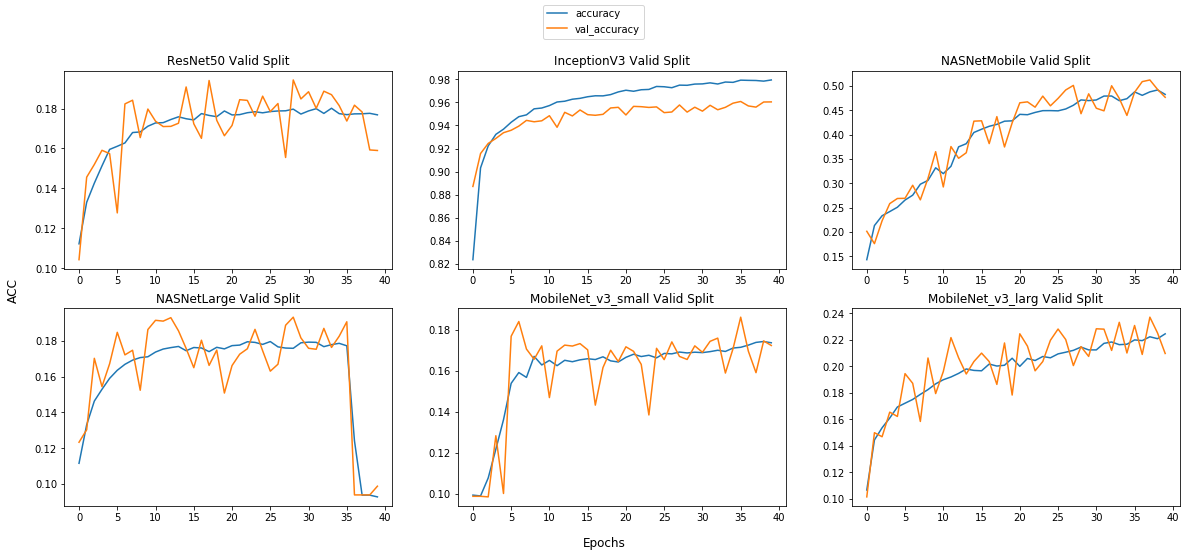

In [16]:
import matplotlib.pyplot as plt
def plot_graphs(model, name):
#     plt.plot(model['loss'], label='loss')
#     plt.plot(model['val_loss'], label='val_loss')
    
    plt.plot(model['accuracy'][:40])
#     plt.plot(model['precision'])
#     plt.plot(model['recall'])
#     plt.plot(model['auc'])

#     plt.plot(model['accuracy'], label='accuracy')
#     plt.plot(model['precision'], label='precision')
#     plt.plot(model['recall'], label='recall')
#     plt.plot(model[ 'auc'], label= 'auc')

    plt.plot(model['val_accuracy'][:40], label='val_accuracy')
#     plt.plot(model['val_precision'], label='val_precision')
#     plt.plot(model['val_recall'], label='val_recall')
#     plt.plot(model[ 'val_auc'], label= 'val_auc')
    plt.title(name)
#     plt.legend(loc='best')
#     plt.xlabel("Epochs")
#     plt.ylabel("ACC")
#     plt.show()
#     plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/'+name+'.png')

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
model_stat = Classic_DNN_Models
name = ['ResNet50', 'InceptionV3', 'NASNetMobile', 'NASNetLarge', 'MobileNet_v3_small', 'MobileNet_v3_larg']
count = 0
for i in range(2):
    for j in range(3):
        count +=1
        ax = plt.subplot(2, 3, count)
#         print(f'i: {i}, j: {j}')
        plot_graphs(model_stat[count-1], name[count-1]+' Valid Split')
plt.subplots_adjust(hspace=0.2, wspace=0.2) # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center')

# so far so good, now the trick

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)
# labels = 
# plt.xlabel('time')
# plt.ylabel('Return')
# plt.legend(['Bond Ret','Equity Ret'], loc=0)
fig.text(0.5, 0.06, 'Epochs', fontsize=12, ha='center', va='center')  # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html
fig.text(0.09, 0.5, 'ACC', fontsize=12, ha='center', va='center', rotation='vertical')
fig.legend(['accuracy', 'val_accuracy'], loc='upper center')
plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/6DNN_models_acc_and_valid_acc.png')
plt.show()

## Ploting the Classic DNN models’ Loss vs Epochs

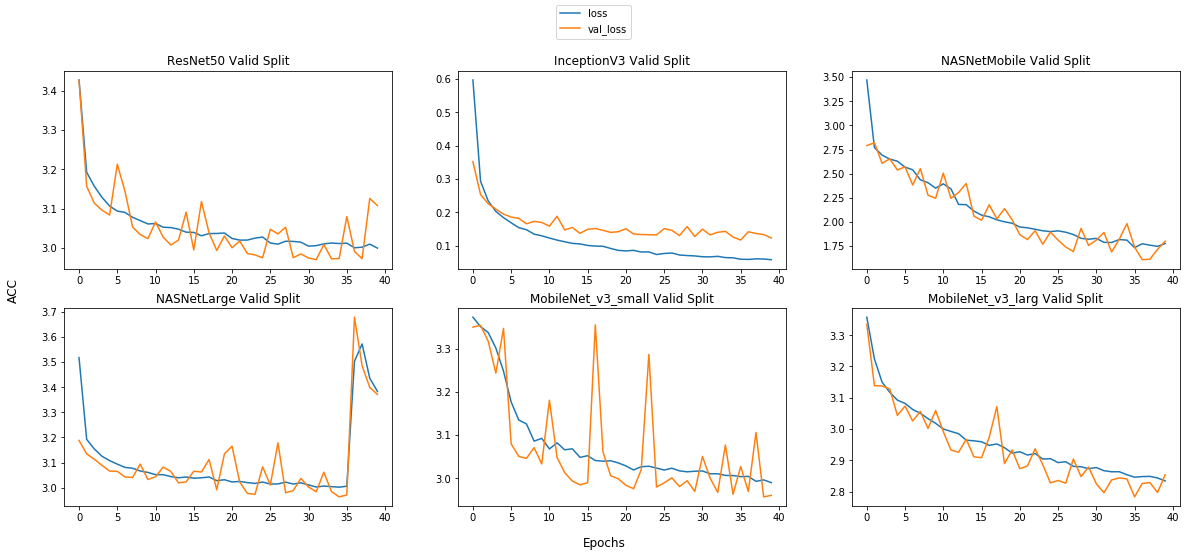

In [17]:
import matplotlib.pyplot as plt
def plot_graphs(model, name):
    plt.plot(model['loss'][:40], label='loss')
    plt.plot(model['val_loss'][:40], label='val_loss')
    
#     plt.plot(model['accuracy'])
#     plt.plot(model['precision'])
#     plt.plot(model['recall'])
#     plt.plot(model['auc'])

#     plt.plot(model['accuracy'], label='accuracy')
#     plt.plot(model['precision'], label='precision')
#     plt.plot(model['recall'], label='recall')
#     plt.plot(model[ 'auc'], label= 'auc')

#     plt.plot(model['val_accuracy'], label='val_accuracy')
#     plt.plot(model['val_precision'], label='val_precision')
#     plt.plot(model['val_recall'], label='val_recall')
#     plt.plot(model[ 'val_auc'], label= 'val_auc')
    plt.title(name)
#     plt.legend(loc='best')
#     plt.xlabel("Epochs")
#     plt.ylabel("ACC")
#     plt.show()
#     plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/'+name+'.png')

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
model_stat = Classic_DNN_Models
name = ['ResNet50', 'InceptionV3', 'NASNetMobile', 'NASNetLarge', 'MobileNet_v3_small', 'MobileNet_v3_larg']
count = 0
for i in range(2):
    for j in range(3):
        count +=1
        ax = plt.subplot(2, 3, count)
#         print(f'i: {i}, j: {j}')
        plot_graphs(model_stat[count-1], name[count-1]+' Valid Split')
plt.subplots_adjust(hspace=0.2, wspace=0.2) # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center')

# so far so good, now the trick

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)
# labels = 
# plt.xlabel('time')
# plt.ylabel('Return')
# plt.legend(['Bond Ret','Equity Ret'], loc=0)
fig.text(0.5, 0.06, 'Epochs', fontsize=12, ha='center', va='center')  # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html
fig.text(0.09, 0.5, 'ACC', fontsize=12, ha='center', va='center', rotation='vertical')
fig.legend(['loss', 'val_loss'], loc='upper center')
plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/6DNN_models_loss_and_valid_loss.png')
plt.show()

## Comparing train-valid set division ratio on 3 different DNN models

KeyError: 0

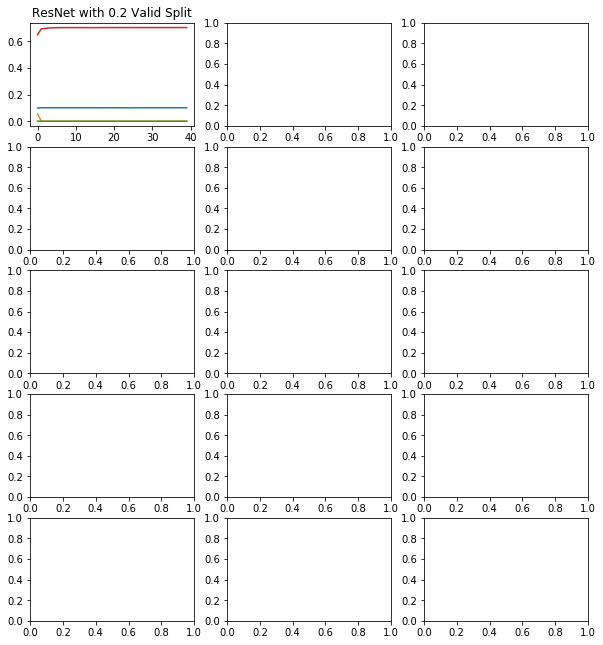

In [61]:
import matplotlib.pyplot as plt
def plot_graphs(model, name):
#     plt.plot(model['loss'], label='loss')
#     plt.plot(model['val_loss'], label='val_loss')
    
    plt.plot(model['accuracy'])
    plt.plot(model['precision'])
    plt.plot(model['recall'])
    plt.plot(model['auc'])

#     plt.plot(model['accuracy'], label='accuracy')
#     plt.plot(model['precision'], label='precision')
#     plt.plot(model['recall'], label='recall')
#     plt.plot(model[ 'auc'], label= 'auc')

#     plt.plot(model['val_accuracy'], label='val_accuracy')
#     plt.plot(model['val_precision'], label='val_precision')
#     plt.plot(model['val_recall'], label='val_recall')
#     plt.plot(model[ 'val_auc'], label= 'val_auc')
    plt.title(name)
#     plt.legend(loc='best')
#     plt.xlabel("Epochs")
#     plt.ylabel("ACC")
#     plt.show()
#     plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/'+name+'.png')

fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(10, 11))
model_stat = [ResNet, InceptionV3, NASNet]
name = ['ResNet', 'InceptionV3', 'NASNet']
split = ['0.2', '0.4', '0.5', '0.6', '0.8']
count = 0
for i in range(5):
    for j in range(3):
        count +=1
        ax = plt.subplot(5, 3, count)
        plot_graphs(model_stat[j][i], name[j]+' with '+split[i]+' Valid Split')
plt.subplots_adjust(hspace=0.6, wspace=0.5) # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center')

# so far so good, now the trick

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)
# labels = 
# plt.xlabel('time')
# plt.ylabel('Return')
# plt.legend(['Bond Ret','Equity Ret'], loc=0)
fig.text(0.5, 0.09, 'Epochs', fontsize=12, ha='center', va='center')  # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html
fig.text(0.06, 0.5, 'ACC', fontsize=12, ha='center', va='center', rotation='vertical')
fig.legend(['accuracy', 'precision', 'recall', 'auc'], loc='lower center')
plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/5x3.png')
plt.show()

# plot_graphs(ResNet_02, 'ResNet with 0.2 Validation Split')
# plot_graphs(ResNet_04, 'ResNet with 0.4 Validation Split')
# plot_graphs(ResNet_05, 'ResNet with 0.5 Validation Split')
# plot_graphs(ResNet_06, 'ResNet with 0.6 Validation Split')
# plot_graphs(ResNet_08, 'ResNet with 0.8 Validation Split')

# plot_graphs(InceptionV3_02, 'InceptionV3 with 0.2 Validation Split')
# plot_graphs(InceptionV3_04, 'InceptionV3 with 0.4 Validation Split')
# plot_graphs(InceptionV3_05, 'InceptionV3 with 0.5 Validation Split')
# plot_graphs(InceptionV3_06, 'InceptionV3 with 0.6 Validation Split')
# plot_graphs(InceptionV3_08, 'InceptionV3 with 0.8 Validation Split')

# plot_graphs(NASNet_02, 'NASNet with 0.2 Validation Split')
# plot_graphs(NASNet_04, 'NASNet with 0.4 Validation Split')
# plot_graphs(NASNet_05, 'NASNet with 0.5 Validation Split')
# plot_graphs(NASNet_06, 'NASNet with 0.6 Validation Split')
# plot_graphs(NASNet_08, 'NASNet with 0.8 Validation Split')
# plt.show()

KeyError: 0

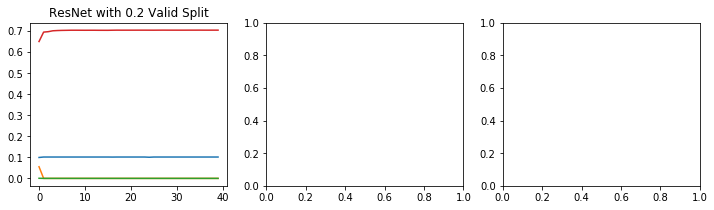

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
model_stat = [ResNet, InceptionV3, NASNet]
name = ['ResNet', 'InceptionV3', 'NASNet']
split = ['0.2', '0.4', '0.5', '0.6', '0.8']
count = 0
for i in range(1):
    for j in range(3):
        count +=1
        ax = plt.subplot(1, 3, count)
        plot_graphs(model_stat[j][i], name[j]+' with '+split[i]+' Valid Split')
plt.subplots_adjust(hspace=0.5, wspace=0.3) # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center')

# so far so good, now the trick

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)
# labels = 
# plt.xlabel('time')
# plt.ylabel('Return')
# plt.legend(['Bond Ret','Equity Ret'], loc=0)
fig.text(0.5, 0.01, 'Epochs', fontsize=12, ha='center', va='center')  # https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.text.html
fig.text(0.08, 0.5, 'ACC', fontsize=12, ha='center', va='center', rotation='vertical')
fig.legend(['accuracy', 'precision', 'recall', 'auc'], loc='best')
plt.savefig('/users/PAA0023/dong760/plant_leaves_diagnosis/1x3.png')
plt.show()

# plot_graphs(ResNet_02, 'ResNet with 0.2 Validation Split')
# plot_graphs(ResNet_04, 'ResNet with 0.4 Validation Split')
# plot_graphs(ResNet_05, 'ResNet with 0.5 Validation Split')
# plot_graphs(ResNet_06, 'ResNet with 0.6 Validation Split')
# plot_graphs(ResNet_08, 'ResNet with 0.8 Validation Split')

# plot_graphs(InceptionV3_02, 'InceptionV3 with 0.2 Validation Split')
# plot_graphs(InceptionV3_04, 'InceptionV3 with 0.4 Validation Split')
# plot_graphs(InceptionV3_05, 'InceptionV3 with 0.5 Validation Split')
# plot_graphs(InceptionV3_06, 'InceptionV3 with 0.6 Validation Split')
# plot_graphs(InceptionV3_08, 'InceptionV3 with 0.8 Validation Split')

# plot_graphs(NASNet_02, 'NASNet with 0.2 Validation Split')
# plot_graphs(NASNet_04, 'NASNet with 0.4 Validation Split')
# plot_graphs(NASNet_05, 'NASNet with 0.5 Validation Split')
# plot_graphs(NASNet_06, 'NASNet with 0.6 Validation Split')
# plot_graphs(NASNet_08, 'NASNet with 0.8 Validation Split')
# plt.show()

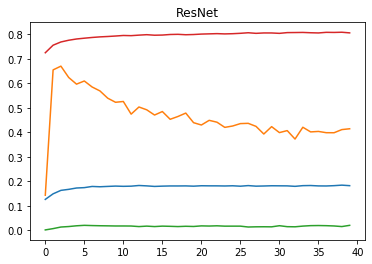

In [59]:


plot_graphs(ResNet[1], 'ResNet')


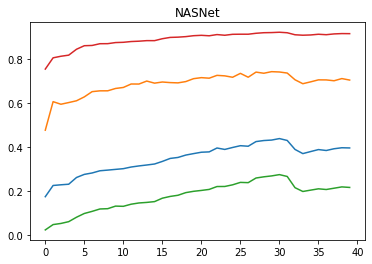

In [60]:
plot_graphs(NASNet[2], 'NASNet')


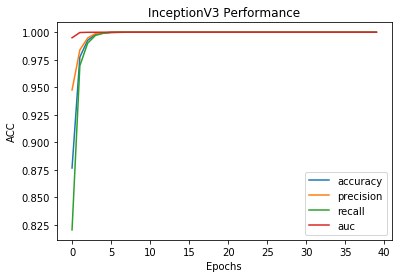

In [32]:
plot_graphs(InceptionV3_stat, 'InceptionV3')
